# Predict a player's FotMob rating

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
all_players_games_2022_2023 = "https://docs.google.com/spreadsheets/d/1nEk26AUwQsIHWTeLdLKc6U7lL5WnWt2o1CwurPEtQss/gviz/tq?tqx=out:csv&sheet=sample_1"
players_df = pd.read_csv(all_players_games_2022_2023)


In [4]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)


# Data cleaning and preparation
- **Columns to drop:** We will drop the following columns as they are not useful for our analysis: `imageUrl`, `id`, `usingOptaId`, `saison`, `pageUrl`, `Unnamed: 0`, `matchUrl`, `teamData`, `fantasyScore`, `shirt`, and `positionRow`.

- **Additional columns to drop:** We will also drop the `shortName` and `positionStringShort` columns as they have a high percentage of missing values (> 47%).

- We will only keep players who have data on their minutes played (`minutesPlayed`), shotmap (`shotmap`), and team (`teamData`) as only these players have a rating. Therefore, we will drop all rows that have missing values in any of these columns.

- The `role` and `usualPosition` columns represent the same information, so we will drop the `usualPosition` column.

- The `role` column has a low percentage of missing values (< 0.01%), so we will drop rows that have missing values in this column.



In [127]:
players_df.tail()

Unnamed: 0.2  Unnamed: 0       id  usingOptaId  \
64279         55534          44   675327        False   
64280         55535          45  1050165        False   
64281         55536          46   291655        False   
64282         55537          47  1072472        False   
64283         55538          48    31047        False   

                                                    name  \
64279  {'firstName': 'Pasquale', 'lastName': 'Mazzocc...   
64280     {'firstName': 'Lorenzo', 'lastName': 'Pirola'}   
64281    {'firstName': 'Norbert', 'lastName': 'Gyömbér'}   
64282   {'firstName': 'Flavius', 'lastName': 'Daniliuc'}   
64283    {'firstName': 'Guillermo', 'lastName': 'Ochoa'}   

                                                imageUrl  \
64279  https://images.fotmob.com/image_resources/play...   
64280  https://images.fotmob.com/image_resources/play...   
64281  https://images.fotmob.com/image_resources/play...   
64282  https://images.fotmob.com/image_resources/play...   
64283  https://images.fotmob.com/image_resources/play...   

                                  pageUrl  shirt  isHomeTeam  timeSubbedOn  \
64279  /players/675327/pasquale-mazzocchi     30       False           NaN   
64280     /players/1050165/lorenzo-pirola     98       False           NaN   
64281      /players/291655/norbert-gymbér     23       False           NaN   
64282   /players/1072472/flavius-daniliuc      5       False           NaN   
64283      /players/31047/guillermo-ochoa     13       False           NaN   

       timeSubbedOff  usualPosition  positionRow      role  \
64279           83.0              1            3  Defender   
64280           68.0              1            1  Defender   
64281            NaN              1            1  Defender   
64282            NaN              1            1  Defender   
64283            NaN              0            0    Keeper   

                           events     teamName home_team    away_team  score  \
64279  {'sub': {'subbedOut': 83}}  Salernitana     Milan  Salernitana  1 - 1   
64280  {'sub': {'subbedOut': 68}}  Salernitana     Milan  Salernitana  1 - 1   
64281                          {}  Salernitana     Milan  Salernitana  1 - 1   
64282                          {}  Salernitana     Milan  Salernitana  1 - 1   
64283                          {}  Salernitana     Milan  Salernitana  1 - 1   

      shortName                                           matchUrl  \
64279       NaN  https://www.fotmob.com/match/3919295/matchfact...   
64280       NaN  https://www.fotmob.com/match/3919295/matchfact...   
64281       NaN  https://www.fotmob.com/match/3919295/matchfact...   
64282       NaN  https://www.fotmob.com/match/3919295/matchfact...   
64283       NaN  https://www.fotmob.com/match/3919295/matchfact...   

                                                  rating  \
64279  {'num': '7.1', 'bgcolor': '#1ec853', 'isTop': ...   
64280  {'num': '6.4', 'bgcolor': '#f08022', 'isTop': ...   
64281  {'num': '7.4', 'bgcolor': '#1ec853', 'isTop': ...   
64282  {'num': '6.7', 'bgcolor': '#f08022', 'isTop': ...   
64283  {'num': '6.5', 'bgcolor': '#f08022', 'isTop': ...   

                fantasyScore  minutesPlayed  \
64279  {'bgcolor': 'purple'}           83.0   
64280  {'bgcolor': 'purple'}           68.0   
64281  {'bgcolor': 'purple'}           90.0   
64282  {'bgcolor': 'purple'}           90.0   
64283  {'bgcolor': 'purple'}           90.0   

                                                 shotmap  \
64279  [{'id': 2519903395, 'eventType': 'AttemptSaved...   
64280                                                 []   
64281                                                 []   
64282                                                 []   
64283                                                 []   

                                                   stats  \
64279  [{'title': 'Top stats', 'stats': {'FotMob rati...   
64280  [{'title': 'Top stats', 'stats': {'FotMob rati...   
64281  [{'tit

In [6]:
print(f"The number of rows is {players_df.shape[0]}")

The number of rows is 64284


In [7]:
(players_df.isna().sum()/players_df.shape[0]).sort_values(ascending=False)

shortName              0.996687
timeSubbedOn           0.794708
timeSubbedOff          0.794708
positionStringShort    0.522089
saison                 0.174849
Unnamed: 0.1           0.136037
isCaptain              0.093771
rating                 0.082913
fantasyScore           0.082913
minutesPlayed          0.082913
shotmap                0.082913
stats                  0.082913
teamData               0.082913
role                   0.000809
away_team              0.000000
matchUrl               0.000000
score                  0.000000
Unnamed: 0.2           0.000000
home_team              0.000000
Unnamed: 0             0.000000
events                 0.000000
positionRow            0.000000
usualPosition          0.000000
isHomeTeam             0.000000
shirt                  0.000000
pageUrl                0.000000
imageUrl               0.000000
name                   0.000000
usingOptaId            0.000000
id                     0.000000
teamName               0.000000
dtype: f

In [8]:
players_df.saison.value_counts()

2022-2023    53044
Name: saison, dtype: int64

In [9]:
# check if players who played a game could not have a rating
players_df[players_df.rating.isna() & ~players_df.minutesPlayed.isna()].head()

Empty DataFrame
Columns: [Unnamed: 0.2, Unnamed: 0, id, usingOptaId, name, imageUrl, pageUrl, shirt, isHomeTeam, timeSubbedOn, timeSubbedOff, usualPosition, positionRow, role, events, teamName, home_team, away_team, score, shortName, matchUrl, rating, fantasyScore, minutesPlayed, shotmap, stats, teamData, positionStringShort, isCaptain, Unnamed: 0.1, saison]
Index: []

In [10]:
for value in players_df.usualPosition.unique():
    print(value, players_df[players_df["usualPosition"] == value].role.value_counts(dropna=False))

3 Attacker    15078
Name: role, dtype: int64
2 Midfielder    20388
Name: role, dtype: int64
1 Defender    21431
Name: role, dtype: int64
0 Keeper    7335
Name: role, dtype: int64
-1 NaN    52
Name: role, dtype: int64


In [11]:
# drop columns
players_ndf = players_df.drop(["imageUrl", "id", "usingOptaId", "saison", "pageUrl", "Unnamed: 0", "shortName", "positionStringShort", "matchUrl", "teamData", "usualPosition", "fantasyScore", "shirt", "positionRow"],axis=1)
players_ndf = players_ndf[~players_ndf["rating"].isna()]
players_ndf = players_ndf[~players_ndf["role"].isna()]

In [12]:
# add isSubbedOn and isSubbedOff columns to check if a player is subbed on/off or not
players_ndf["isSubbedOn"] = players_ndf["timeSubbedOn"].fillna(0).apply(lambda x:1 if x > 0 else 0)
players_ndf["isSubbedOff"] = players_ndf["timeSubbedOff"].fillna(0).apply(lambda x:1 if x > 0 else 0)
players_ndf = players_ndf.drop(["timeSubbedOn", "timeSubbedOff"],axis=1)

In [13]:
players_ndf = players_ndf.reset_index(drop=True)

# Feature engineering


In [14]:
# convert to json
columns = ["name", "events", "rating","shotmap"]
for column in columns:
    players_ndf[column] = players_ndf[column].apply(lambda x:eval(x))

In [15]:
players_ndf["name"] = players_ndf['name'].apply(lambda x: (x['firstName'] + " " + x['lastName']))

In [16]:
# add a row **team_score** to get the goals scored by the player's team 
players_ndf["team_score"] = np.where(players_ndf['home_team'] == players_ndf.teamName,
                                         players_ndf['score'].str.split(" - ").apply(lambda x: x[0]),
                                         players_ndf['score'].str.split(" - ").apply(lambda x: x[1]))

# add a row **opponent_score** to get the goals scored by the opponent team
players_ndf["opponent_score"] = np.where(players_ndf['away_team'] == players_ndf.teamName,
                                         players_ndf['score'].str.split(" - ").apply(lambda x: x[0]),
                                         players_ndf['score'].str.split(" - ").apply(lambda x: x[1]))

players_ndf["score_difference"] = players_ndf["team_score"].astype(int) - players_ndf["opponent_score"].astype(int)

In [17]:
players_ndf = players_ndf.drop(["score"], axis=1)

In [18]:
# add a row **result** to get the result of the match
def result(row):
    if row["team_score"] > row ["opponent_score"]:
        return "Win"
    elif row["team_score"] < row ["opponent_score"]:
        return "Lose"
    else:
        return "Draw"
#match result
players_ndf["result"] = players_ndf.apply(result, axis=1)

In [19]:
players_ndf.head()

Unnamed: 0.2               name  isHomeTeam        role  \
0          1453     Ramil Sheydaev        True    Attacker   
1          1454  Ismayil Ibrahimli        True  Midfielder   
2          1455     Tural Bayramov        True    Defender   
3          1456      Owusu Kwabena        True    Attacker   
4          1457     Abbas Huseynov        True    Defender   

                               events    teamName   home_team  away_team  \
0  {'yc': 1, 'sub': {'subbedIn': 59}}  Qarabag FK  Qarabag FK  FC Zürich   
1           {'sub': {'subbedIn': 71}}  Qarabag FK  Qarabag FK  FC Zürich   
2           {'sub': {'subbedIn': 71}}  Qarabag FK  Qarabag FK  FC Zürich   
3           {'sub': {'subbedIn': 78}}  Qarabag FK  Qarabag FK  FC Zürich   
4           {'sub': {'subbedIn': 78}}  Qarabag FK  Qarabag FK  FC Zürich   

                                              rating  minutesPlayed  \
0  {'num': '5.9', 'bgcolor': '#f08022', 'isTop': ...           31.0   
1  {'num': '6.5', 'bgcolor': '#f08022', 'isTop': ...           19.0   
2  {'num': '5.9', 'bgcolor': '#f08022', 'isTop': ...           19.0   
3  {'num': '6.1', 'bgcolor': '#f08022', 'isTop': ...           12.0   
4  {'num': '6.0', 'bgcolor': '#f08022', 'isTop': ...           12.0   

                                             shotmap  \
0  [{'id': 2437727351, 'eventType': 'AttemptSaved...   
1                                                 []   
2  [{'id': 2437727475, 'eventType': 'AttemptSaved...   
3  [{'id': 2437728431, 'eventType': 'Miss', 'team...   
4                                                 []   

                                               stats isCaptain  Unnamed: 0.1  \
0  [{'title': 'Top stats', 'stats': {'FotMob rati...       NaN           NaN   
1  [{'title': 'Top stats', 'stats': {'FotMob rati...       NaN           NaN   
2  [{'title': 'Top stats', 'stats': {'FotMob rati...       NaN           NaN   
3  [{'title': 'Top stats', 'stats': {'FotMob rati...       NaN           NaN   
4  [{'title': 'Top stats', 'stats': {'FotMob rati...       NaN           NaN   

   isSubbedOn  isSubbedOff team_score opponent_score  score_difference result  
0           1            0          3              2                 1    Win  
1           1            0          3              2                 1    Win  
2           1            0          3              2                 1    Win  
3           1            0          3              2                 1    Win  
4           1            0          3              2                 1    Win

## shotmap
- **Column to drop:** We will drop this column as there is no useful information to extract from it, and all the necessary information already exists in the `stats` column.


In [20]:
players_ndf.iloc[3].shotmap, players_ndf.iloc[3].stats

([{'id': 2437728431,
   'eventType': 'Miss',
   'teamId': 7981,
   'playerId': 791675,
   'playerName': 'Owusu Kwabena',
   'x': 87.10440848824823,
   'y': 40.30142793076755,
   'min': 86,
   'minAdded': None,
   'isBlocked': False,
   'isOnTarget': False,
   'blockedX': None,
   'blockedY': None,
   'goalCrossedY': 26.69,
   'goalCrossedZ': 4.4630344888,
   'expectedGoals': 0.048170268535614014,
   'expectedGoalsOnTarget': None,
   'shotType': 'RightFoot',
   'situation': 'RegularPlay',
   'period': 'SecondHalf',
   'isOwnGoal': False,
   'onGoalShot': {'x': 2,
    'y': 0.6105382337619697,
    'zoomRatio': 0.5170998632010942},
   'teamColor': '#100878'}],
 "[{'title': 'Top stats', 'stats': {'FotMob rating': 6.14, 'Minutes played': 12, 'Goals': 0, 'Assists': 0, 'Total shots': 1, 'Shotmap': True, 'Accurate passes': '3/4 (75%)', 'Chances created': 0, 'Expected goals (xG)': '0.05', 'Expected assists (xA)': '0.01'}}, {'title': 'Attack', 'stats': {'Shot accuracy': '0/1 (0%)', 'Touches': 6, 

In [21]:
(players_ndf.shotmap.str.len()).value_counts()

0     39419
1     10665
2      4954
3      2221
4       973
5       401
6       175
7        66
8        31
9         9
10        4
11        2
Name: shotmap, dtype: int64

In [22]:
players_ndf[(players_ndf.shotmap.str.len() > 0)].role.value_counts()

Attacker      7572
Midfielder    7193
Defender      4726
Keeper          10
Name: role, dtype: int64

In [23]:
players_ndf = players_ndf.drop(["shotmap"], axis=1)

## rating
- We have 15853 rows with missing values in the `rating` column, likely due to players playing only a few minutes in the game. We will drop these rows.


In [24]:
rating = pd.json_normalize(players_ndf.rating)
players_ndf.loc[rating[rating.num.isna()].index].minutesPlayed.describe()

count    19273.000000
mean         0.799408
std          2.117777
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: minutesPlayed, dtype: float64

In [25]:
rating = rating[~rating.num.isna()].drop(["isTop.isMatchFinished"], axis=1)


In [26]:
rating.head()

num  bgcolor isTop.isTopRating
0  5.9  #f08022             False
1  6.5  #f08022             False
2  5.9  #f08022             False
3  6.1  #f08022             False
4  6.0  #f08022             False

## events
- `yc`: Number of yellow cards received by the player.
- `ycrc`: Number of times the player received two yellow cards in a game, resulting in a red card.
- `rc`: Number of direct red cards received by the player.
- `mp`: Number of penalties missed by the player.
- `og`: Number of own goals scored by the player.
- `as`: Number of assists made by the player.
- `g`: Number of goals scored by the player.



In [27]:
events_df = (pd.json_normalize(players_ndf.events)).drop(["sub.subbedIn", "undefined", "sub.subbedOut"], axis=1)
events_df

yc  as   g  mp  og  ycrc  savedPenalties  rc
0      1.0 NaN NaN NaN NaN   NaN             NaN NaN
1      NaN NaN NaN NaN NaN   NaN             NaN NaN
2      NaN NaN NaN NaN NaN   NaN             NaN NaN
3      NaN NaN NaN NaN NaN   NaN             NaN NaN
4      NaN NaN NaN NaN NaN   NaN             NaN NaN
...    ...  ..  ..  ..  ..   ...             ...  ..
58915  NaN NaN NaN NaN NaN   NaN             NaN NaN
58916  NaN NaN NaN NaN NaN   NaN             NaN NaN
58917  NaN NaN NaN NaN NaN   NaN             NaN NaN
58918  NaN NaN NaN NaN NaN   NaN             NaN NaN
58919  NaN NaN NaN NaN NaN   NaN             NaN NaN

[58920 rows x 8 columns]

In [28]:
events_df = events_df.fillna(0)

In [29]:
pd.merge(events_df, rating, how='inner', right_index=True, left_index=True)

yc   as    g   mp   og  ycrc  savedPenalties   rc  num  bgcolor  \
0      1.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  5.9  #f08022   
1      0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.5  #f08022   
2      0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  5.9  #f08022   
3      0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.1  #f08022   
4      0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.0  #f08022   
...    ...  ...  ...  ...  ...   ...             ...  ...  ...      ...   
58915  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  7.1  #1ec853   
58916  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.4  #f08022   
58917  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  7.4  #1ec853   
58918  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.7  #f08022   
58919  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  6.5  #f08022   

      isTop.isTopRating  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
...                 ...  
58915             False  
58916             False  
58917             False  
58918             False  
58919             False  

[39647 rows x 11 columns]

## stats

In [30]:
stats_df = pd.json_normalize(players_ndf.stats.apply(lambda x : {k:v for item in eval(x) for k,v in item["stats"].items()}))

In [31]:
sdf = stats_df.copy()
sdf["role"] = players_ndf.role
sdf = sdf[sdf["FotMob rating"] > 0]
sdf.head()

FotMob rating  Minutes played  Goals  Assists  Total shots Shotmap  \
0           5.91            31.0    0.0      0.0          1.0    True   
1           6.46            19.0    0.0      0.0          0.0     NaN   
2           5.93            19.0    0.0      0.0          1.0    True   
3           6.14            12.0    0.0      0.0          1.0    True   
4           5.95            12.0    0.0      0.0          0.0     NaN   

  Accurate passes  Chances created Expected goals (xG) Expected assists (xA)  \
0       7/8 (88%)              0.0                0.03                  0.06   
1     14/20 (70%)              0.0                 NaN                   NaN   
2     11/12 (92%)              0.0                0.03                  0.03   
3       3/4 (75%)              0.0                0.05                  0.01   
4      9/9 (100%)              0.0                 NaN                   NaN   

   Blocked shots  Touches Accurate crosses  Dispossessed Tackles won  \
0            1.0     12.0       1/1 (100%)           0.0           0   
1            NaN     24.0              NaN           0.0    0/1 (0%)   
2            1.0     22.0              NaN           1.0  1/1 (100%)   
3            NaN      6.0              NaN           0.0           0   
4            NaN     10.0              NaN           0.0           0   

  Ground duels won Aerial duels won  Was fouled  Fouls committed  \
0         0/2 (0%)                0         0.0              2.0   
1       1/1 (100%)                0         0.0              0.0   
2        2/4 (50%)                0         0.0              1.0   
3         0/1 (0%)       1/1 (100%)         0.0              0.0   
4         0/1 (0%)                0         0.0              1.0   

   Passes into final third Accurate long balls  Interceptions  Recoveries  \
0                      NaN                 NaN            NaN         NaN   
1                      2.0            0/3 (0%)            1.0         3.0   
2                      2.0                 NaN            NaN         1.0   
3                      2.0                 NaN            NaN         1.0   
4                      NaN                 NaN            NaN         NaN   

   Conceded penalty Successful dribbles Shot accuracy  Offsides  Saves  \
0               NaN                 NaN           NaN       NaN    NaN   
1               NaN                 NaN           NaN       NaN    NaN   
2               1.0          1/1 (100%)           NaN       NaN    NaN   
3               NaN            0/1 (0%)      0/1 (0%)       1.0    NaN   
4               NaN                 NaN           NaN       NaN    NaN   

   Goals conceded xGOT faced  Diving save  Saves inside box  Acted as sweeper  \
0             NaN        NaN          NaN               NaN               NaN   
1             NaN        NaN          NaN               NaN               NaN   
2             NaN        NaN          NaN               NaN               NaN   
3             NaN        NaN          NaN               NaN               NaN   
4             NaN        NaN          NaN               NaN               NaN   

   Punches  Throws  High claim  Blocks  Clearances  Headed clearance  \
0      NaN     NaN         NaN     NaN         NaN               NaN   
1      NaN     NaN         NaN     NaN         NaN               NaN   
2      NaN     NaN         NaN     NaN         NaN               NaN   
3      NaN     NaN         NaN     NaN         NaN               NaN   
4      NaN     NaN         NaN     NaN         NaN               NaN   

   Dribbled past Expected goals on target (xGOT)  Big chance missed  Corners  \
0            NaN                             NaN                NaN      NaN   
1            NaN                             NaN                NaN      NaN   
2            NaN                             NaN                NaN      NaN   
3            NaN                             NaN                NaN      NaN   
4            

# EDA

# rating
- 90% of the ratings fall between 5.7 and 8.2.
- There are some outliers for ratings less than 4.
- There are four types of ratings:
    - <font color='#e55e5b'>low</font>: 4.1 <= rating <= 5.0
    - <font color='#f08022'>medium</font>: 5.0 <= rating <= 6.9
    - <font color='#1ec853'>high</font>: 6.9 <= rating <= 9.8
    - <font color='#0e87e0'>player of the match</font>: 7.4 <= rating <= 9.8



In [32]:
rating.dtypes

num                  object
bgcolor              object
isTop.isTopRating    object
dtype: object

In [33]:
rating["num"] = rating["num"].astype(float)
rating["isTop.isTopRating"] = rating["isTop.isTopRating"].astype(bool)

In [34]:
rating.describe()

num
count  39647.000000
mean       6.854720
std        0.789909
min        2.600000
25%        6.300000
50%        6.800000
75%        7.400000
max        9.800000

Text(0.5, 1.0, 'distribution of rating')

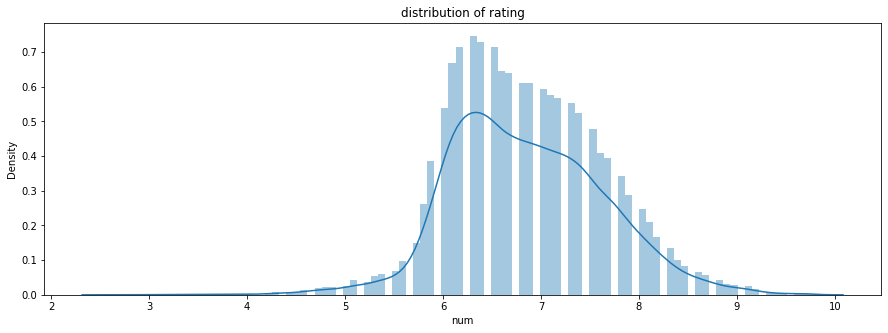

In [35]:
plt.figure(figsize=(15,5))
sns.distplot(rating.num, bins=100)
plt.title("distribution of rating")

In [36]:
((rating.num < 8.2) & (5.7 < rating.num)).mean()

0.8961838222311903

<Axes: >

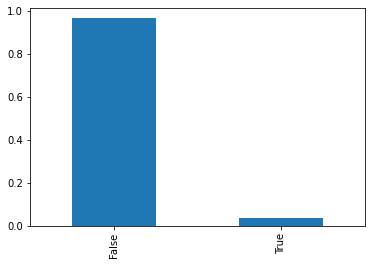

In [37]:
rating["isTop.isTopRating"].value_counts(normalize=True).plot(kind="bar")

In [38]:
rating.groupby("bgcolor").describe()[[('num',   'min'), ('num',   'max')]]

num     
         min  max
bgcolor          
#0e87e0  7.4  9.8
#1ec853  6.9  9.8
#e55e5b  2.6  5.0
#f08022  5.0  6.9

<Axes: >

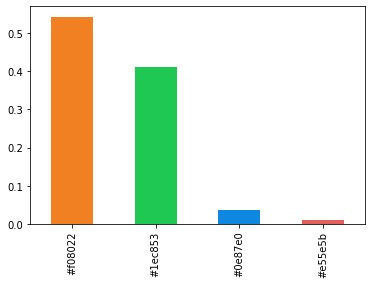

In [39]:
rating.bgcolor.value_counts(normalize=True).plot(kind="bar", color=rating.bgcolor.unique())

In [40]:
rating[rating["isTop.isTopRating"] == True].num.describe()

count    1413.000000
mean        8.511253
std         0.443421
min         7.400000
25%         8.200000
50%         8.500000
75%         8.800000
max         9.800000
Name: num, dtype: float64

In [41]:
players_df["matchUrl"].unique().shape

(1461,)

In [42]:
players_ndf = players_ndf.loc[rating.index]
events_df = events_df.loc[rating.index]
stats_df = stats_df.loc[rating.index]
players_ndf["rating"] = rating.num

<Axes: ylabel='teamName'>

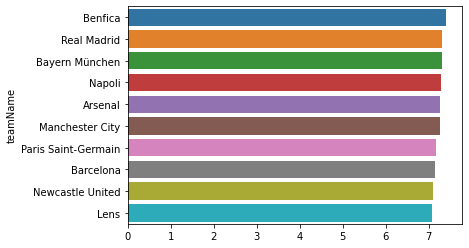

In [43]:
#top 10 rated teams based on players rating
top_10_teams = players_ndf.groupby("teamName").rating.mean().sort_values(ascending=False).iloc[:10]
sns.barplot(x=top_10_teams.values, y=top_10_teams.index)

<Axes: ylabel='name'>

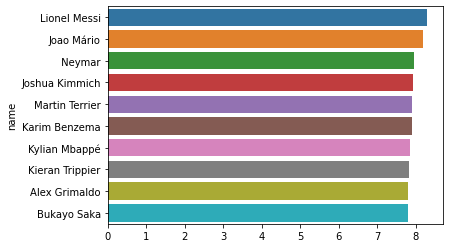

In [44]:
# top 10 rated players who played more than 10 games
played_more_10 = players_ndf.groupby("name").filter(lambda x: len(x) >= 10)
top_10_players = played_more_10.groupby("name").rating.mean().sort_values(ascending=False).iloc[:10]
sns.barplot(x=top_10_players.values, y=top_10_players.index)

## categorical features / Target
- **Result**

> *   It seems like the distribution of player ratings varies depending on the game 
result.
*  The ratings for the "**Lose**" are shifted to the left, with most values falling between 4 and 8.6.
* The "**Draw**" group has a wider range of ratings, with most values between 5 and 9 and a peak around 6 to 7.6.
* The "**Win**" group has the highest ratings, with most values between 6.1 and 8.1 and a maximum value of 9.5.

- **SubbedOff and isHomeTeam**:
    - The distributions of ratings for `SubbedOff` and `isHomeTeam` are almost the same, indicating that rating is independent from them.
- **SubbedOn**:
    - The ratings of substitute players were mostly centered around 6.1, while the distribution of ratings for players who started the game followed a normal distribution with a mean of 7.1.
- **role**:
    - The rating depends on the player's role.

In [45]:
categorical_df = players_ndf[["result", "isSubbedOff", "isSubbedOn", "isHomeTeam", "isCaptain", "role"]]

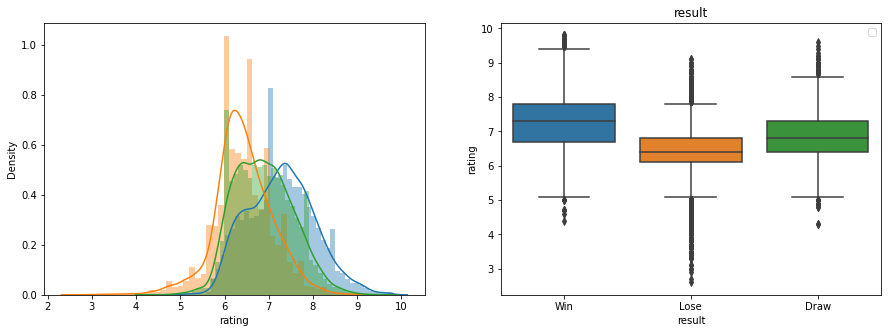

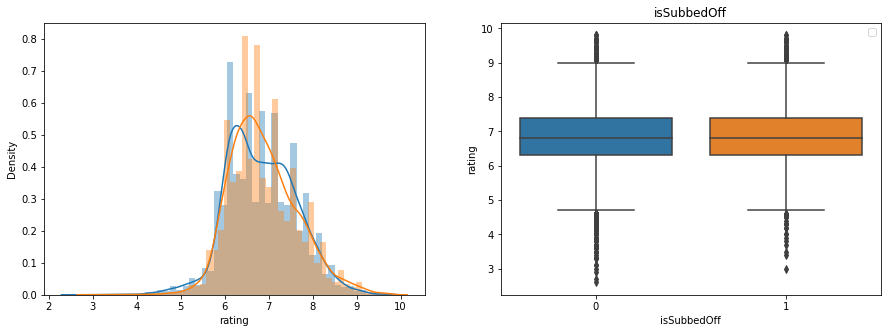

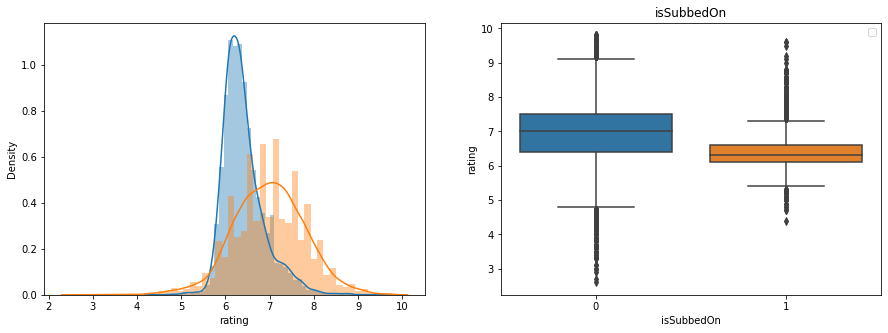

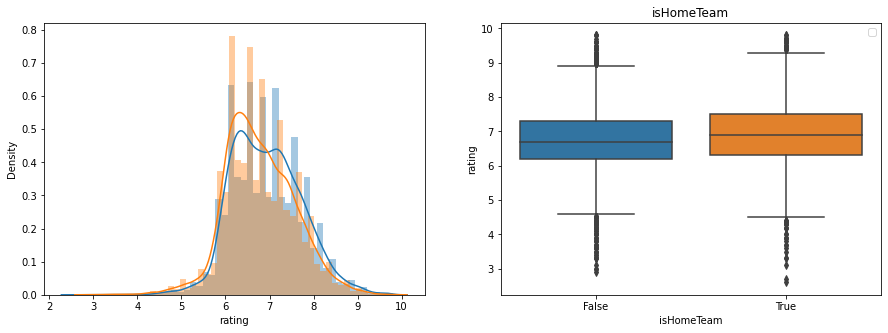

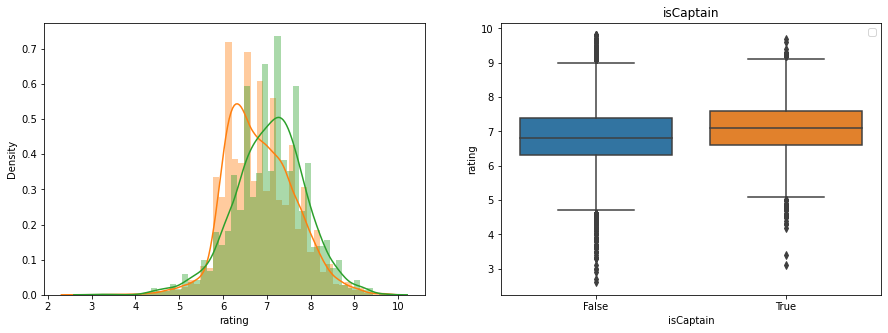

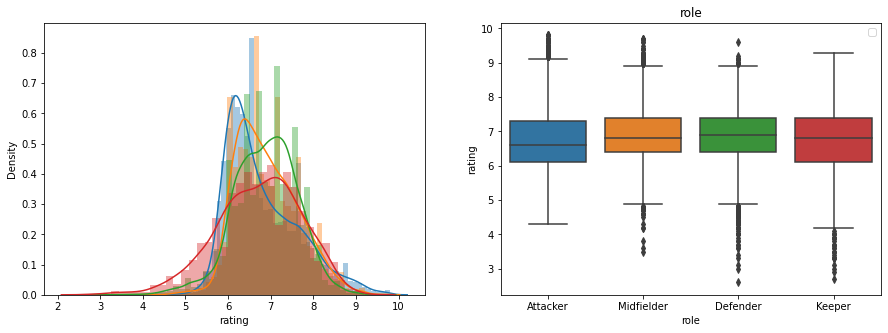

In [46]:
for column in categorical_df.columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    for value in categorical_df[column].unique():
      ax = sns.distplot(players_ndf.loc[players_ndf[column] == value, "rating"], label=value)
    plt.subplot(1, 2,2)
    ax = sns.boxplot(y=players_ndf["rating"], x=players_ndf[column])
    plt.title(column)
    plt.legend()

## numerical features / Target
- correlation between score difference and rating
- There is a strong correlation between `opponent score` and `score difference`, as well as `team score` and `score difference`. To avoid overfitting, we can drop `opponent score` and `team score` columns.

In [47]:
numerical_df = players_ndf[["minutesPlayed", "team_score",	"opponent_score",	"score_difference", "rating"]].astype(float)
numerical_df["bgcolor"] = rating.bgcolor

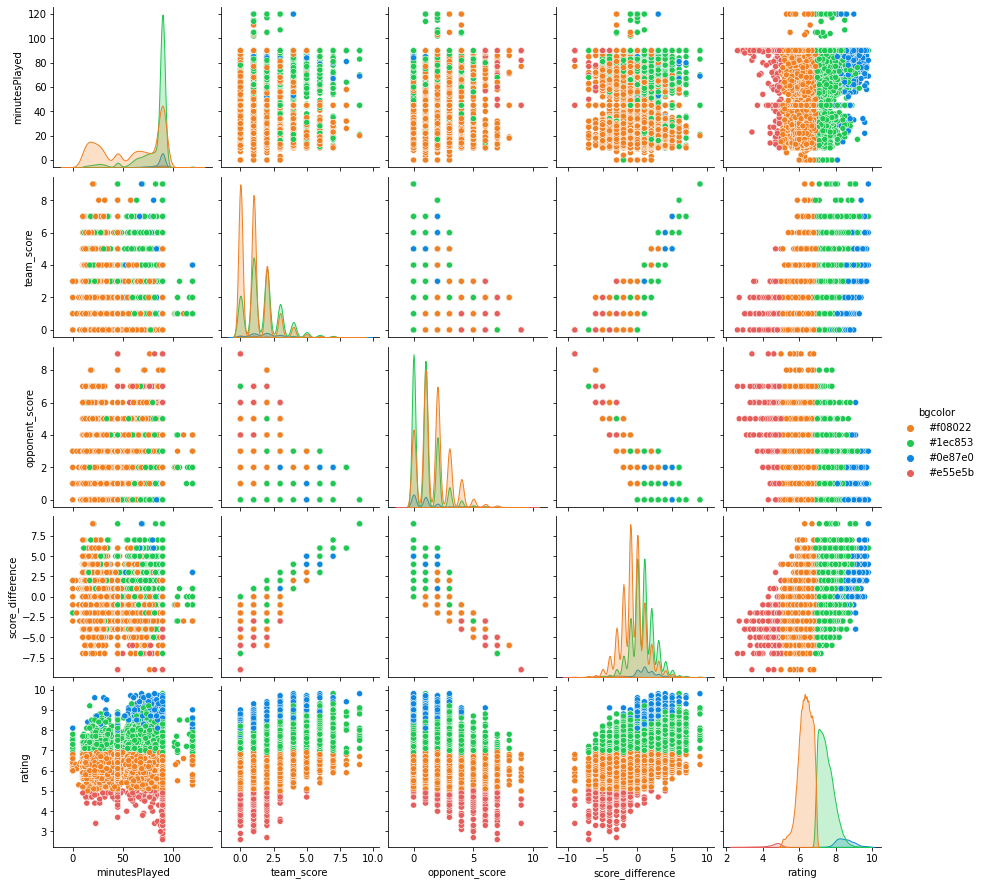

In [48]:
with sns.color_palette(rating.bgcolor.unique()):
    sns.pairplot(numerical_df, hue="bgcolor")

## Events
- The number of direct red cards (rc) and second yellow cards resulting in a subsequent red card (ycrc) is very low.
- Yellow cards (yc) don't affect the player's rating.
- The ratings of players who were given a direct red card or a second yellow card resulting in a subsequent red card were lower than those who did not receive any cards. This suggests that receiving a rc or ycrc can have a negative impact on a player's rating.


In [49]:
events_df.head()

yc   as    g   mp   og  ycrc  savedPenalties   rc
0  1.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0
1  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0
2  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0
3  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0
4  0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0

In [50]:
# drop savedPenalties	, mp,	og, as,	g because they already exists in stats
to_keep = ["ycrc","rc", "yc"]
events_df = events_df[to_keep]

In [51]:
events_df["rating"] = players_ndf["rating"]

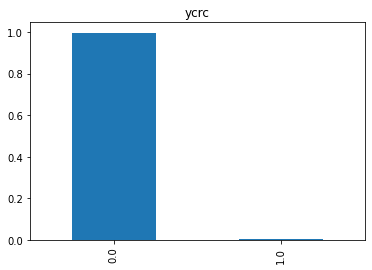

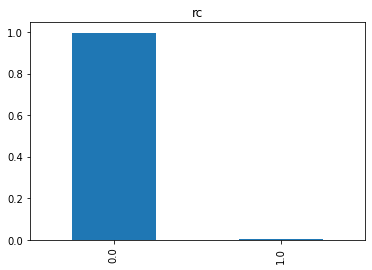

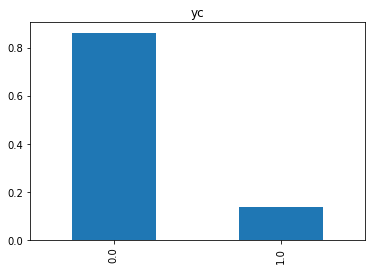

In [52]:
for column in to_keep:
    plt.figure()
    events_df[column].value_counts(normalize=True).plot(kind="bar")
    plt.title(column)

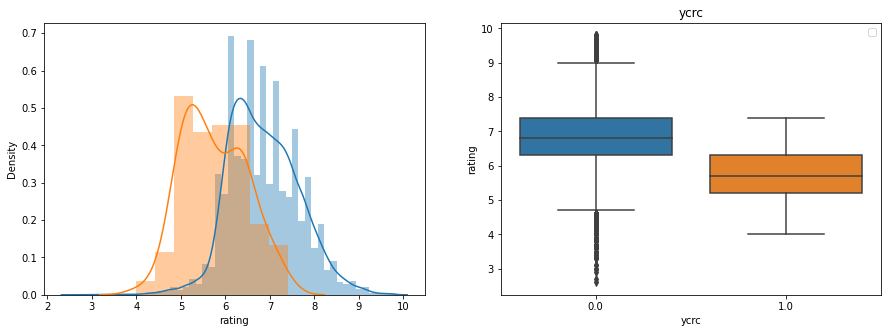

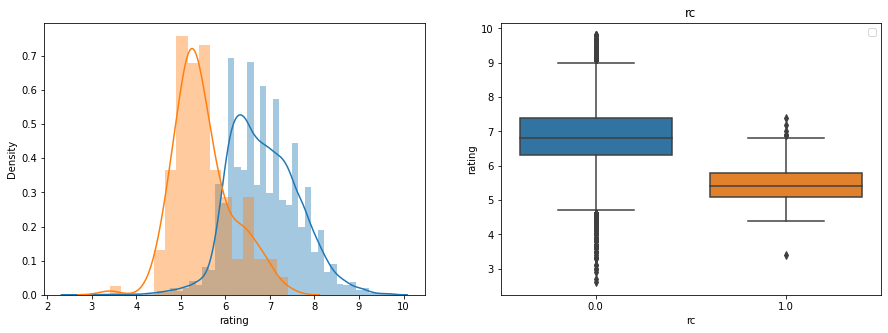

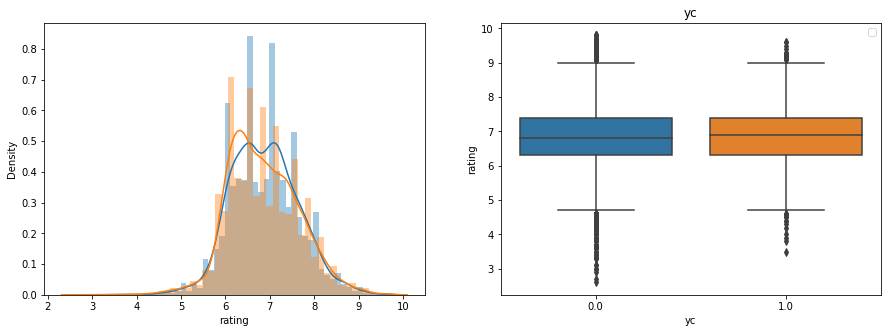

In [53]:
for column in to_keep:
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    for value in events_df[column].unique():
      ax = sns.distplot(events_df.loc[events_df[column] == value, "rating"], label=value)
    plt.subplot(1, 2,2)
    ax = sns.boxplot(y=events_df["rating"], x=events_df[column])
    plt.title(column)
    plt.legend()

## Role
- The percentage of defenders and midfielders in the dataset is higher compared to attackers and keepers. This distribution is normal considering the possible formations in football where 1 to 3 attackers, 3 to 5 midfielders, and 3 to 5 defenders are typically used, with one goalkeeper. 

- Based on our analysis, it appears that each player's role has its own set of metrics for determining their rating. Therefore, it would be best to split the data based on the player's role to get more accurate results in the modeling phase.


<Axes: title={'center': 'Roles'}>

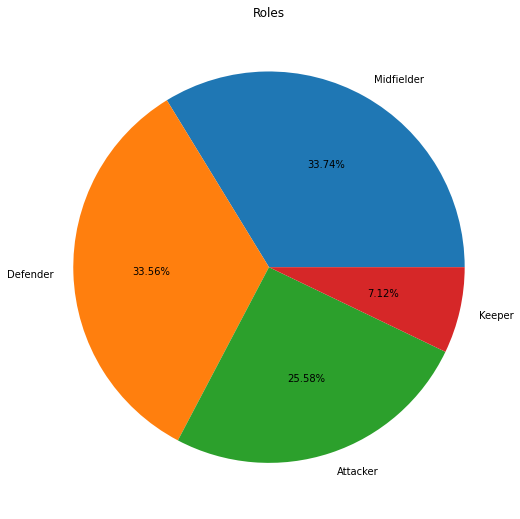

In [54]:
fig = plt.figure(figsize=(16,9))
players_ndf.role.value_counts(normalize=True).plot(kind="pie", autopct='%1.2f%%', title="Roles", ylabel="")

In [55]:
sdf.role.astype("category").cat.codes.corr(sdf["FotMob rating"])

0.04238978879017198

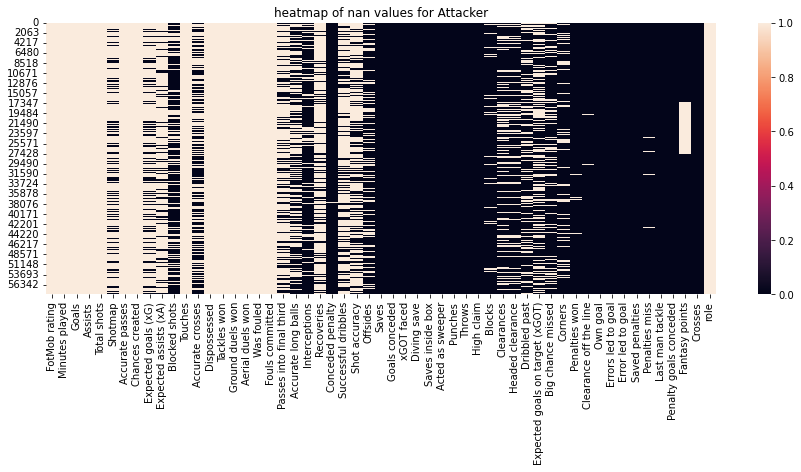

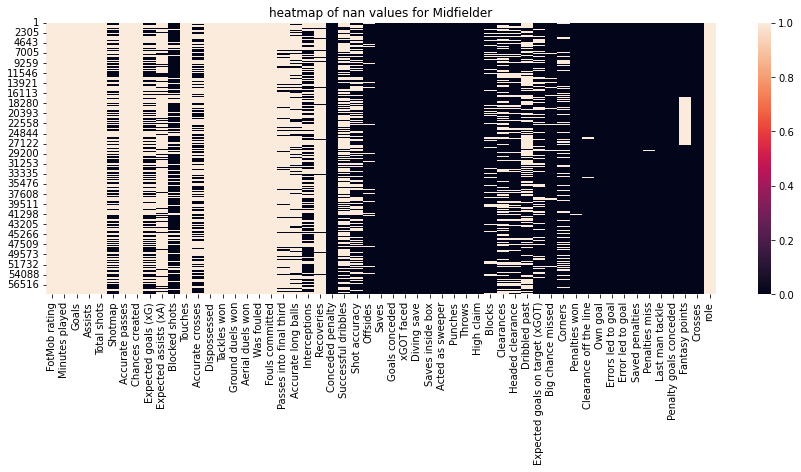

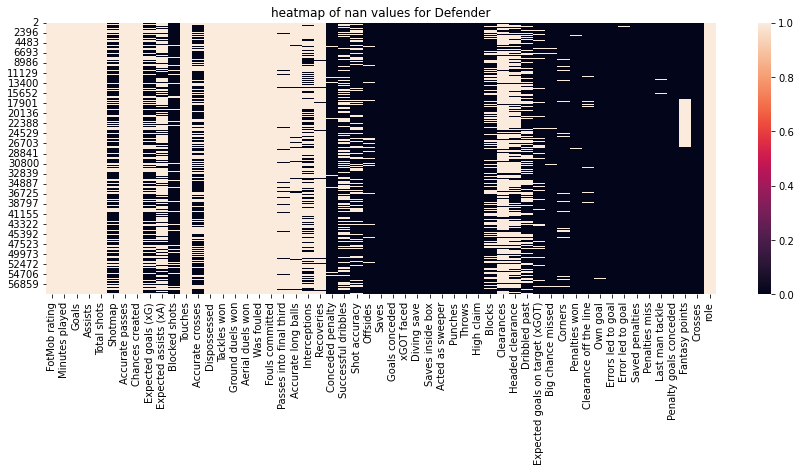

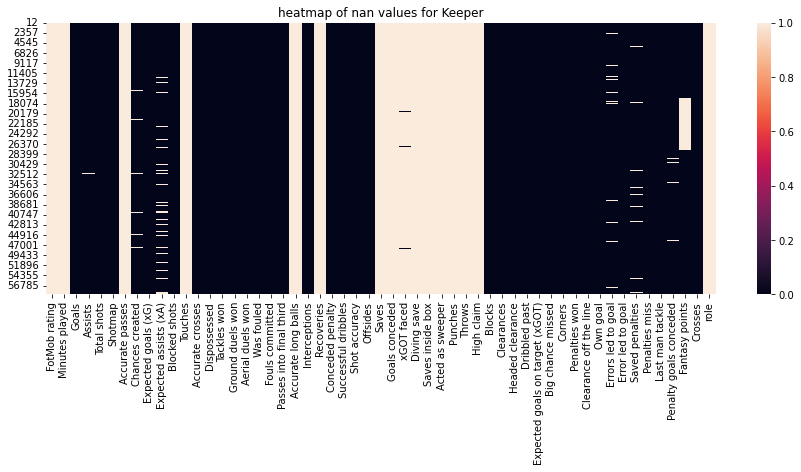

In [56]:
for value in sdf.role.unique():
    plt.figure(figsize=(15,5))
    sns.heatmap(~sdf.query(f"role == '{value}'").isna())
    plt.title(f"heatmap of nan values for {value}")

['FotMob rating', 'Minutes played', 'Goals', 'Assists', 'Total shots', 'Shotmap', 'Accurate passes', 'Chances created', 'Expected goals (xG)', 'Expected assists (xA)', 'Touches', 'Dispossessed', 'Tackles won', 'Ground duels won', 'Aerial duels won', 'Was fouled', 'Fouls committed', 'Passes into final third', 'Recoveries', 'Successful dribbles', 'Shot accuracy', 'role']
['FotMob rating', 'Minutes played', 'Goals', 'Assists', 'Total shots', 'Accurate passes', 'Chances created', 'Expected assists (xA)', 'Touches', 'Dispossessed', 'Tackles won', 'Ground duels won', 'Aerial duels won', 'Was fouled', 'Fouls committed', 'Passes into final third', 'Accurate long balls', 'Recoveries', 'role']
['FotMob rating', 'Minutes played', 'Goals', 'Assists', 'Total shots', 'Accurate passes', 'Chances created', 'Expected assists (xA)', 'Touches', 'Dispossessed', 'Tackles won', 'Ground duels won', 'Aerial duels won', 'Was fouled', 'Fouls committed', 'Passes into final third', 'Accurate long balls', 'Recover

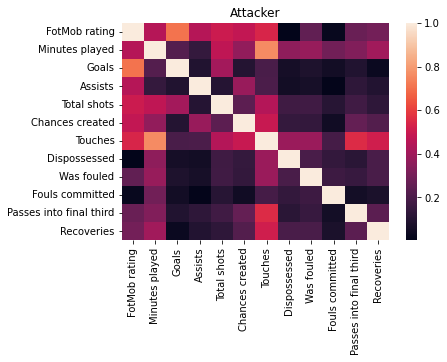

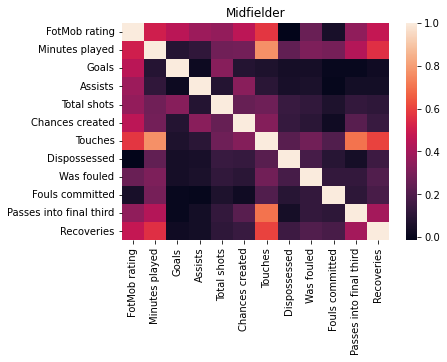

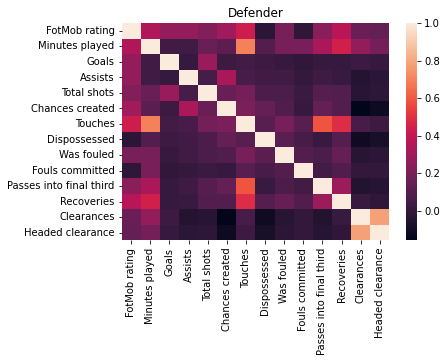

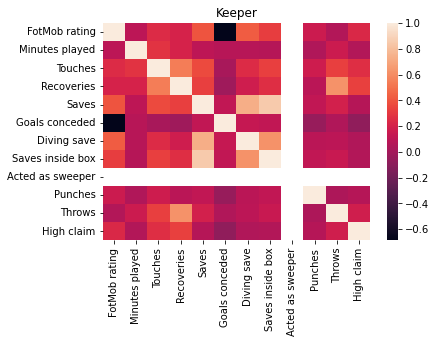

In [57]:
for value in sdf.role.unique():
    plt.figure()
    mean_ = (~sdf.query(f"role == '{value}'").isna()).mean()
    non_missing = mean_[mean_ > 0.6].index.tolist()
    print(non_missing)
    sns.heatmap(sdf.query(f"role == '{value}'")[non_missing].corr())
    plt.title(value)

# clean and analyse stats data for each role

In [58]:
sdf = sdf.drop(["Minutes played", "Shotmap", "Acted as sweeper", "Fantasy points"], axis=1)

In [59]:
sdf = sdf.loc[events_df.index]

In [60]:
sdf.head()

FotMob rating  Goals  Assists  Total shots Accurate passes  \
0           5.91    0.0      0.0          1.0       7/8 (88%)   
1           6.46    0.0      0.0          0.0     14/20 (70%)   
2           5.93    0.0      0.0          1.0     11/12 (92%)   
3           6.14    0.0      0.0          1.0       3/4 (75%)   
4           5.95    0.0      0.0          0.0      9/9 (100%)   

   Chances created Expected goals (xG) Expected assists (xA)  Blocked shots  \
0              0.0                0.03                  0.06            1.0   
1              0.0                 NaN                   NaN            NaN   
2              0.0                0.03                  0.03            1.0   
3              0.0                0.05                  0.01            NaN   
4              0.0                 NaN                   NaN            NaN   

   Touches Accurate crosses  Dispossessed Tackles won Ground duels won  \
0     12.0       1/1 (100%)           0.0           0         0/2 (0%)   
1     24.0              NaN           0.0    0/1 (0%)       1/1 (100%)   
2     22.0              NaN           1.0  1/1 (100%)        2/4 (50%)   
3      6.0              NaN           0.0           0         0/1 (0%)   
4     10.0              NaN           0.0           0         0/1 (0%)   

  Aerial duels won  Was fouled  Fouls committed  Passes into final third  \
0                0         0.0              2.0                      NaN   
1                0         0.0              0.0                      2.0   
2                0         0.0              1.0                      2.0   
3       1/1 (100%)         0.0              0.0                      2.0   
4                0         0.0              1.0                      NaN   

  Accurate long balls  Interceptions  Recoveries  Conceded penalty  \
0                 NaN            NaN         NaN               NaN   
1            0/3 (0%)            1.0         3.0               NaN   
2                 NaN            NaN         1.0               1.0   
3                 NaN            NaN         1.0               NaN   
4                 NaN            NaN         NaN               NaN   

  Successful dribbles Shot accuracy  Offsides  Saves  Goals conceded  \
0                 NaN           NaN       NaN    NaN             NaN   
1                 NaN           NaN       NaN    NaN             NaN   
2          1/1 (100%)           NaN       NaN    NaN             NaN   
3            0/1 (0%)      0/1 (0%)       1.0    NaN             NaN   
4                 NaN           NaN       NaN    NaN             NaN   

  xGOT faced  Diving save  Saves inside box  Punches  Throws  High claim  \
0        NaN          NaN               NaN      NaN     NaN         NaN   
1        NaN          NaN               NaN      NaN     NaN         NaN   
2        NaN          NaN               NaN      NaN     NaN         NaN   
3        NaN          NaN               NaN      NaN     NaN         NaN   
4        NaN          NaN               NaN      NaN     NaN         NaN   

   Blocks  Clearances  Headed clearance  Dribbled past  \
0     NaN         NaN               NaN            NaN   
1     NaN         NaN               NaN            NaN   
2     NaN         NaN               NaN            NaN   
3     NaN         NaN               NaN            NaN   
4     NaN         NaN               NaN            NaN   

  Expected goals on target (xGOT)  Big chance missed  Corners  Penalties won  \
0                             NaN                NaN      NaN            NaN   
1                             NaN                NaN      NaN            NaN   
2                             NaN                NaN      NaN            NaN   
3                             NaN                NaN      NaN            NaN   
4                             NaN                NaN      NaN            NaN   

   Clearance off the line  Own goal  Errors led to goal  Error led to goal  \
0               

## Keeper
- saves are correlated with saves inside the box and diving saves
- pass accuracy and long ball accuracy are correlated
- errors lead to goal, saves, goals conceded affect rating

### columns to drop :
"isCaptain",'isHomeTeam',"ycrc","Throws","isSubbedOn","minutesPlayed","rc","Saves inside box","long_balls_accuracy"


In [61]:
keeper = sdf.query(f"role == 'Keeper'")

In [62]:
means = keeper.isna().mean()
c_todrop = means[means == 1.0].index.tolist()
keeper = keeper.drop(c_todrop, axis=1)
keeper = keeper.drop("role", axis=1)

In [63]:
keeper.isna().mean()

FotMob rating             0.000000
Assists                   0.996458
Accurate passes           0.000000
Chances created           0.978038
Expected assists (xA)     0.916047
Touches                   0.000000
Accurate long balls       0.000000
Recoveries                0.000000
Saves                     0.000000
Goals conceded            0.000000
xGOT faced                0.027630
Diving save               0.000000
Saves inside box          0.000000
Punches                   0.000000
Throws                    0.000000
High claim                0.000000
Own goal                  0.997875
Errors led to goal        0.959263
Saved penalties           0.969890
Penalty goals conceded    0.990790
Crosses                   0.999646
dtype: float64

In [64]:
keeper = keeper.fillna(0)

In [65]:
keeper["pass_accuracy"] = (keeper["Accurate passes"].str.extract("\((?P<pass_accuracy>\d+)%").astype(float)/100).fillna(0)
keeper["long_balls_accuracy"] = (keeper["Accurate long balls"].str.extract("\((?P<long_balls_accuracy>\d+)%").astype(float)/100).fillna(0)
keeper = keeper.drop(["Accurate long balls", "Accurate passes", "Expected assists (xA)"], axis=1)

In [66]:
keeper = keeper.astype(float)
keeper["bgcolor"] = rating.bgcolor

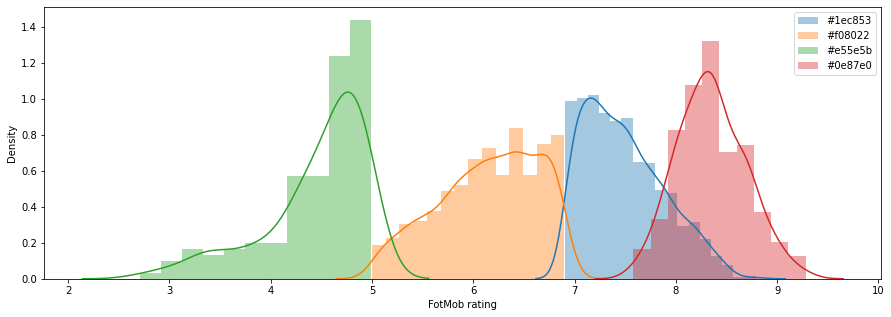

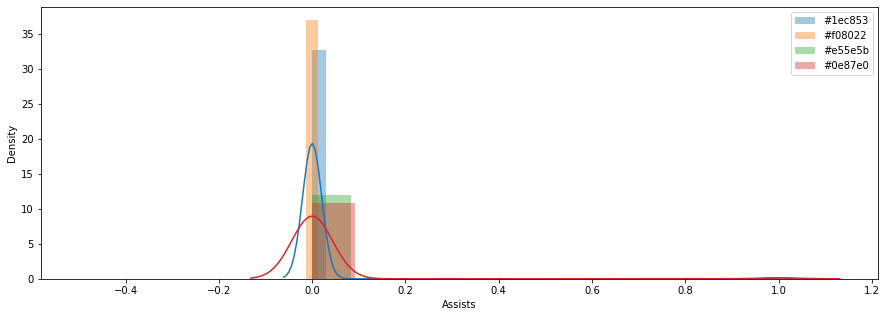

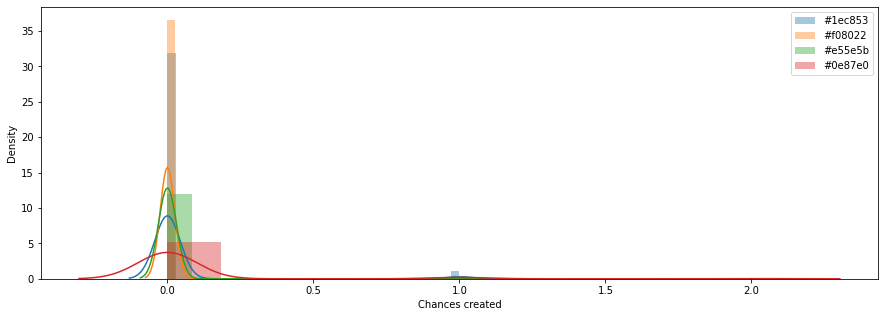

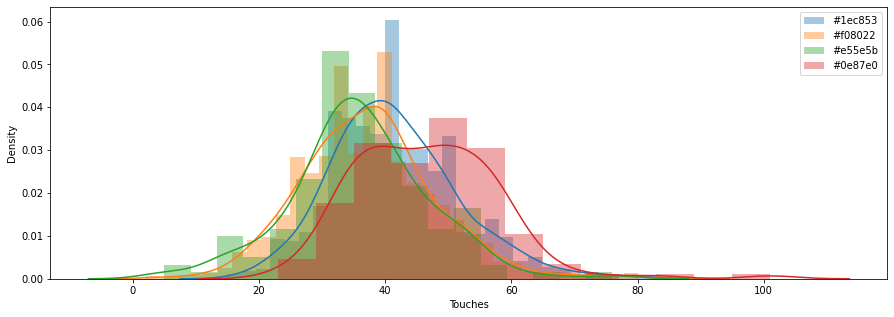

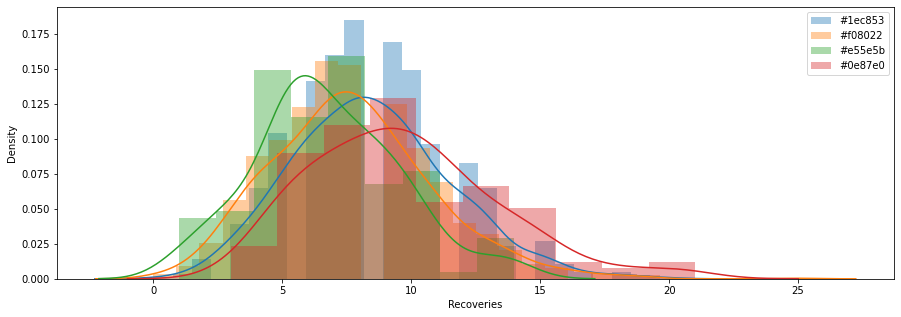

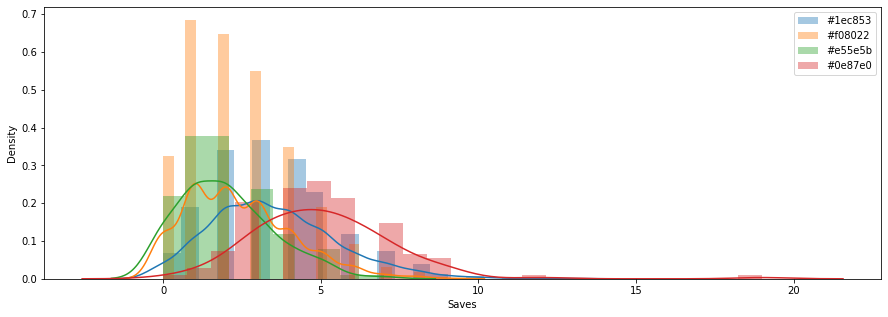

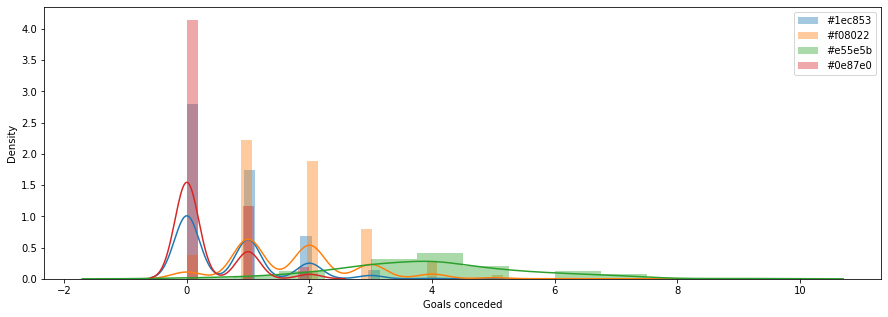

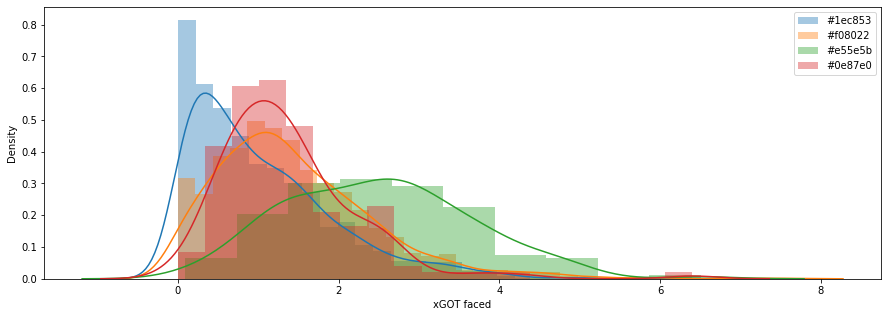

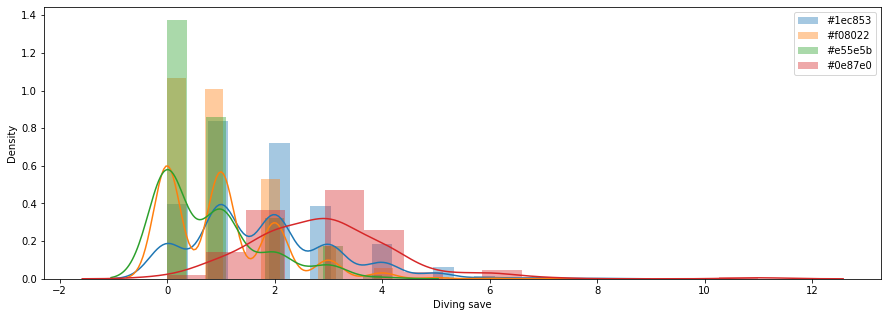

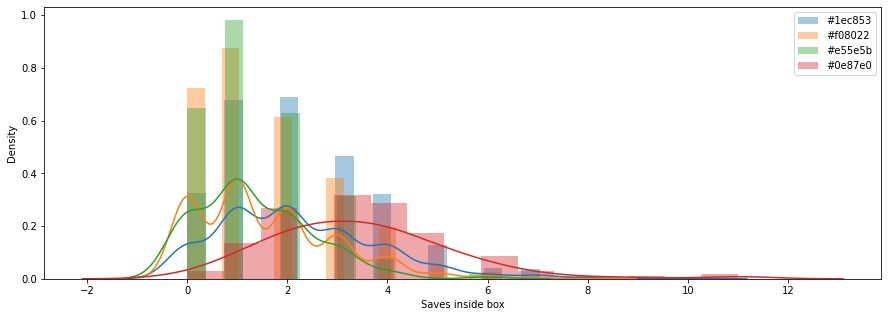

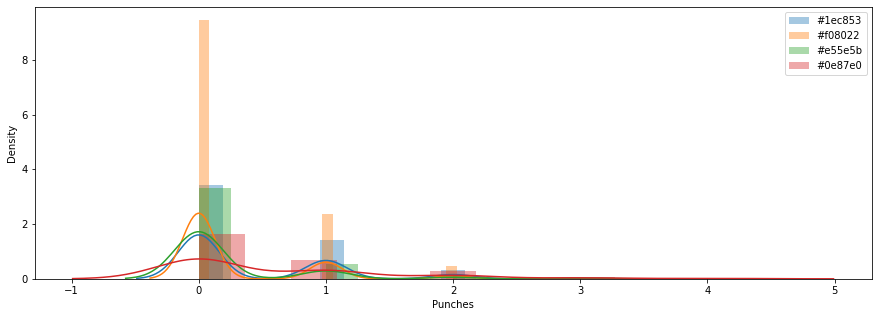

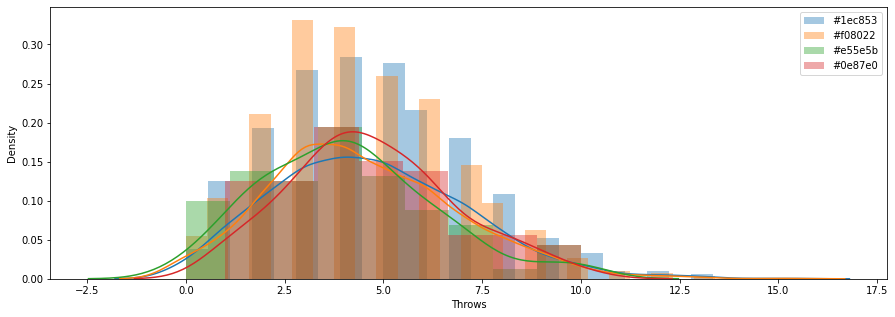

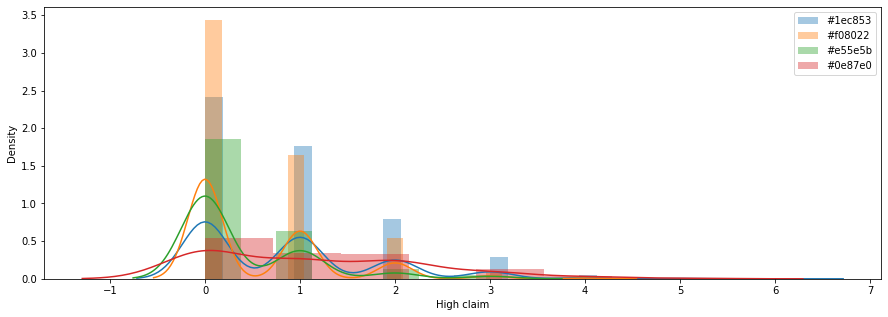

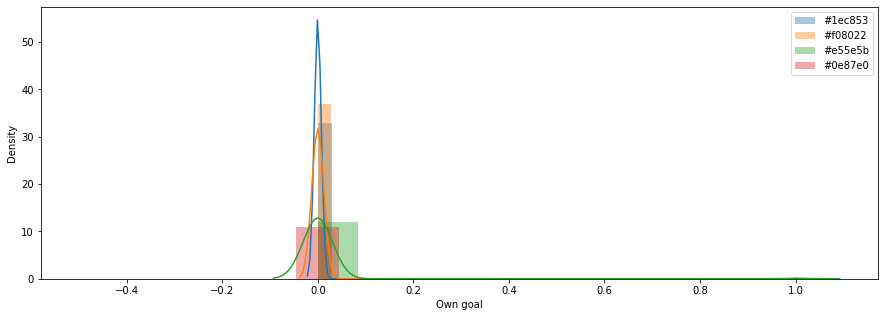

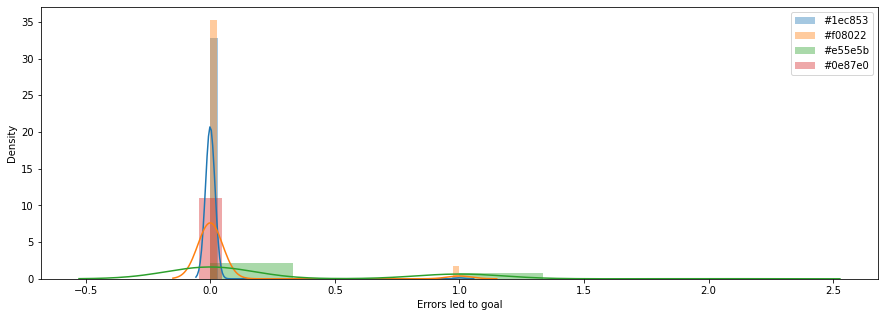

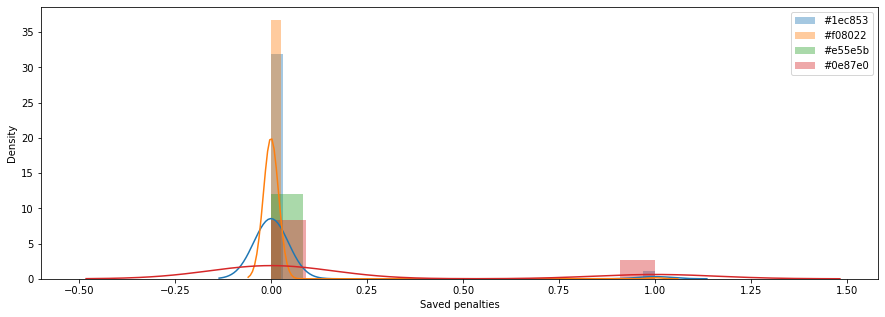

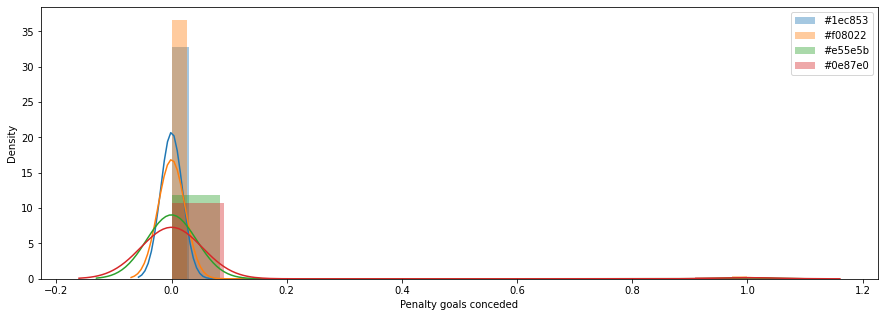

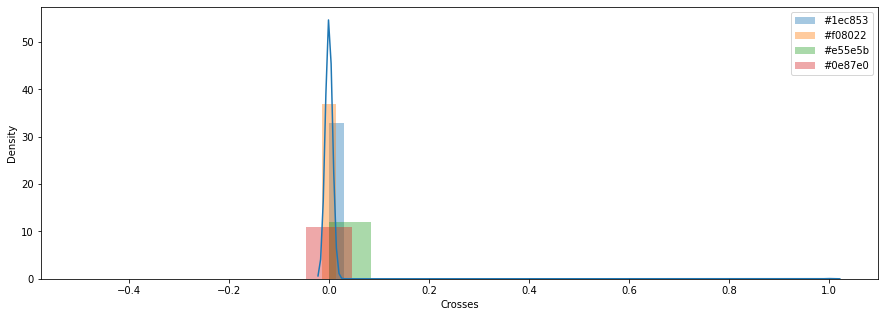

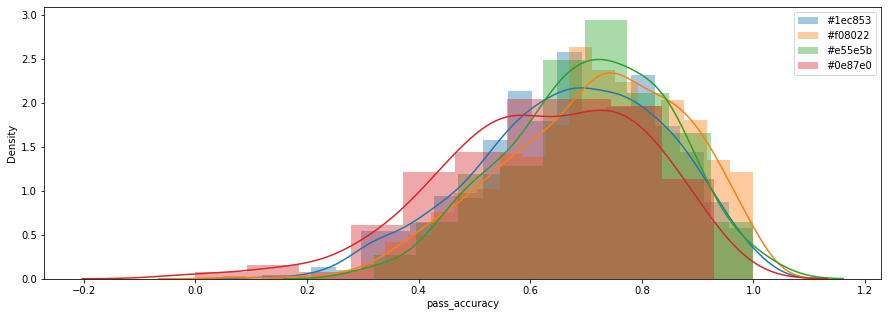

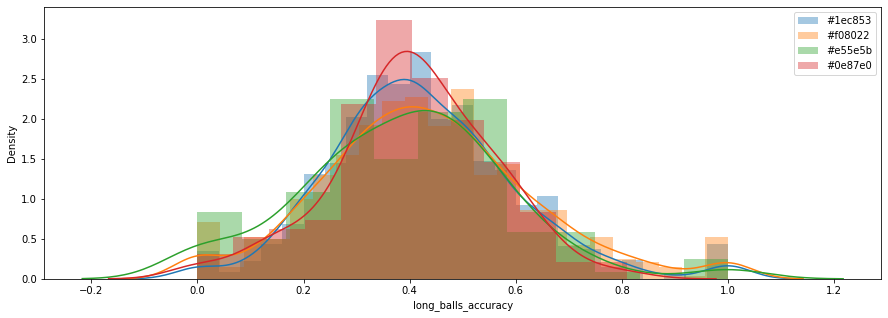

<Figure size 1080x360 with 0 Axes>

In [67]:
for column in keeper.columns:
   plt.figure(figsize=(15,5))
   if column != "bgcolor":
      for color in keeper.bgcolor.unique():
          sns.distplot(keeper.query(f"bgcolor == '{color}'")[column], label=color)
          plt.legend()

In [68]:
keeper_df = pd.merge(pd.concat([events_df, numerical_df, categorical_df], axis=1),keeper, how="inner", right_index=True, left_index=True)

In [69]:
keeper_df = keeper_df.drop(["bgcolor_y", "FotMob rating", "bgcolor_x", "role", "team_score", "opponent_score", "isSubbedOff", "yc"], axis=1)
keeper_df = keeper_df.loc[:,~keeper_df.columns.duplicated()]

In [70]:
result_to_num = {"Win":2, "Draw":1, "Lose":0}
keeper_df["result"] = keeper_df["result"].map(result_to_num)
keeper_df["Saving_accuracy"] = keeper_df["Saves"] / (keeper_df["Saves"] + keeper_df["Goals conceded"])

<Axes: >

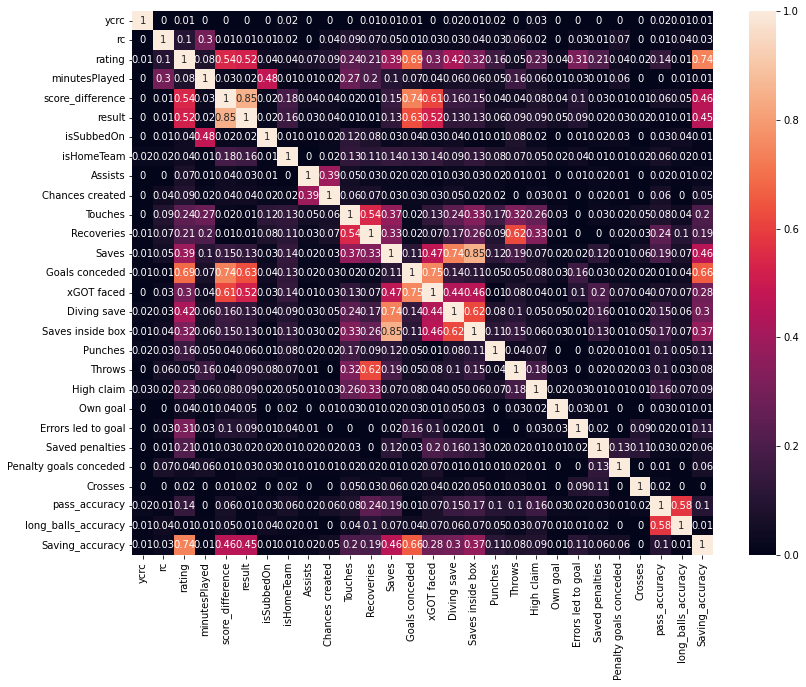

In [71]:
plt.figure(figsize=(13,10))
corr_m = keeper_df.corr().abs().round(2)
sns.heatmap(corr_m, annot=True)

<Axes: >

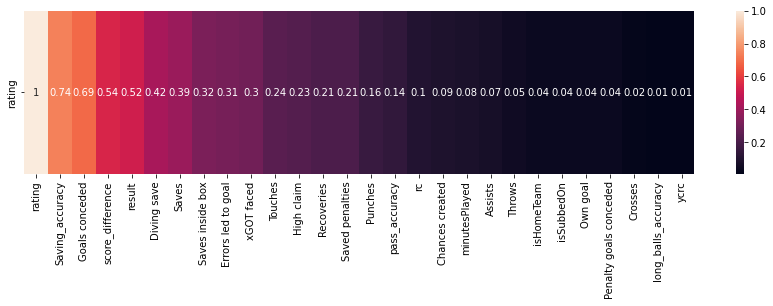

In [72]:
plt.figure(figsize=(15,3))
sns.heatmap(corr_m.loc[:,['rating']].iloc[:,[0]].sort_values(by="rating", ascending=False).T, annot=True)

### Defender
### Most correlated :
['rc','minutesPlayed', 'score_difference',
       'isSubbedOn', 'Goals', 'Assists', 'Total shots', 'Chances created',
       'Touches', 'Passes into final third', 'Accurate crosses', 'Tackles won',
       'Ground duels won', 'Aerial duels won', 'Was fouled',
       'Successful dribbles', 'Clearances', 'Headed clearance', 'Recoveries',
       'Expected goals (xG)', 'Expected goals on target (xGOT)',
       'Shot accuracy', 'Expected assists (xA)', 'Interceptions',
       'Error led to goal', 'Own goal']

In [73]:
defender = sdf.query(f"role == 'Defender'")

In [74]:
means = defender.isna().mean()
c_todrop = means[means == 1.0].index.tolist()
defender = defender.drop(c_todrop, axis=1)
defender = defender.drop("role", axis=1)

In [75]:
defender.isna().mean()

FotMob rating                      0.000000
Goals                              0.000000
Assists                            0.000000
Total shots                        0.000000
Accurate passes                    0.000000
Chances created                    0.000000
Expected goals (xG)                0.641789
Expected assists (xA)              0.303796
Blocked shots                      0.897407
Touches                            0.000225
Accurate crosses                   0.576700
Dispossessed                       0.000000
Tackles won                        0.000000
Ground duels won                   0.000000
Aerial duels won                   0.000000
Was fouled                         0.000000
Fouls committed                    0.000000
Passes into final third            0.071251
Accurate long balls                0.086359
Interceptions                      0.409696
Recoveries                         0.045096
Conceded penalty                   0.979256
Successful dribbles             

In [76]:
defender.sample(10)

FotMob rating  Goals  Assists  Total shots Accurate passes  \
2561            6.19    0.0      0.0          0.0    18/18 (100%)   
57512           7.07    0.0      0.0          0.0     23/35 (66%)   
58315           6.18    0.0      0.0          0.0       4/9 (44%)   
10994           5.70    0.0      0.0          0.0     56/58 (97%)   
5262            7.01    0.0      0.0          0.0     51/58 (88%)   
20735           7.65    0.0      0.0          0.0     82/89 (92%)   
44501           6.48    0.0      0.0          0.0      6/10 (60%)   
45154           7.34    0.0      0.0          0.0     64/69 (93%)   
18502           7.22    0.0      0.0          0.0     38/44 (86%)   
46106           6.64    0.0      0.0          1.0     71/82 (87%)   

       Chances created Expected goals (xG) Expected assists (xA)  \
2561               0.0                 NaN                   NaN   
57512              0.0                 NaN                  0.01   
58315              0.0                 NaN                  0.01   
10994              0.0                 NaN                  0.09   
5262               0.0                 NaN                  0.01   
20735              0.0                 NaN                   NaN   
44501              0.0                 NaN                   NaN   
45154              1.0                 NaN                  0.07   
18502              0.0                 NaN                   NaN   
46106              2.0                0.05                  0.12   

       Blocked shots  Touches Accurate crosses  Dispossessed Tackles won  \
2561             NaN     27.0              NaN           0.0  2/2 (100%)   
57512            NaN     39.0              NaN           0.0           0   
58315            NaN     17.0              NaN           0.0  1/1 (100%)   
10994            NaN     74.0              NaN           2.0   2/4 (50%)   
5262             NaN     66.0              NaN           0.0  2/2 (100%)   
20735            NaN     99.0              NaN           0.0   1/2 (50%)   
44501            NaN     18.0              NaN           0.0  1/1 (100%)   
45154            NaN     73.0              NaN           0.0           0   
18502            NaN     59.0              NaN           1.0  1/1 (100%)   
46106            NaN     98.0       2/2 (100%)           2.0   1/2 (50%)   

      Ground duels won Aerial duels won  Was fouled  Fouls committed  \
2561         2/5 (40%)         0/1 (0%)         0.0              2.0   
57512        1/3 (33%)        5/6 (83%)         1.0              0.0   
58315        1/4 (25%)                0         0.0              1.0   
10994       5/10 (50%)                0         1.0              2.0   
5262        2/2 (100%)       2/2 (100%)         0.0              1.0   
20735       4/4 (100%)       4/4 (100%)         1.0              1.0   
44501        1/2 (50%)                0         0.0              0.0   
45154                0        1/2 (50%)         0.0              0.0   
18502        2/6 (33%)         0/1 (0%)         1.0              2.0   
46106        2/5 (40%)        3/4 (75%)         0.0              1.0   

       Passes into final third Accurate long balls  Interceptions  Recoveries  \
2561                       NaN          5/5 (100%)            1.0         1.0   
57512                      6.0           3/7 (43%)            NaN         9.0   
58315                      NaN          1/1 (100%)            NaN         2.0   
10994                      5.0           1/2 (50%)            NaN         5.0   
5262                       8.0           2/5 (40%)            1.0         5.0   
20735                      2.0           4/8 (50%)            NaN        12.0   
44501                      4.0            0/1 (0%)            NaN         2.0   
45154                      4.0           6/8 (75%)            1.0         6.0   
18502                      4.0           2/4 (50%)            2.0         7.0   
46106                      8.0           4/8 (50%)        

In [77]:
defender = defender.fillna(0)

In [78]:
defender["pass_accuracy"] = (defender["Accurate passes"].str.extract("\((?P<pass_accuracy>\d+)%").astype(float)/100).fillna(0)
defender["long_balls_accuracy"] = (defender["Accurate long balls"].str.extract("\((?P<long_balls_accuracy>\d+)%").astype(float)/100).fillna(0)
defender["Ground duels won"] = (defender["Ground duels won"].str.extract("\((?P<Ground_duels_won>\d+)%").astype(float)/100).fillna(0)


In [79]:
defender = defender.drop(["Accurate long balls", "Accurate passes"], axis=1)

In [80]:
defender["Accurate crosses"] = defender["Accurate crosses"].str.extract("(?P<Accurate_crosses>\d+)").fillna(0)
defender["Tackles won"] = defender["Tackles won"].str.extract("(?P<Tackles_won>\d+)").fillna(0)
defender["Aerial duels won"] = defender["Aerial duels won"].str.extract("(?P<Aerial_duels_won>\d+)").fillna(0)
defender["Successful dribbles"] = defender["Successful dribbles"].str.extract("(?P<Successful_dribbles>\d+)").fillna(0)


In [81]:
defender["Shot accuracy"] = defender["Shot accuracy"].str.extract("(?P<shots_acc>\d+)").fillna(0)

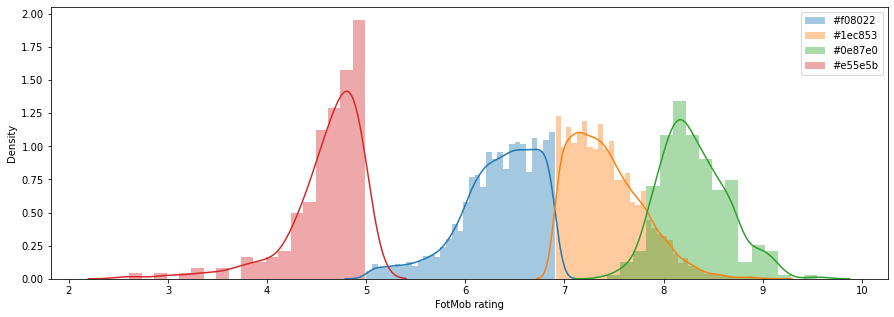

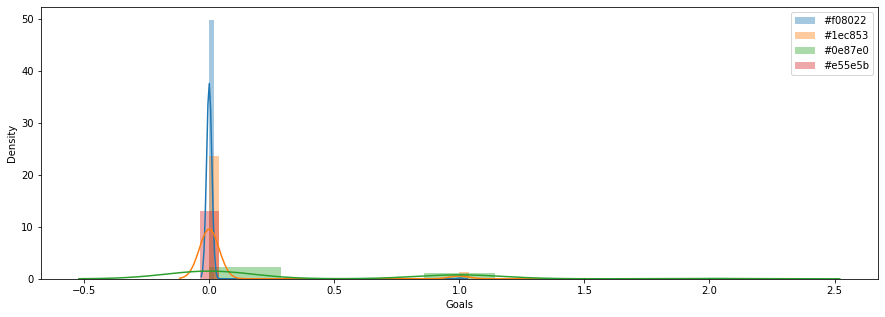

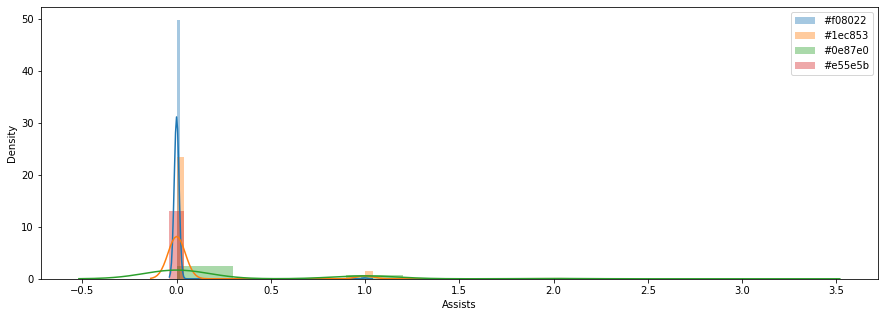

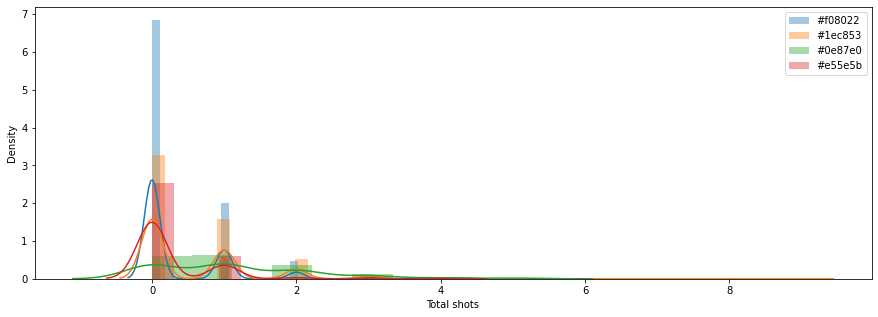

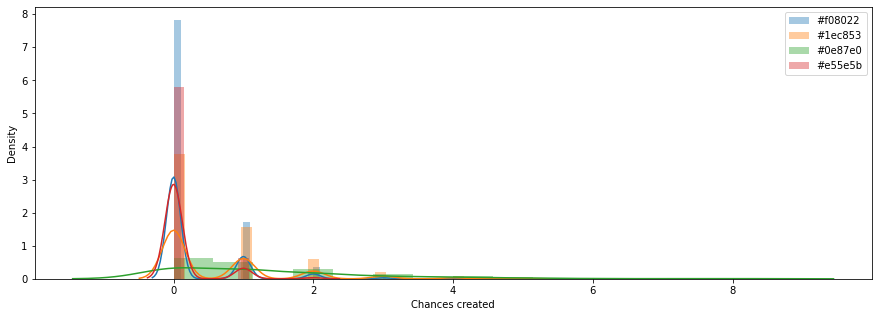

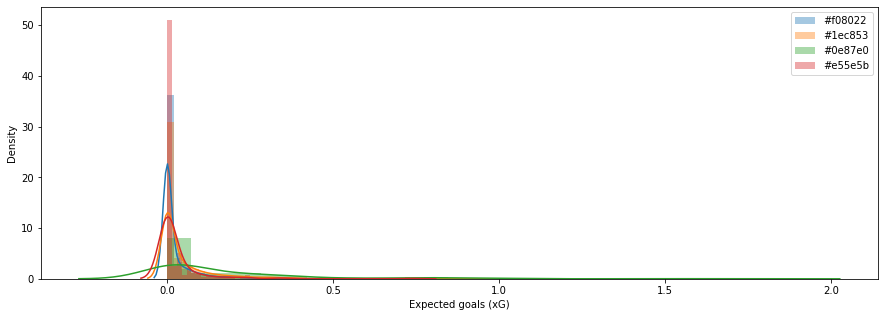

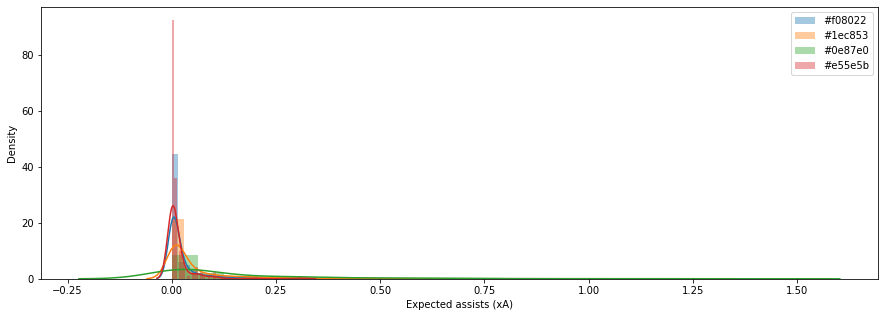

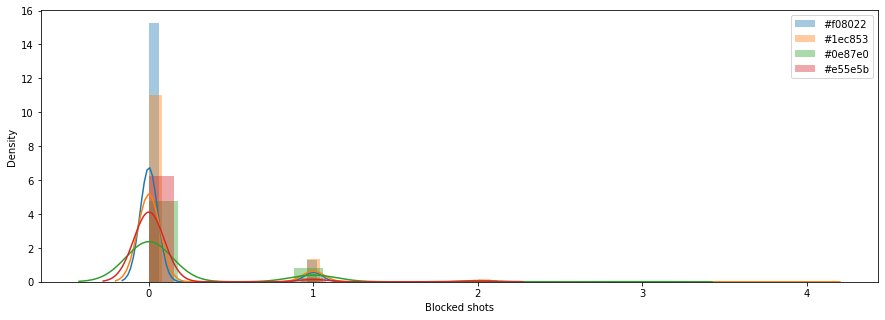

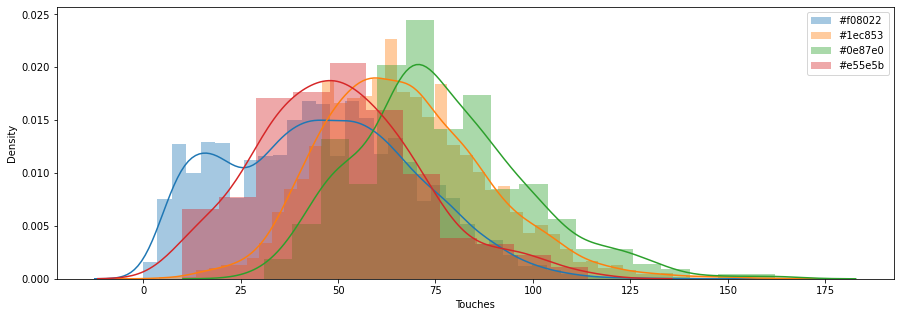

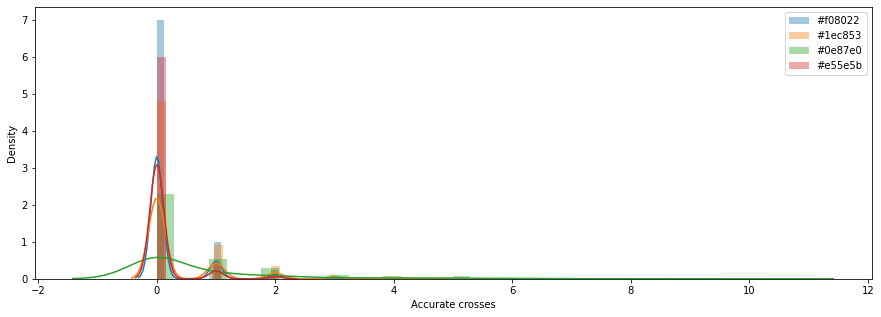

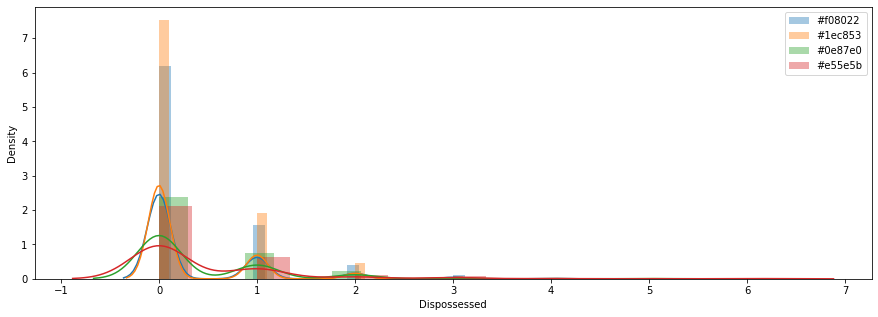

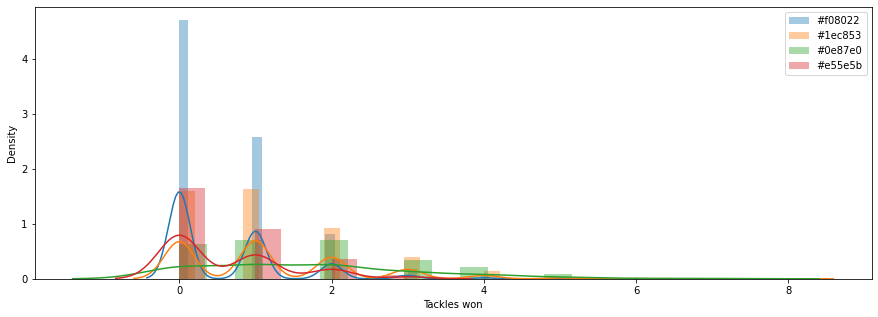

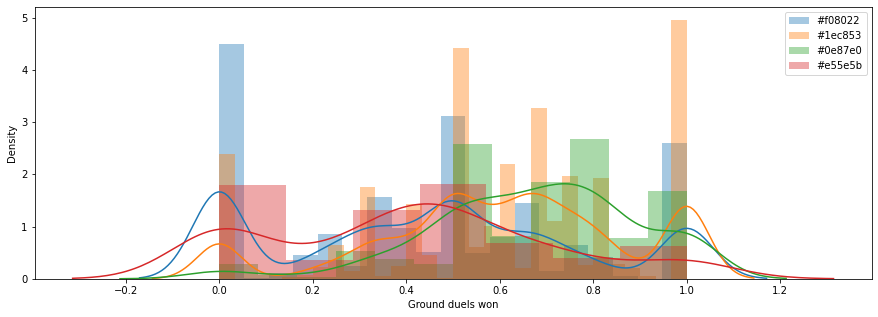

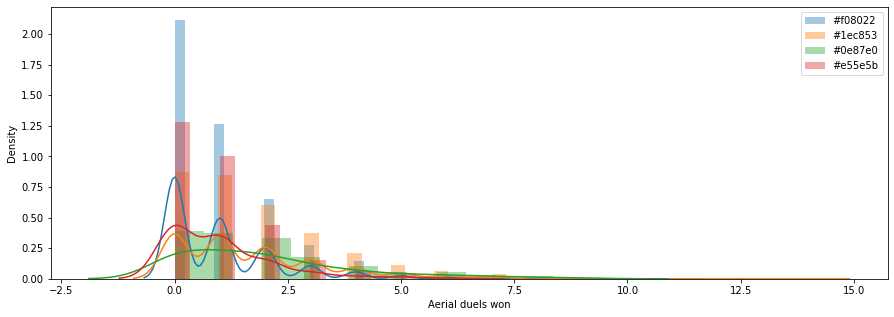

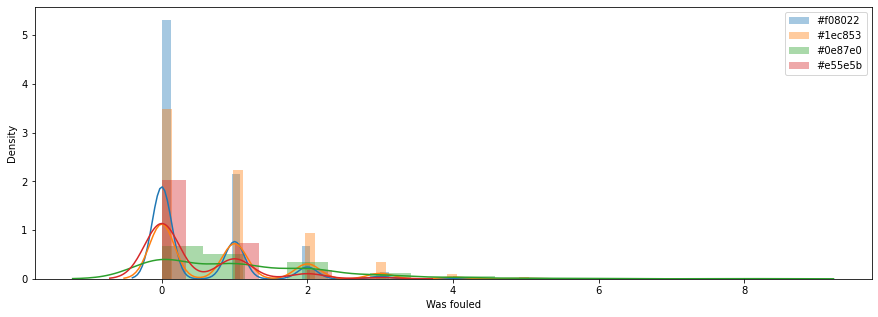

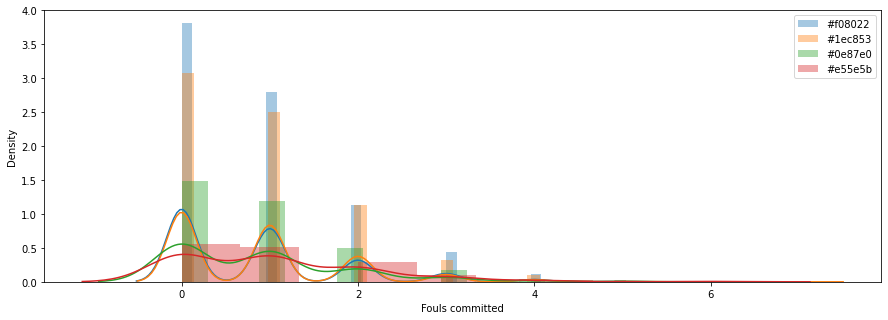

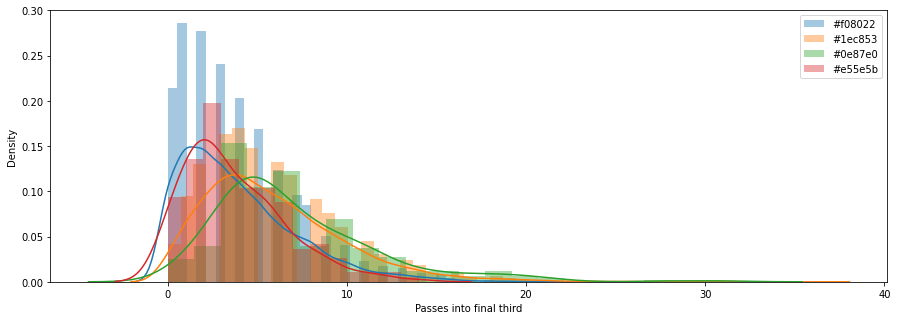

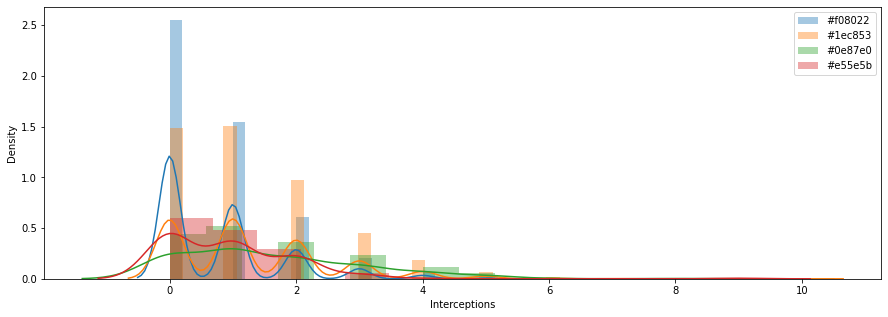

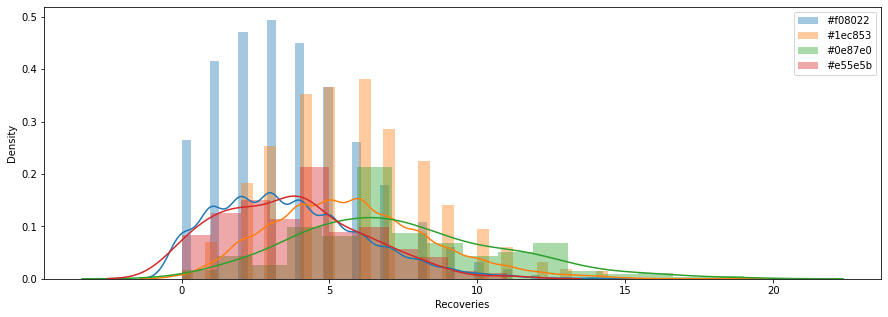

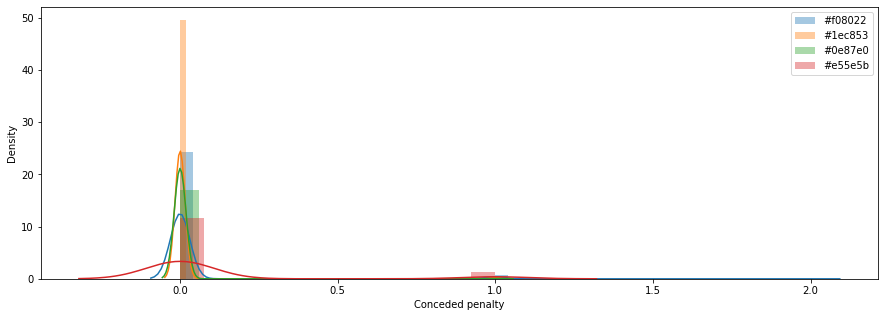

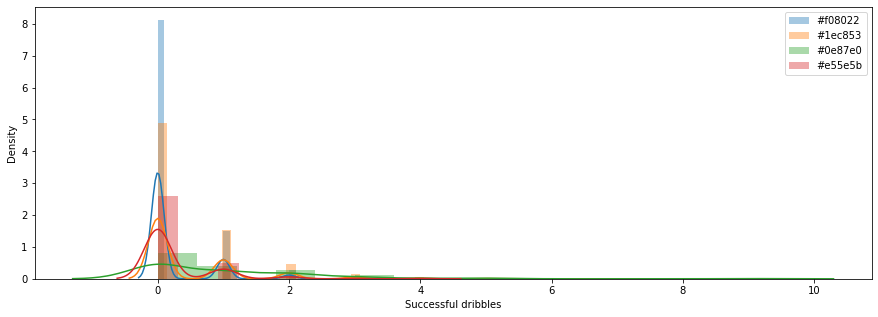

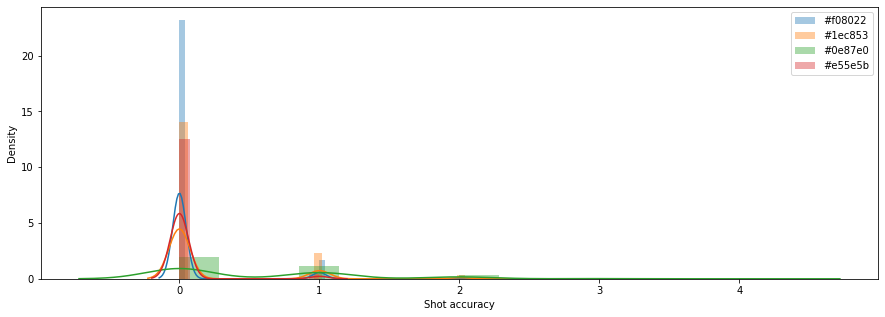

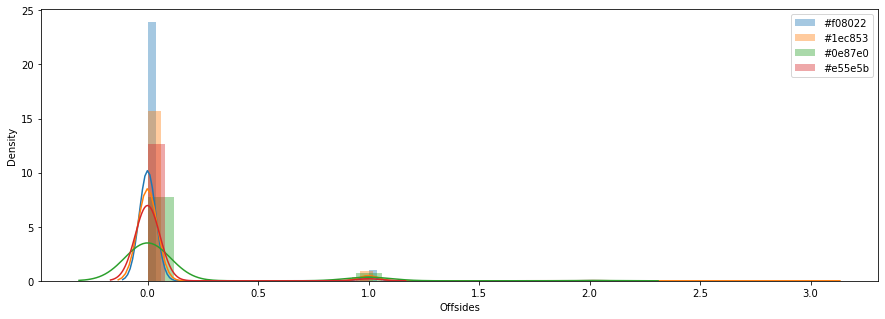

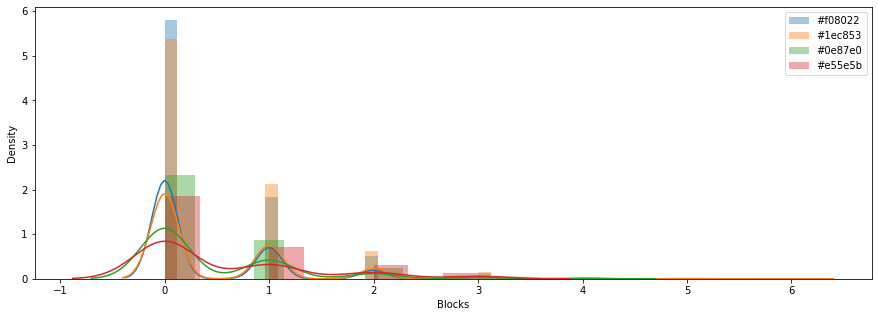

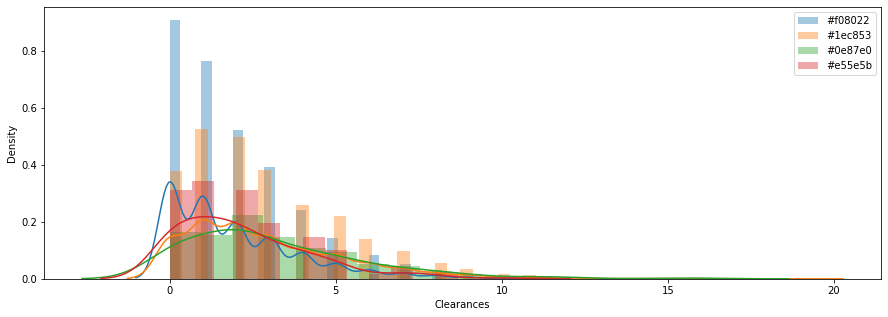

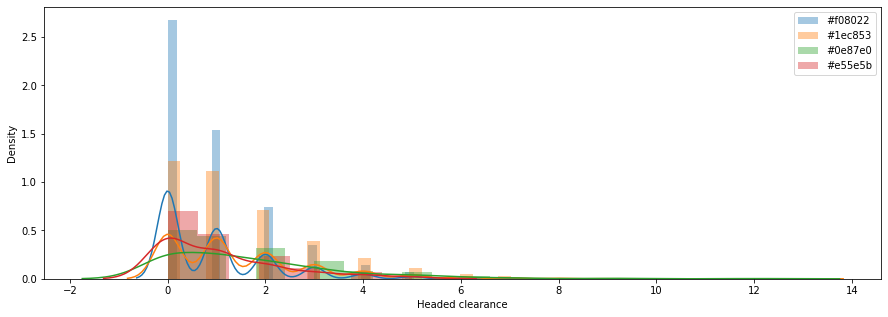

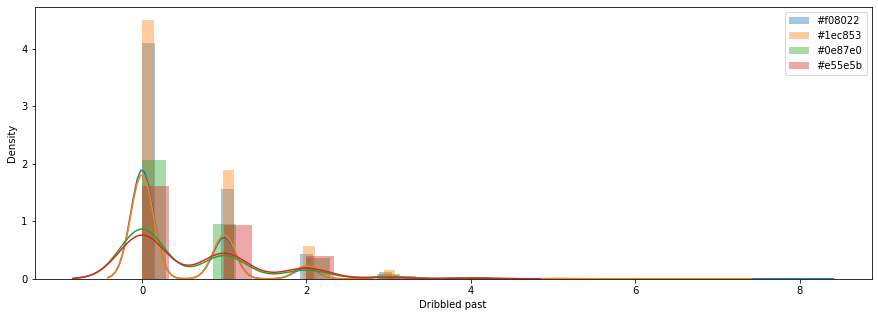

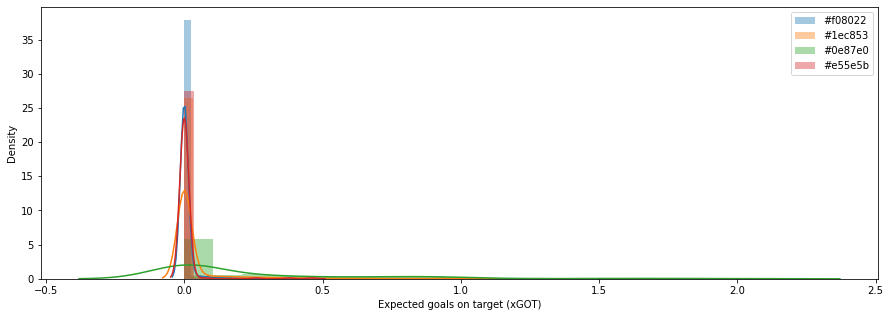

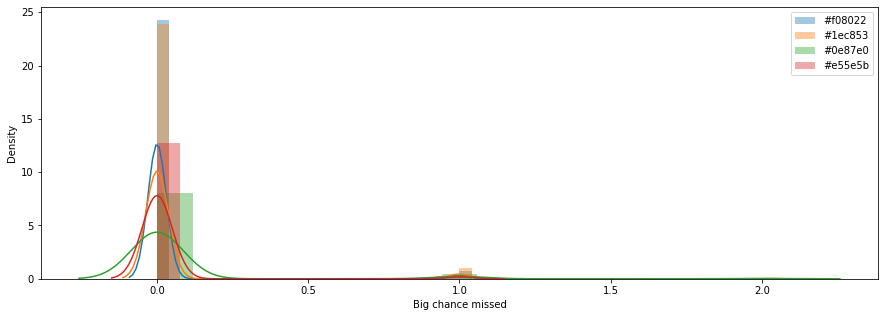

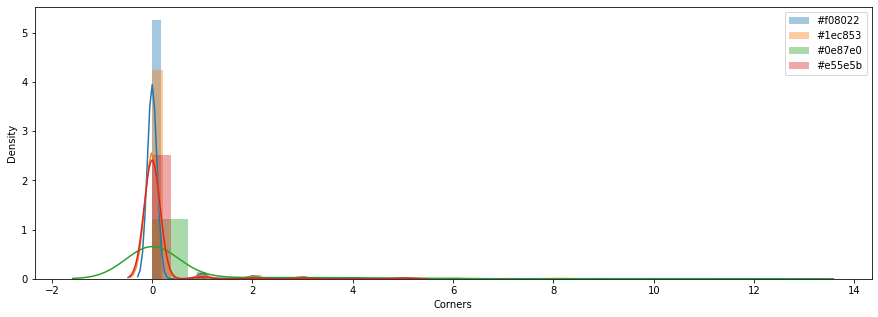

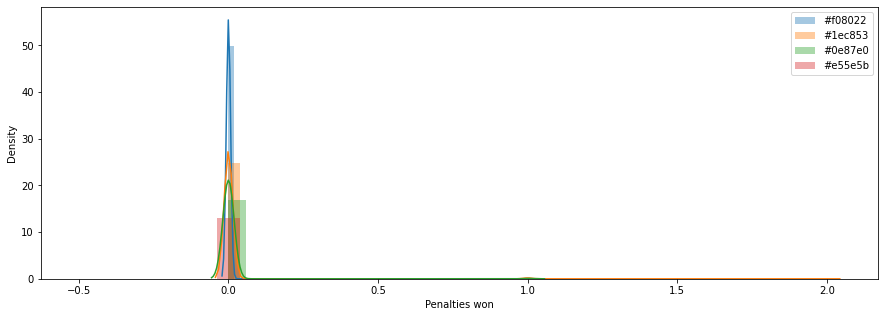

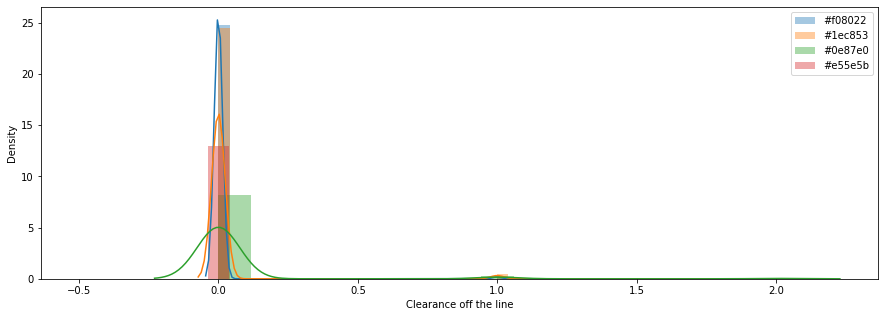

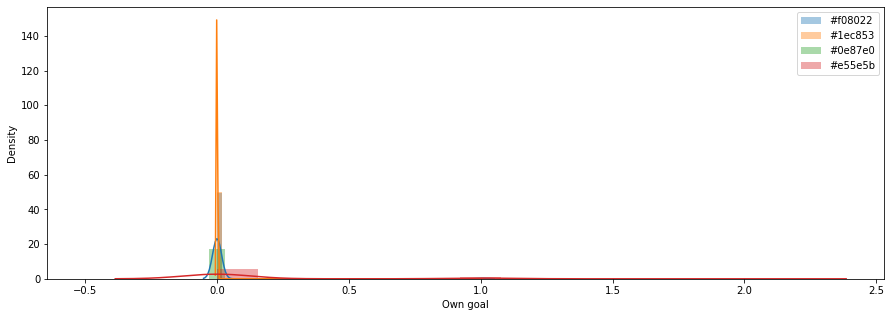

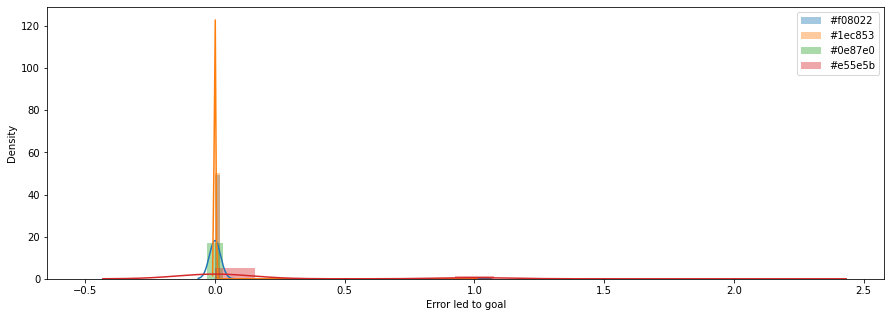

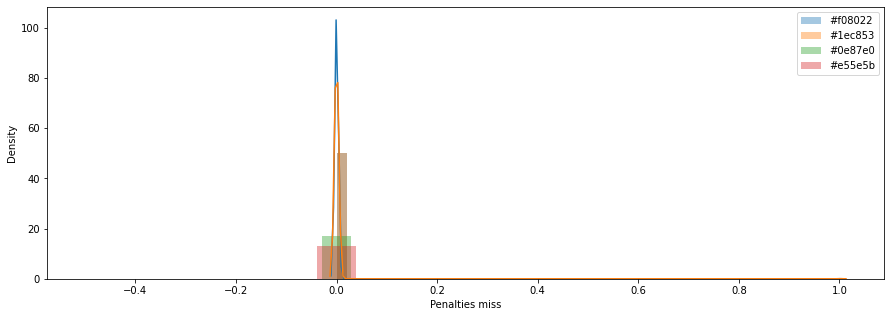

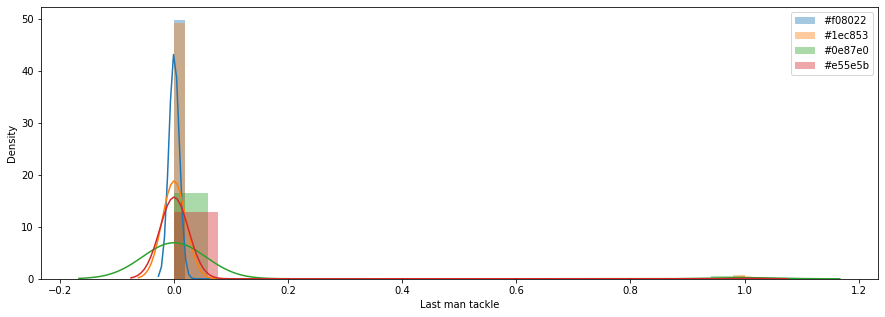

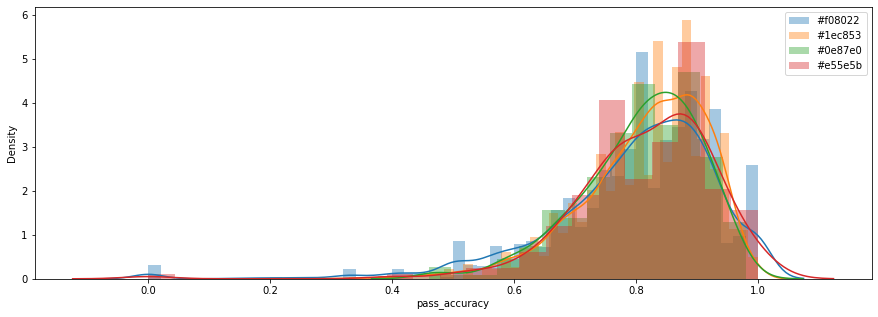

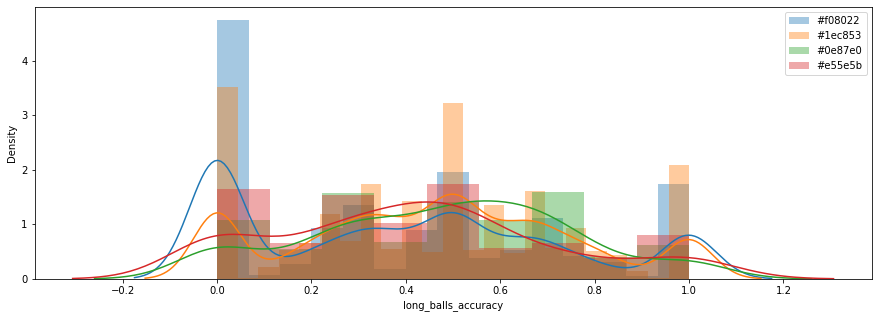

In [82]:
for column in defender.columns:
   plt.figure(figsize=(15,5))
   for color in rating.bgcolor.unique():
        sns.distplot(defender[rating.bgcolor == color][column], label=color)
        plt.legend()

In [83]:
defender_df = pd.merge(pd.concat([events_df, numerical_df, categorical_df], axis=1),defender, how="inner", right_index=True, left_index=True)

In [84]:
defender_df = defender_df.drop(["bgcolor", "FotMob rating", "role", "team_score", "opponent_score", "isSubbedOff", "yc"], axis=1)
defender_df = defender_df.loc[:,~defender_df.columns.duplicated()]

In [85]:
result_to_num = {"Win":2, "Draw":1, "Lose":0}
defender_df["result"] = defender_df["result"].map(result_to_num)

In [86]:
defender_df = defender_df.astype(float)

<Axes: >

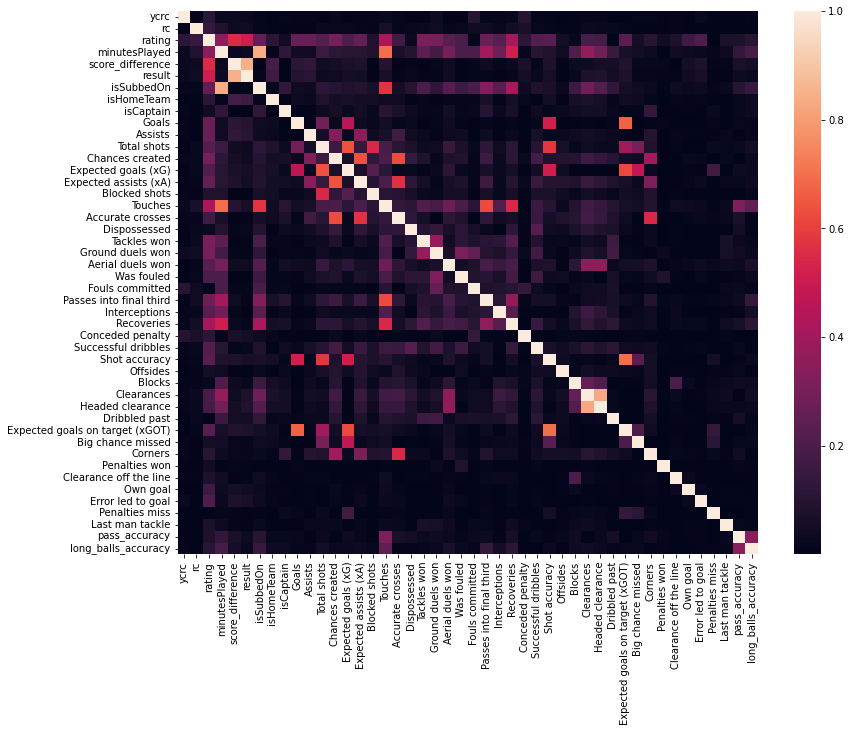

In [87]:
plt.figure(figsize=(13,10))
corr_m = defender_df.corr().abs()
sns.heatmap(corr_m)

<Axes: >

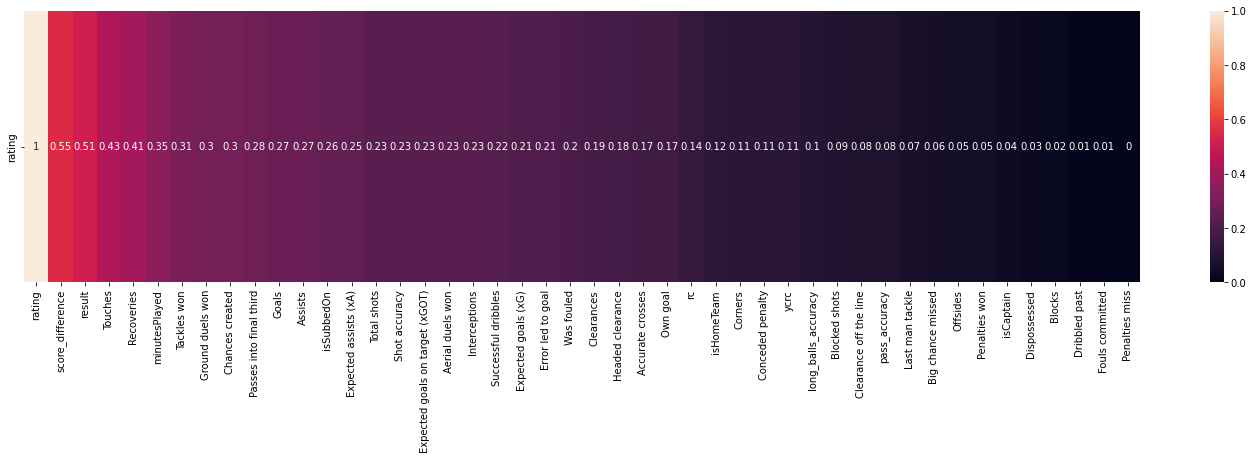

In [88]:
plt.figure(figsize=(25,5))
rating_corr = corr_m.round(2).loc[:,['rating']].sort_values(by="rating", ascending=False).T
sns.heatmap(rating_corr, annot=True)

<Axes: >

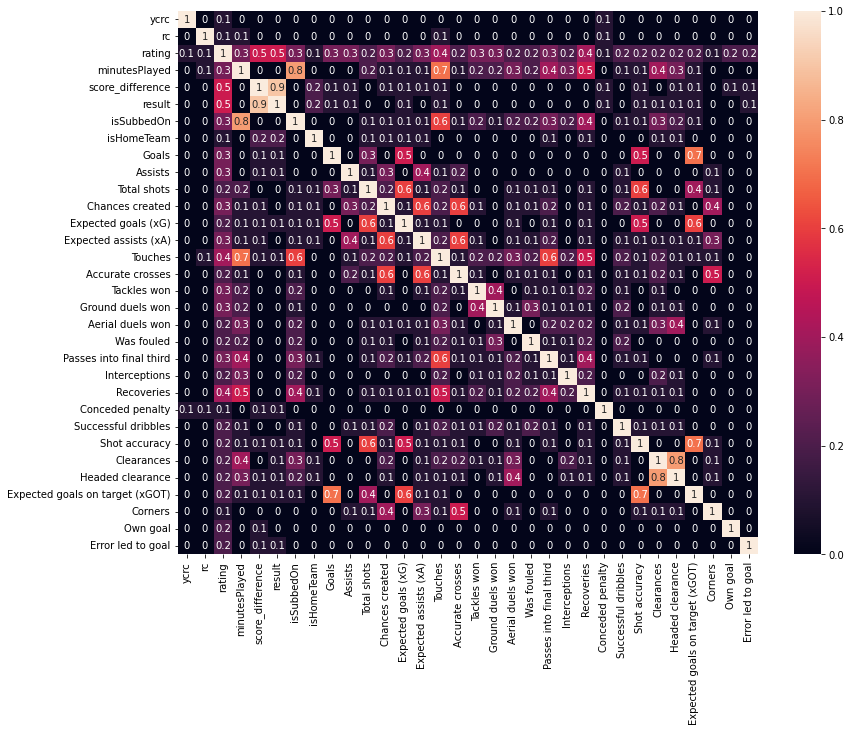

In [89]:
plt.figure(figsize=(13,10))
corr_m = defender_df.loc[:,(rating_corr.gt(0.1).any())].corr().abs().round(1)
sns.heatmap(corr_m, annot=True)

In [90]:
new_columns = defender_df.loc[:,(rating_corr.gt(0.08).any())].columns
new_columns

Index(['ycrc', 'rc', 'rating', 'minutesPlayed', 'score_difference', 'result',
       'isSubbedOn', 'isHomeTeam', 'Goals', 'Assists', 'Total shots',
       'Chances created', 'Expected goals (xG)', 'Expected assists (xA)',
       'Blocked shots', 'Touches', 'Accurate crosses', 'Tackles won',
       'Ground duels won', 'Aerial duels won', 'Was fouled',
       'Passes into final third', 'Interceptions', 'Recoveries',
       'Conceded penalty', 'Successful dribbles', 'Shot accuracy',
       'Clearances', 'Headed clearance', 'Expected goals on target (xGOT)',
       'Corners', 'Own goal', 'Error led to goal', 'long_balls_accuracy'],
      dtype='object')

### Midfielder
### Most correlated :
['rc', 'rating', 'minutesPlayed', 'score_difference', 'result',
       'isSubbedOn', 'isHomeTeam', 'isCaptain', 'Goals', 'Assists',
       'Total shots', 'Chances created', 'Touches', 'Passes into final third',
       'Accurate crosses', 'Tackles won', 'Dribbled past', 'Ground duels won',
       'Aerial duels won', 'Was fouled', 'Successful dribbles', 'Clearances',
       'Headed clearance', 'Recoveries', 'Expected goals (xG)',
       'Expected goals on target (xGOT)', 'Shot accuracy',
       'Expected assists (xA)', 'Blocks', 'Interceptions', 'Penalties won',
       'Blocked shots', 'Corners', 'Big chance missed', 'Error led to goal',
       'pass_accuracy']

In [91]:
midfielder = sdf.query(f"role == 'Midfielder'")

In [92]:
means = midfielder.isna().mean()
c_todrop = means[means == 1.0].index.tolist()
midfielder = midfielder.drop(c_todrop, axis=1)
midfielder = midfielder.drop("role", axis=1)

In [93]:
midfielder.isna().mean()

FotMob rating                      0.000000
Goals                              0.000000
Assists                            0.000000
Total shots                        0.000000
Accurate passes                    0.000000
Chances created                    0.000000
Expected goals (xG)                0.467554
Expected assists (xA)              0.158493
Blocked shots                      0.785511
Touches                            0.000150
Accurate crosses                   0.491926
Dispossessed                       0.000000
Tackles won                        0.000000
Ground duels won                   0.000000
Aerial duels won                   0.000000
Was fouled                         0.000000
Fouls committed                    0.000000
Passes into final third            0.107805
Accurate long balls                0.206115
Interceptions                      0.549267
Recoveries                         0.067135
Conceded penalty                   0.991776
Successful dribbles             

In [94]:
midfielder.sample(5)

FotMob rating  Goals  Assists  Total shots Accurate passes  \
2587            6.33    0.0      0.0          0.0       4/6 (67%)   
47434           9.17    0.0      2.0          2.0     38/45 (84%)   
51814           6.18    0.0      0.0          0.0      7/13 (54%)   
50959           6.88    0.0      0.0          1.0     15/21 (71%)   
15965           6.43    0.0      0.0          0.0     17/20 (85%)   

       Chances created Expected goals (xG) Expected assists (xA)  \
2587               0.0                 NaN                   NaN   
47434              6.0                0.07                  0.50   
51814              0.0                 NaN                   NaN   
50959              0.0                0.22                  0.03   
15965              0.0                 NaN                  0.01   

       Blocked shots  Touches Accurate crosses  Dispossessed Tackles won  \
2587             NaN     12.0              NaN           0.0           0   
47434            2.0     65.0        4/6 (67%)           0.0   1/2 (50%)   
51814            NaN     21.0              NaN           0.0           0   
50959            1.0     31.0              NaN           1.0  2/2 (100%)   
15965            NaN     25.0              NaN           0.0    0/1 (0%)   

      Ground duels won Aerial duels won  Was fouled  Fouls committed  \
2587         2/4 (50%)                0         1.0              0.0   
47434        7/8 (88%)                0         3.0              0.0   
51814        3/6 (50%)         0/1 (0%)         2.0              1.0   
50959        4/5 (80%)                0         2.0              0.0   
15965       1/1 (100%)                0         0.0              0.0   

       Passes into final third Accurate long balls  Interceptions  Recoveries  \
2587                       1.0                 NaN            NaN         3.0   
47434                      8.0            0/1 (0%)            1.0         5.0   
51814                      NaN                 NaN            NaN         NaN   
50959                      NaN                 NaN            NaN         5.0   
15965                      3.0           3/4 (75%)            1.0         3.0   

       Conceded penalty Successful dribbles Shot accuracy  Offsides  Blocks  \
2587                NaN          1/1 (100%)           NaN       NaN     NaN   
47434               NaN           2/3 (67%)           NaN       NaN     NaN   
51814               NaN           1/3 (33%)           NaN       NaN     NaN   
50959               NaN                 NaN           NaN       NaN     NaN   
15965               NaN                 NaN           NaN       NaN     NaN   

       Clearances  Headed clearance  Dribbled past  \
2587          NaN               NaN            2.0   
47434         NaN               NaN            NaN   
51814         NaN               NaN            NaN   
50959         1.0               NaN            NaN   
15965         1.0               NaN            NaN   

      Expected goals on target (xGOT)  Big chance missed  Corners  \
2587                              NaN                NaN      NaN   
47434                             NaN                NaN      5.0   
51814                             NaN                NaN      NaN   
50959                             NaN                1.0      NaN   
15965                             NaN                NaN      NaN   

       Penalties won  Clearance off the line  Own goal  Error led to goal  \
2587             NaN                     NaN       NaN                NaN   
47434            NaN                     NaN       NaN                NaN   
51814            NaN                     NaN       NaN                NaN   
50959            NaN                     NaN       NaN                NaN   
15965            NaN                     NaN       NaN                NaN   

       Penalties miss  Last man tackle  
2587              NaN              NaN  
47434             NaN              NaN  
51814

In [95]:
midfielder = midfielder.fillna(0)

In [96]:
midfielder["pass_accuracy"] = (midfielder["Accurate passes"].str.extract("\((?P<pass_accuracy>\d+)%").astype(float)/100).fillna(0)
midfielder["long_balls_accuracy"] = (midfielder["Accurate long balls"].str.extract("\((?P<long_balls_accuracy>\d+)%").astype(float)/100).fillna(0)
midfielder["Ground duels won"] = (midfielder["Ground duels won"].str.extract("\((?P<Ground_duels_won>\d+)%").astype(float)/100).fillna(0)


In [97]:
midfielder = midfielder.drop(["Accurate long balls", "Accurate passes"], axis=1)

In [98]:
midfielder["Accurate crosses"] = midfielder["Accurate crosses"].str.extract("(?P<Accurate_crosses>\d+)").fillna(0)
midfielder["Tackles won"] = midfielder["Tackles won"].str.extract("(?P<Tackles_won>\d+)").fillna(0)
midfielder["Aerial duels won"] = midfielder["Aerial duels won"].str.extract("(?P<Aerial_duels_won>\d+)").fillna(0)
midfielder["Successful dribbles"] = midfielder["Successful dribbles"].str.extract("(?P<Successful_dribbles>\d+)").fillna(0)


In [99]:
midfielder["Shot accuracy"] = midfielder["Shot accuracy"].str.extract("(?P<shots_acc>\d+)").fillna(0)

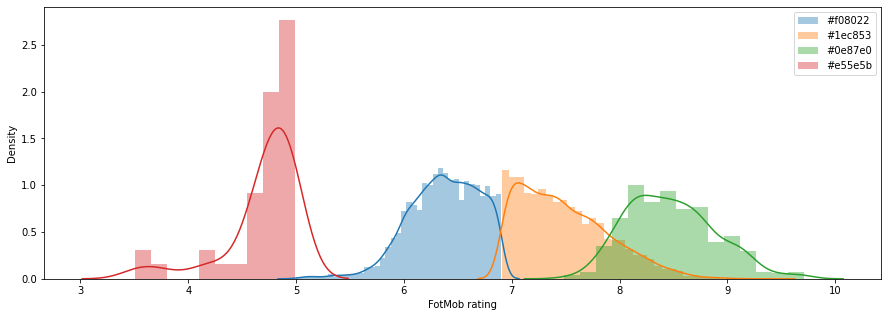

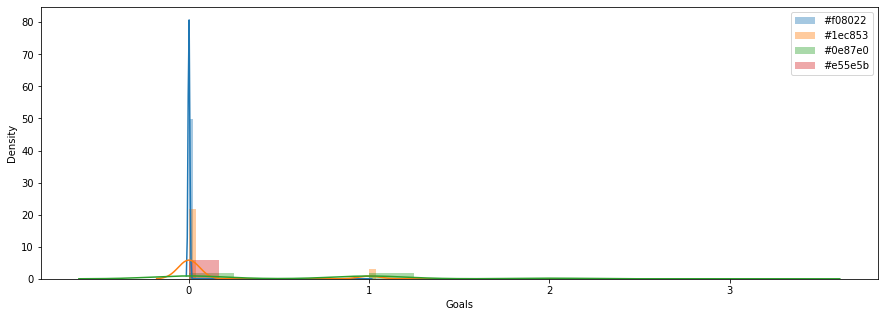

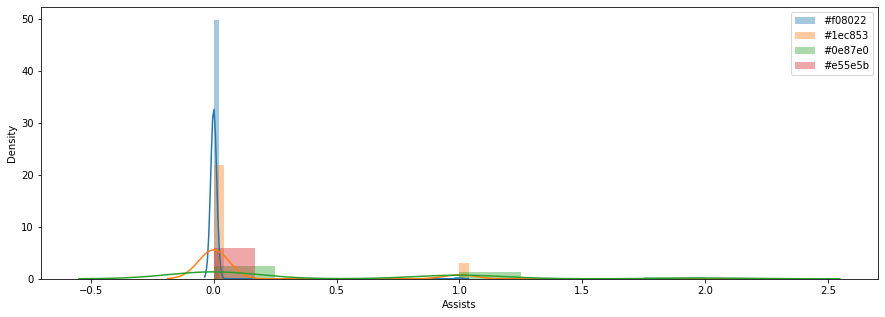

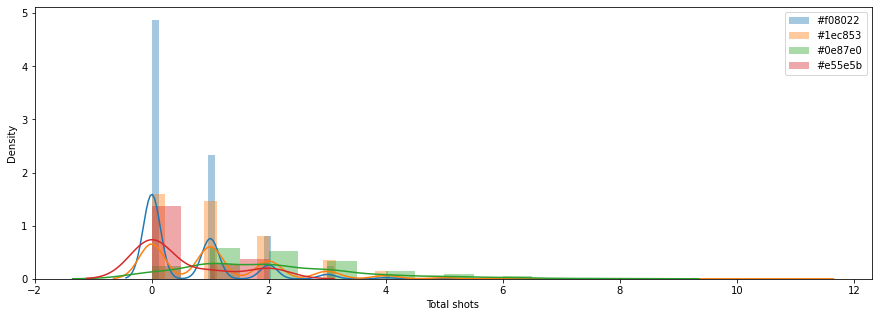

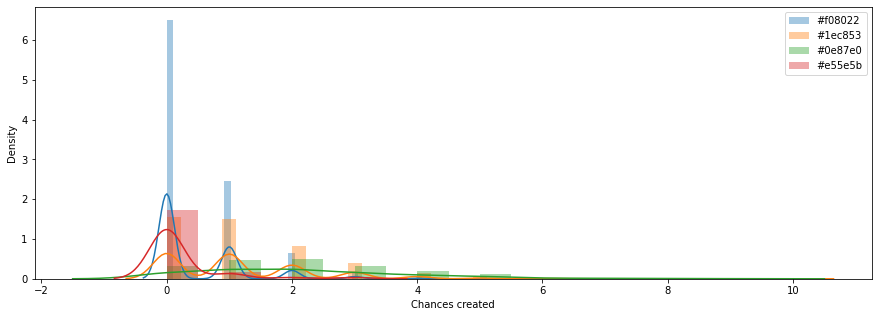

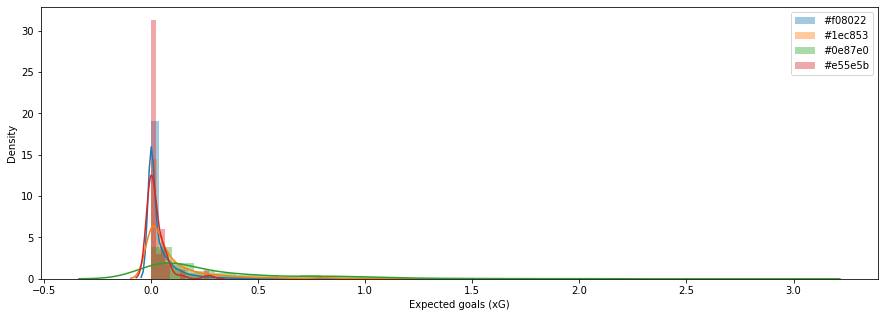

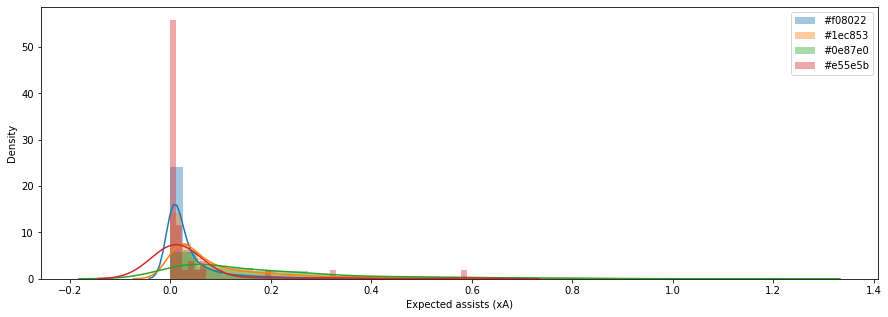

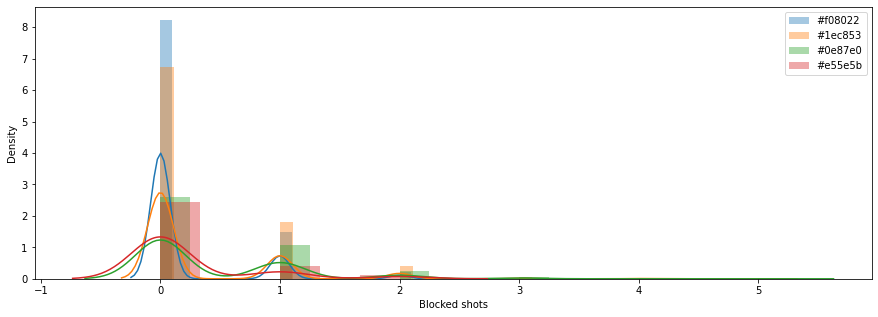

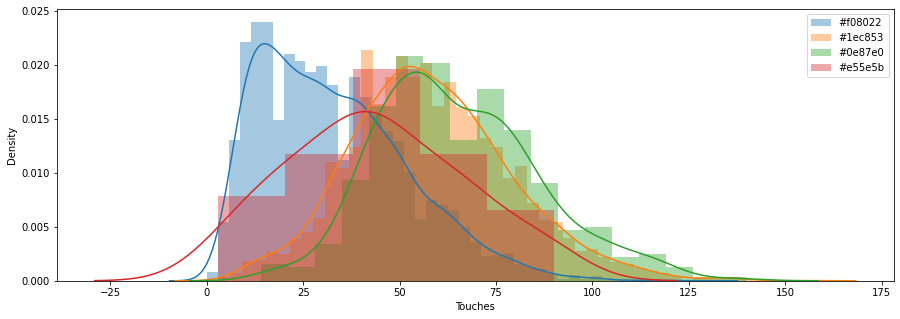

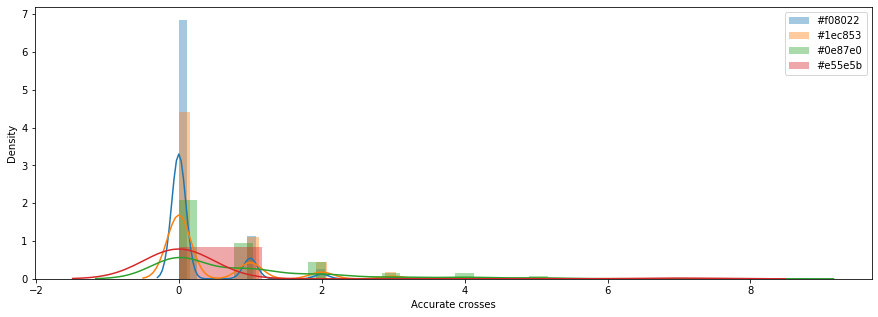

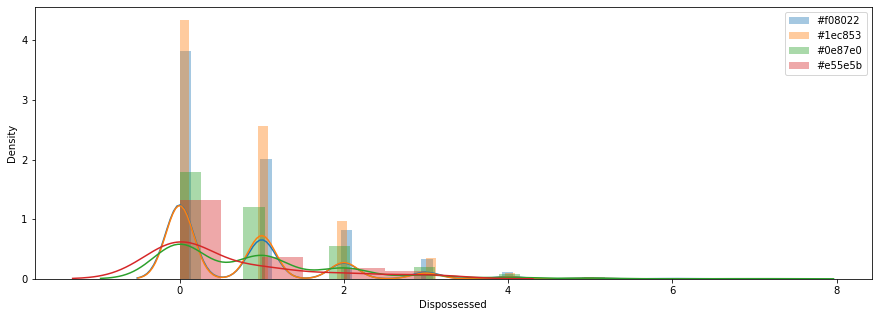

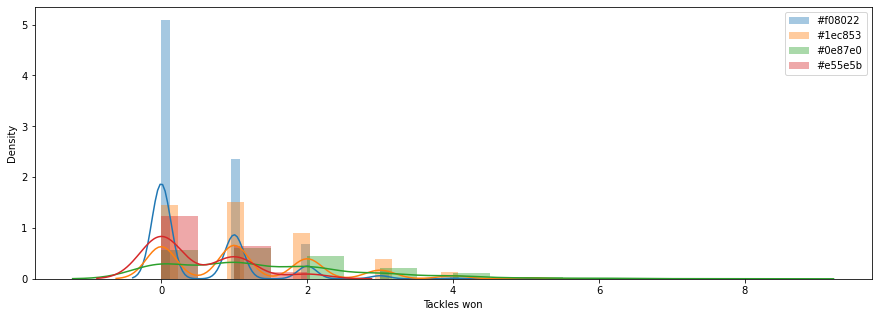

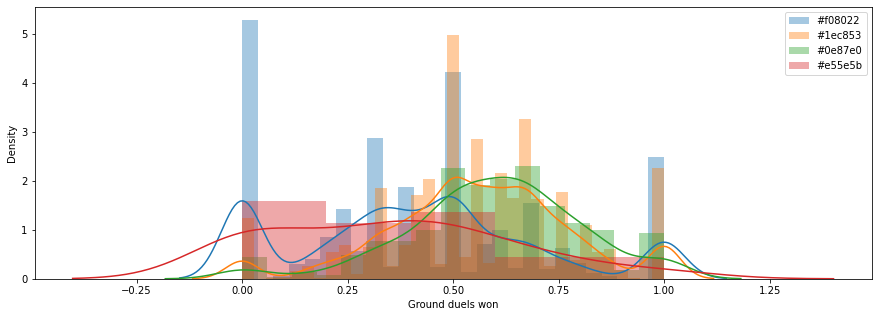

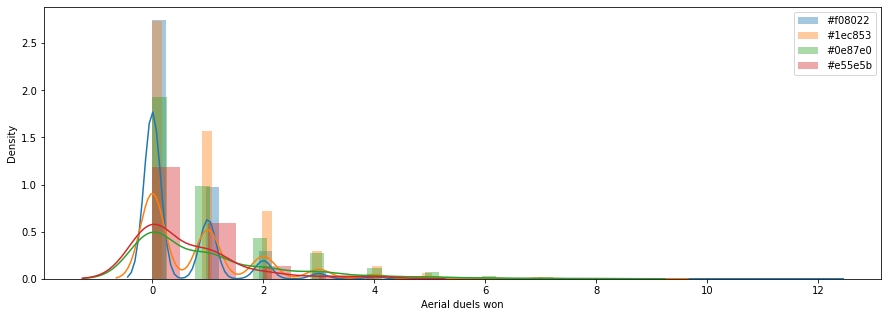

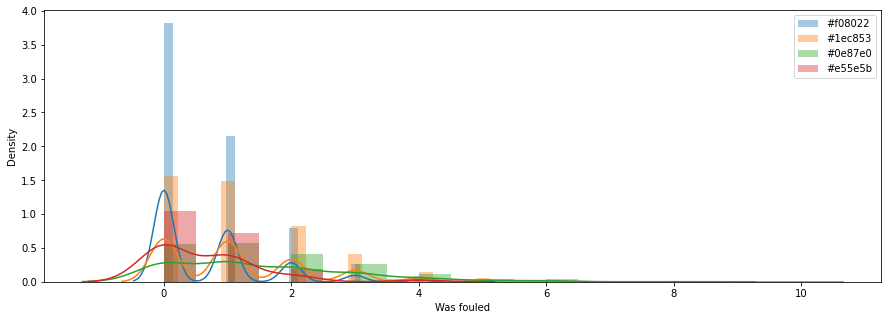

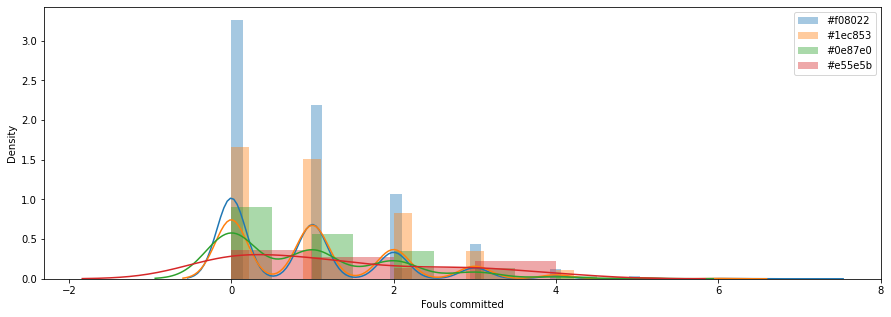

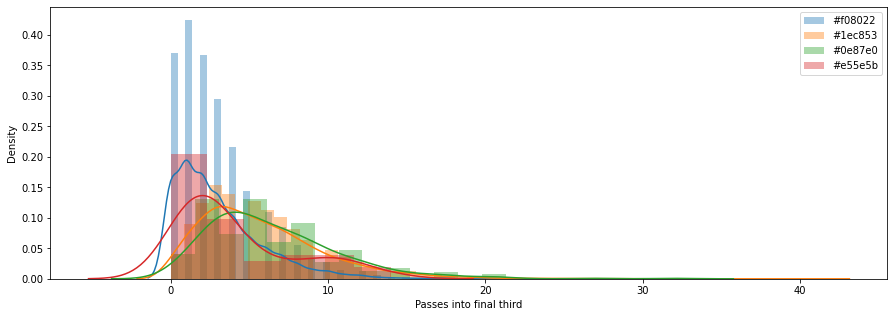

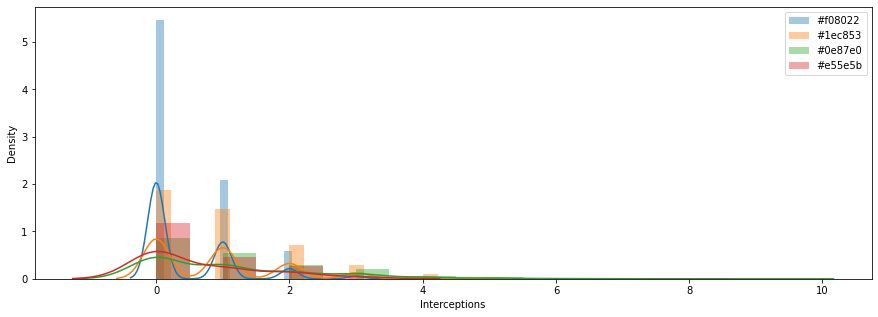

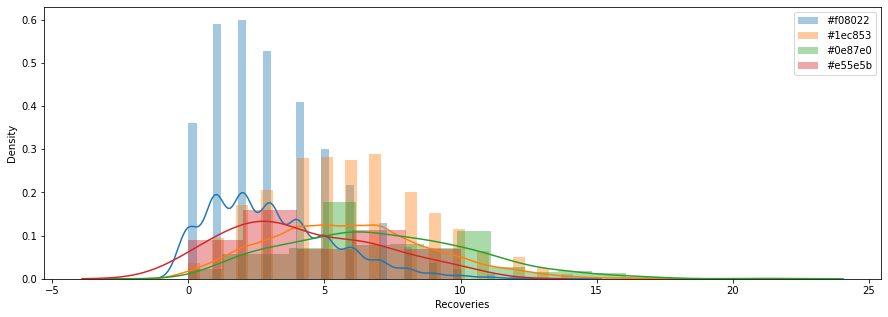

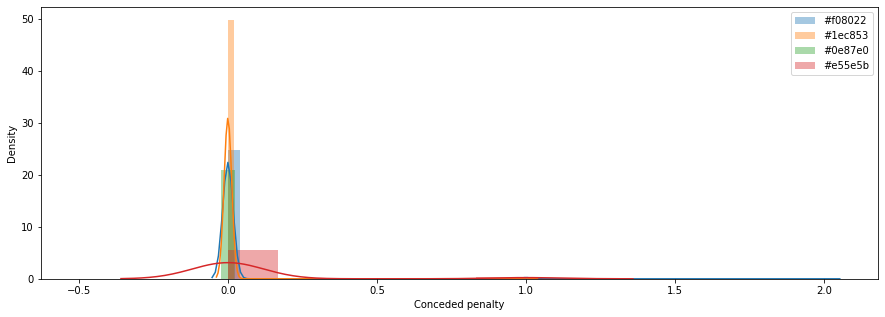

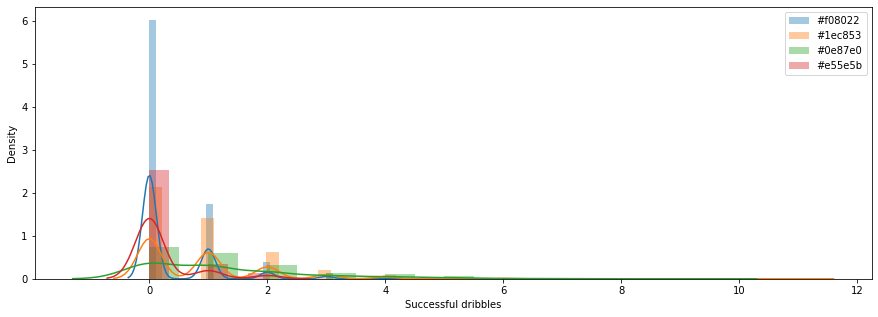

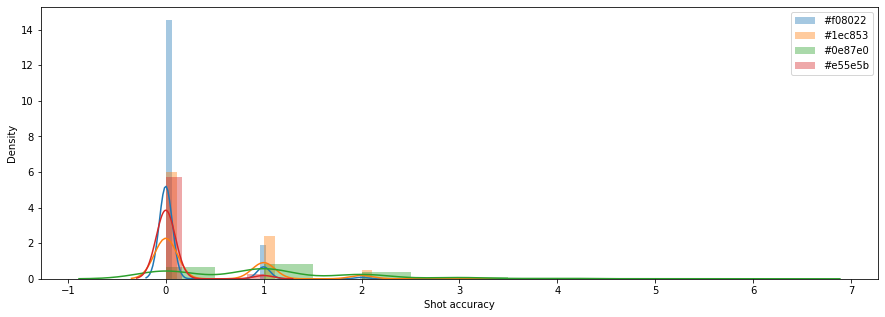

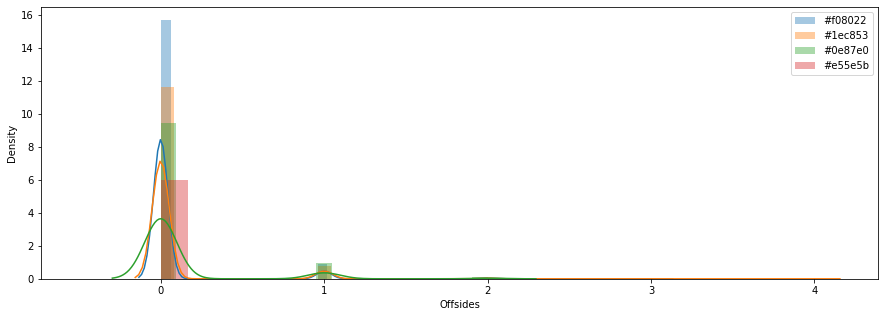

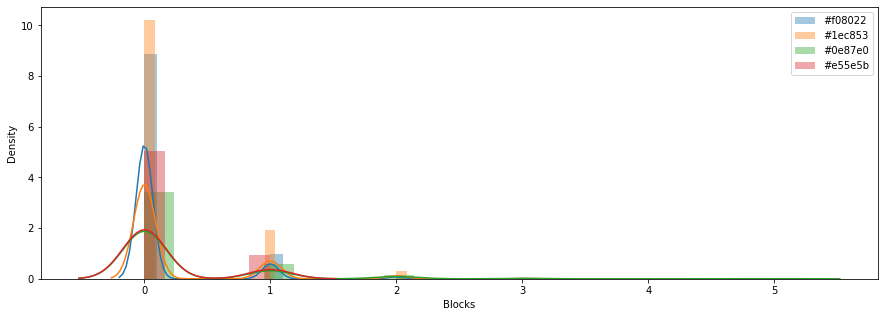

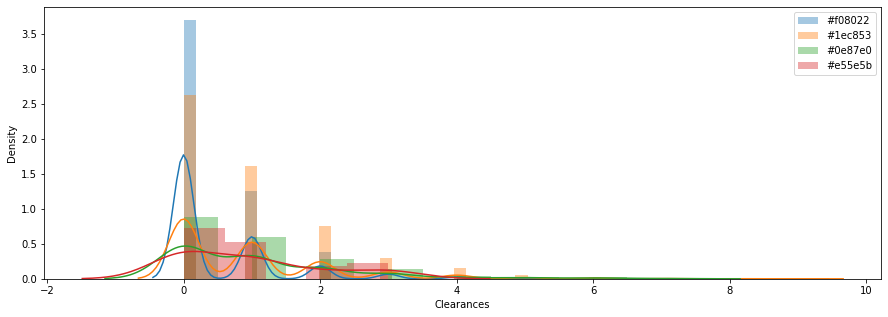

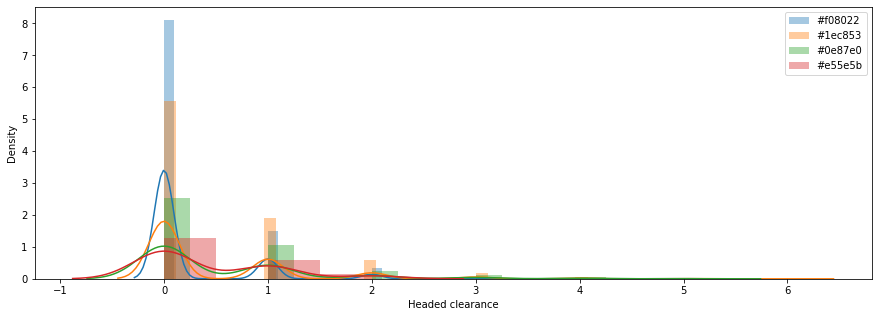

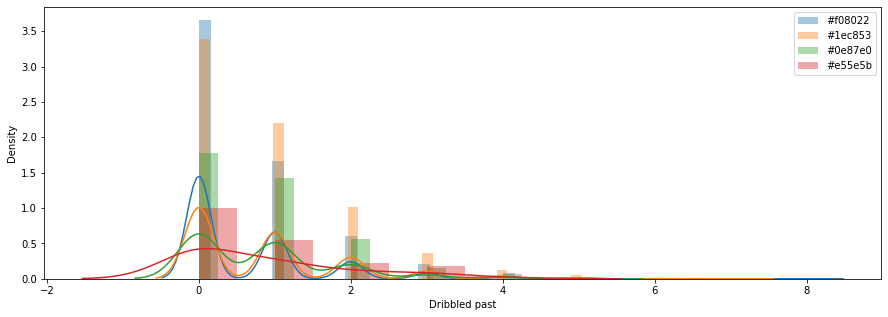

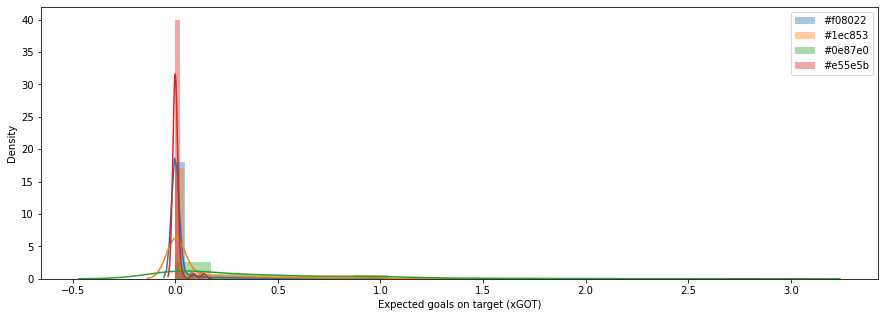

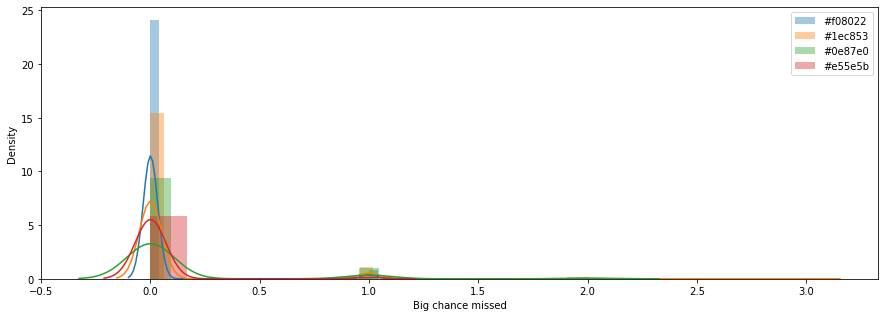

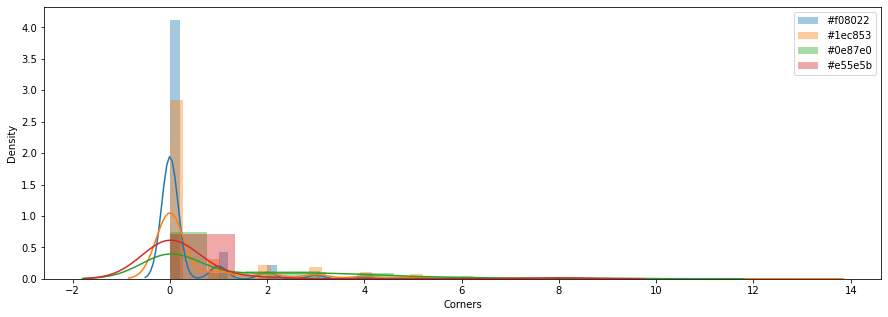

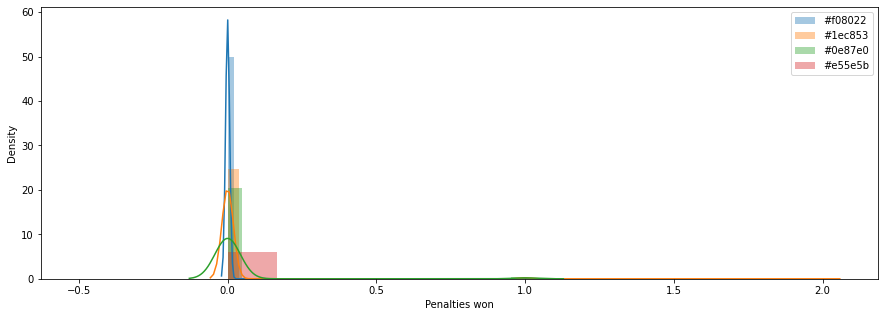

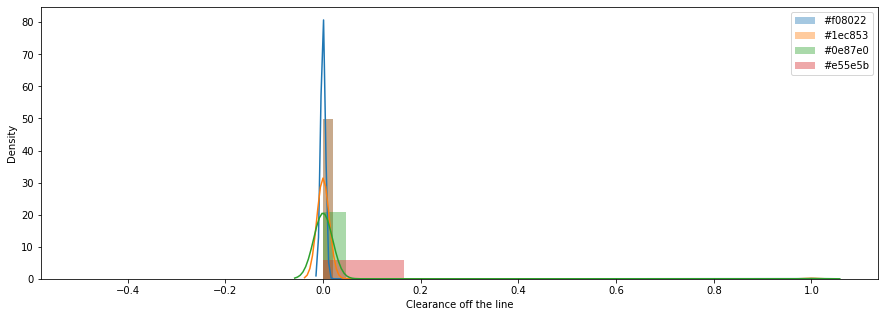

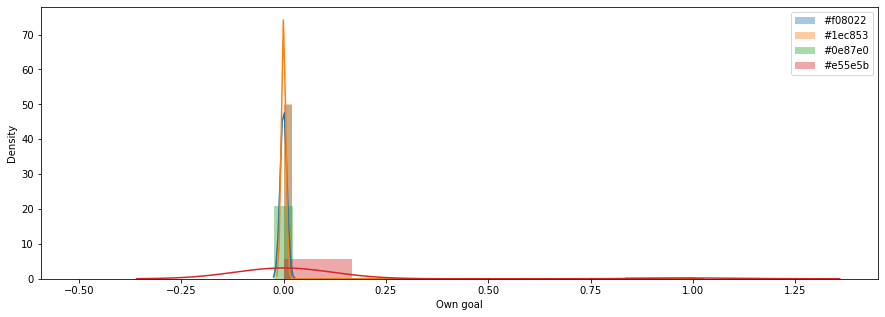

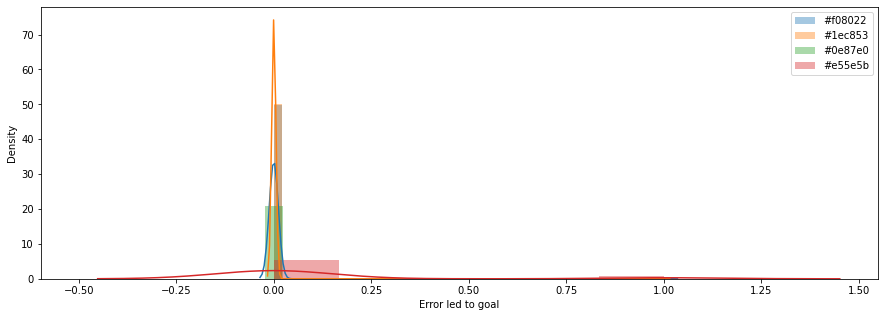

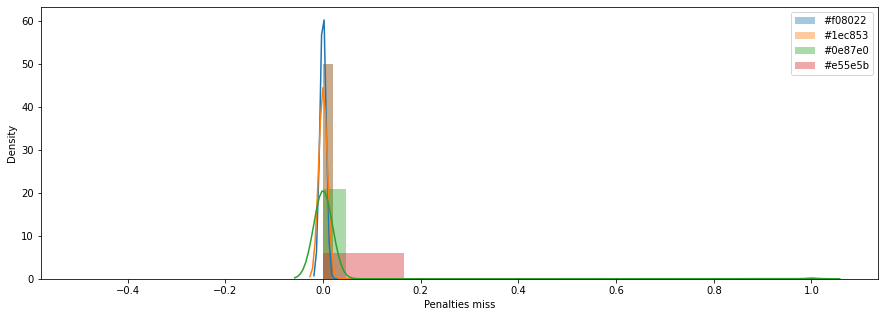

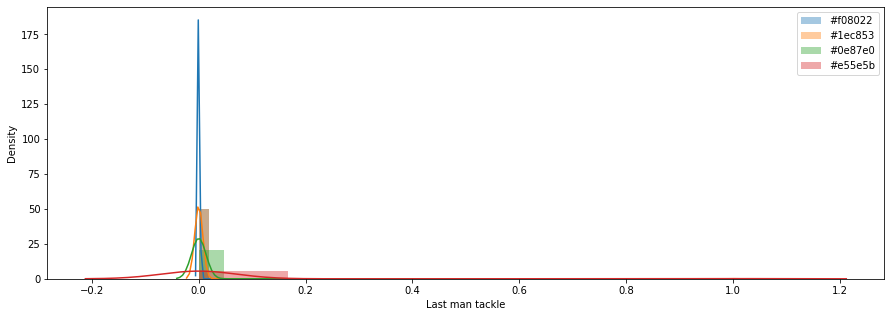

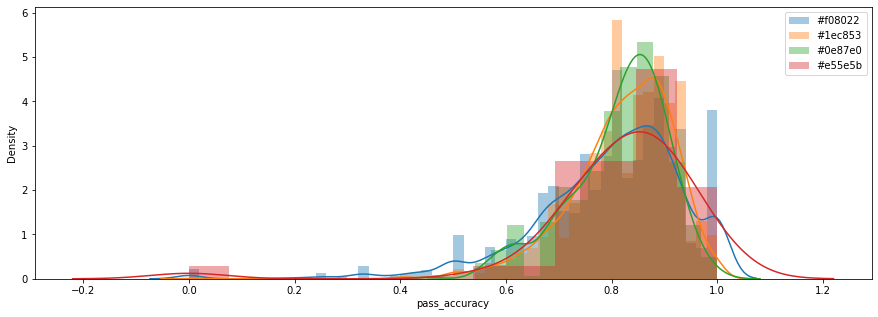

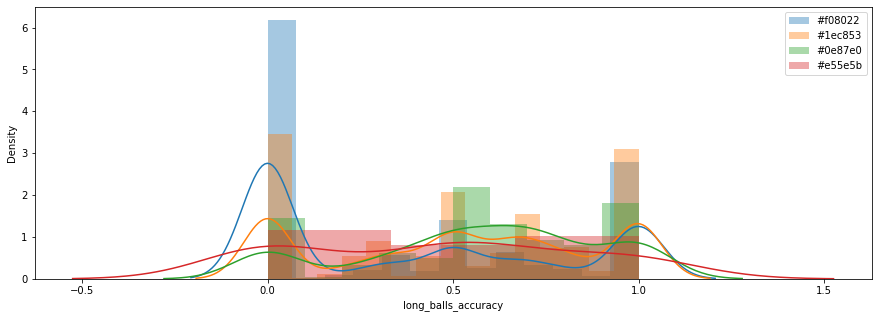

In [100]:
for column in midfielder.columns:
   plt.figure(figsize=(15,5))
   for color in rating.bgcolor.unique():
        sns.distplot(midfielder[rating.bgcolor == color][column], label=color)
        plt.legend()

In [101]:
midfielder_df = pd.merge(pd.concat([events_df, numerical_df, categorical_df], axis=1),midfielder, how="inner", right_index=True, left_index=True)

In [102]:
midfielder_df = midfielder_df.drop(["bgcolor", "FotMob rating", "role", "team_score", "opponent_score", "isSubbedOff", "yc"], axis=1)
midfielder_df = midfielder_df.loc[:,~midfielder_df.columns.duplicated()]

In [103]:
result_to_num = {"Win":2, "Draw":1, "Lose":0}
midfielder_df["result"] = midfielder_df["result"].map(result_to_num)

In [104]:
midfielder_df = midfielder_df.astype(float)

<Axes: >

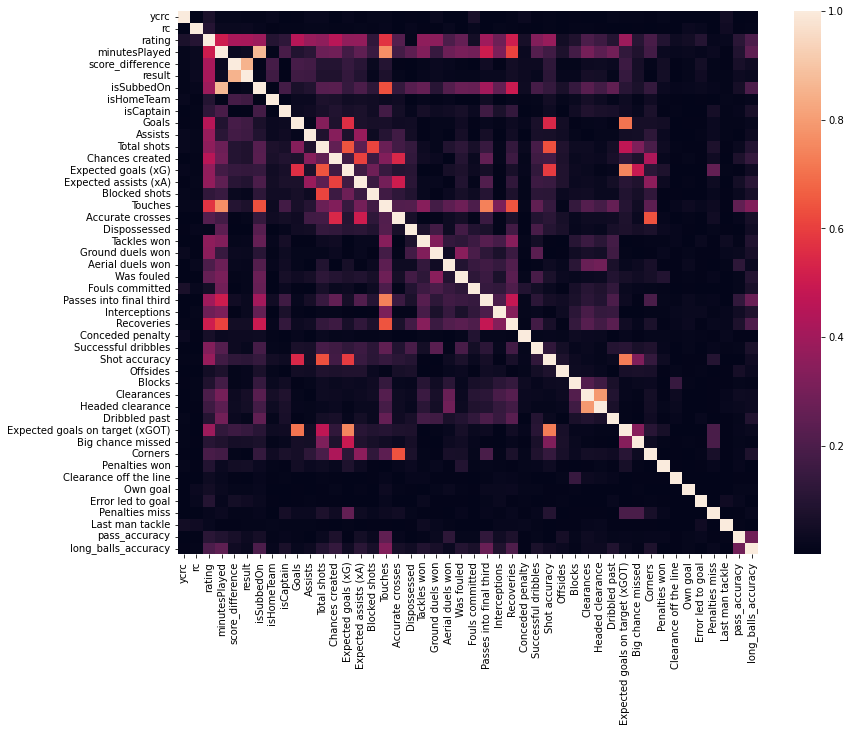

In [105]:
plt.figure(figsize=(13,10))
corr_m = midfielder_df.corr().abs()
sns.heatmap(corr_m)

<Axes: >

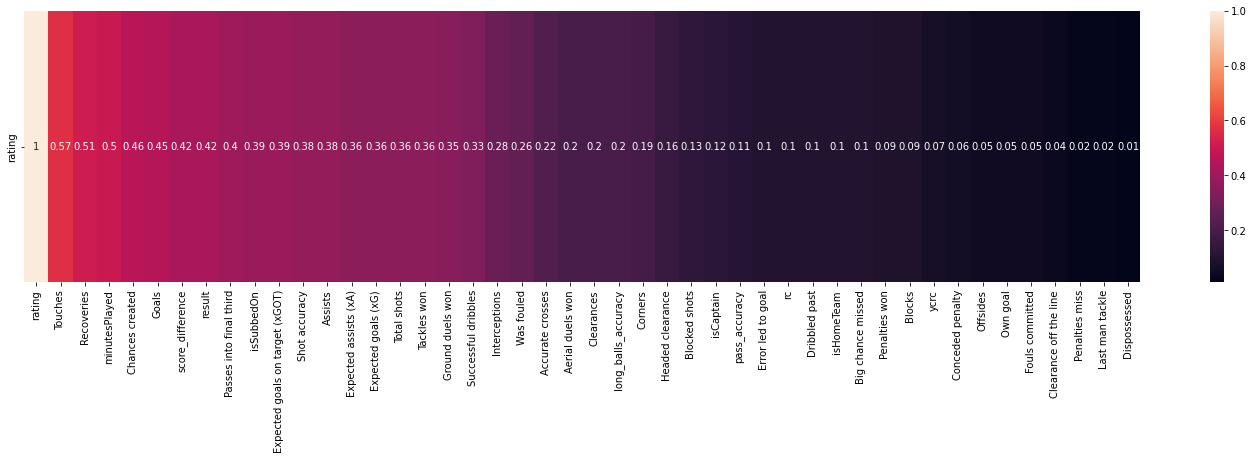

In [106]:
plt.figure(figsize=(25,5))
rating_corr = corr_m.round(2).loc[:,['rating']].sort_values(by="rating", ascending=False).T
sns.heatmap(rating_corr, annot=True)

<Axes: >

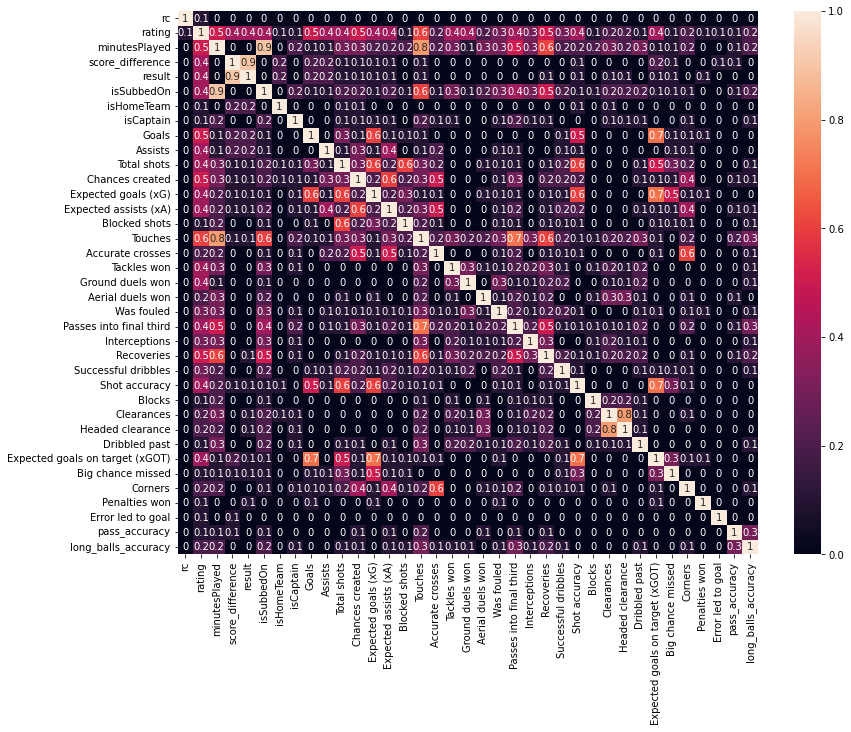

In [107]:
plt.figure(figsize=(13,10))
corr_m = midfielder_df.loc[:,(rating_corr.gt(0.08).any())].corr().abs().round(1)
sns.heatmap(corr_m, annot=True)

In [108]:
new_columns = midfielder_df.loc[:,(rating_corr.gt(0.08).any())].columns
new_columns

Index(['rc', 'rating', 'minutesPlayed', 'score_difference', 'result',
       'isSubbedOn', 'isHomeTeam', 'isCaptain', 'Goals', 'Assists',
       'Total shots', 'Chances created', 'Expected goals (xG)',
       'Expected assists (xA)', 'Blocked shots', 'Touches', 'Accurate crosses',
       'Tackles won', 'Ground duels won', 'Aerial duels won', 'Was fouled',
       'Passes into final third', 'Interceptions', 'Recoveries',
       'Successful dribbles', 'Shot accuracy', 'Blocks', 'Clearances',
       'Headed clearance', 'Dribbled past', 'Expected goals on target (xGOT)',
       'Big chance missed', 'Corners', 'Penalties won', 'Error led to goal',
       'pass_accuracy', 'long_balls_accuracy'],
      dtype='object')

### Attacker
### Most correlated columns :
['rc', 'rating', 'minutesPlayed', 'score_difference', 'result',
       'isSubbedOn', 'isHomeTeam', 'Goals', 'Assists', 'Total shots',
       'Chances created', 'Touches', 'Passes into final third',
       'Accurate crosses', 'Tackles won', 'Dribbled past', 'Ground duels won',
       'Aerial duels won', 'Was fouled', 'Successful dribbles', 'Clearances',
       'Headed clearance', 'Recoveries', 'Expected goals (xG)',
       'Expected goals on target (xGOT)', 'Shot accuracy',
       'Expected assists (xA)', 'Interceptions', 'Offsides', 'Penalties won',
       'Blocked shots', 'Corners', 'Big chance missed', 'pass_accuracy']

In [109]:
attacker = sdf.query(f"role == 'Attacker'")

In [110]:
means = attacker.isna().mean()
c_todrop = means[means == 1.0].index.tolist()
attacker = attacker.drop(c_todrop, axis=1)
attacker = attacker.drop("role", axis=1)

In [111]:
attacker.isna().mean()

FotMob rating                      0.000000
Goals                              0.000000
Assists                            0.000000
Total shots                        0.000000
Accurate passes                    0.000000
Chances created                    0.000000
Expected goals (xG)                0.269940
Expected assists (xA)              0.216997
Blocked shots                      0.697427
Touches                            0.000197
Accurate crosses                   0.517697
Dispossessed                       0.000000
Tackles won                        0.000000
Ground duels won                   0.000000
Aerial duels won                   0.000000
Was fouled                         0.000000
Fouls committed                    0.000000
Passes into final third            0.304348
Accurate long balls                0.523514
Interceptions                      0.802130
Recoveries                         0.189490
Conceded penalty                   0.997634
Successful dribbles             

In [112]:
attacker.sample(5)

FotMob rating  Goals  Assists  Total shots Accurate passes  \
4536            6.06    0.0      0.0          0.0     17/18 (94%)   
12632           6.33    0.0      0.0          1.0     18/22 (82%)   
51396           6.38    0.0      0.0          1.0     18/26 (69%)   
57931           6.46    0.0      0.0          0.0     14/20 (70%)   
40432           5.94    0.0      0.0          0.0       2/9 (22%)   

       Chances created Expected goals (xG) Expected assists (xA)  \
4536               0.0                 NaN                  0.02   
12632              0.0                0.18                  0.02   
51396              0.0                0.03                  0.03   
57931              0.0                 NaN                   NaN   
40432              0.0                 NaN                   NaN   

       Blocked shots  Touches Accurate crosses  Dispossessed Tackles won  \
4536             NaN     18.0              NaN           0.0           0   
12632            NaN     41.0         0/1 (0%)           2.0    0/2 (0%)   
51396            NaN     44.0         0/3 (0%)           0.0    0/1 (0%)   
57931            NaN     26.0              NaN           0.0           0   
40432            NaN     17.0              NaN           2.0   1/2 (50%)   

      Ground duels won Aerial duels won  Was fouled  Fouls committed  \
4536          0/1 (0%)                0         0.0              0.0   
12632       6/12 (50%)       2/2 (100%)         4.0              2.0   
51396        3/9 (33%)        1/3 (33%)         1.0              2.0   
57931       3/3 (100%)        1/4 (25%)         3.0              1.0   
40432        2/4 (50%)        1/3 (33%)         0.0              0.0   

       Passes into final third Accurate long balls  Interceptions  Recoveries  \
4536                       1.0            0/1 (0%)            NaN         NaN   
12632                      4.0           1/2 (50%)            NaN         3.0   
51396                      4.0           3/4 (75%)            NaN         2.0   
57931                      2.0          1/1 (100%)            NaN         5.0   
40432                      1.0            0/1 (0%)            1.0         1.0   

       Conceded penalty Successful dribbles Shot accuracy  Offsides  Blocks  \
4536                NaN                 NaN           NaN       NaN     NaN   
12632               NaN            0/2 (0%)      0/1 (0%)       2.0     NaN   
51396               NaN           1/5 (20%)    1/1 (100%)       NaN     NaN   
57931               NaN                 NaN           NaN       NaN     NaN   
40432               NaN                 NaN           NaN       NaN     NaN   

       Clearances  Headed clearance  Dribbled past  \
4536          NaN               NaN            1.0   
12632         NaN               NaN            NaN   
51396         NaN               NaN            1.0   
57931         NaN               NaN            NaN   
40432         NaN               NaN            NaN   

      Expected goals on target (xGOT)  Big chance missed  Corners  \
4536                              NaN                NaN      NaN   
12632                             NaN                NaN      NaN   
51396                            0.04                NaN      NaN   
57931                             NaN                NaN      NaN   
40432                             NaN                NaN      NaN   

       Penalties won  Clearance off the line  Own goal  Error led to goal  \
4536             NaN                     NaN       NaN                NaN   
12632            NaN                     NaN       NaN                NaN   
51396            NaN                     NaN       NaN                NaN   
57931            NaN                     NaN       NaN                NaN   
40432            NaN                     NaN       NaN                NaN   

       Penalties miss  Last man tackle  
4536              NaN              NaN  
12632             NaN              NaN  
51396

In [113]:
attacker = attacker.fillna(0)

In [114]:
attacker["pass_accuracy"] = (attacker["Accurate passes"].str.extract("\((?P<pass_accuracy>\d+)%").astype(float)/100).fillna(0)
attacker["long_balls_accuracy"] = (attacker["Accurate long balls"].str.extract("\((?P<long_balls_accuracy>\d+)%").astype(float)/100).fillna(0)
attacker["Ground duels won"] = (attacker["Ground duels won"].str.extract("\((?P<Ground_duels_won>\d+)%").astype(float)/100).fillna(0)


In [115]:
attacker = attacker.drop(["Accurate long balls", "Accurate passes"], axis=1)

In [116]:
attacker["Accurate crosses"] = attacker["Accurate crosses"].str.extract("(?P<Accurate_crosses>\d+)").fillna(0)
attacker["Tackles won"] = attacker["Tackles won"].str.extract("(?P<Tackles_won>\d+)").fillna(0)
attacker["Aerial duels won"] = attacker["Aerial duels won"].str.extract("(?P<Aerial_duels_won>\d+)").fillna(0)
attacker["Successful dribbles"] = attacker["Successful dribbles"].str.extract("(?P<Successful_dribbles>\d+)").fillna(0)


In [117]:
attacker["Shot accuracy"] = attacker["Shot accuracy"].str.extract("(?P<shots_acc>\d+)").fillna(0)

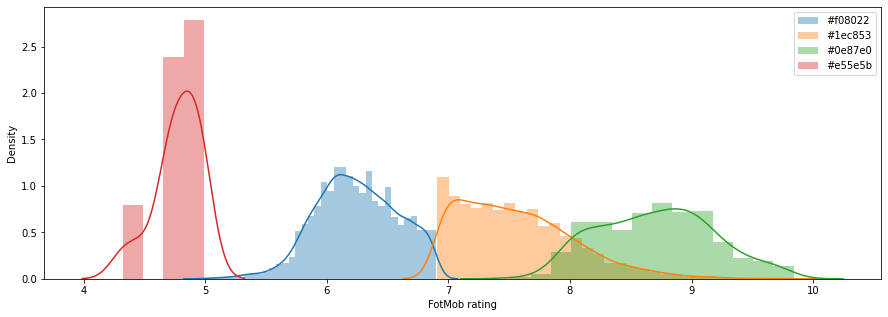

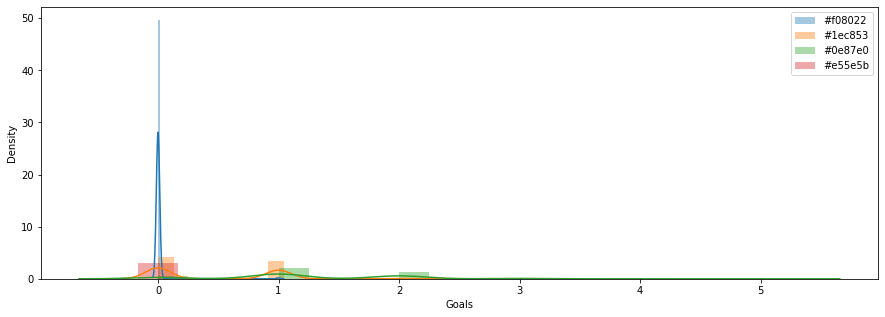

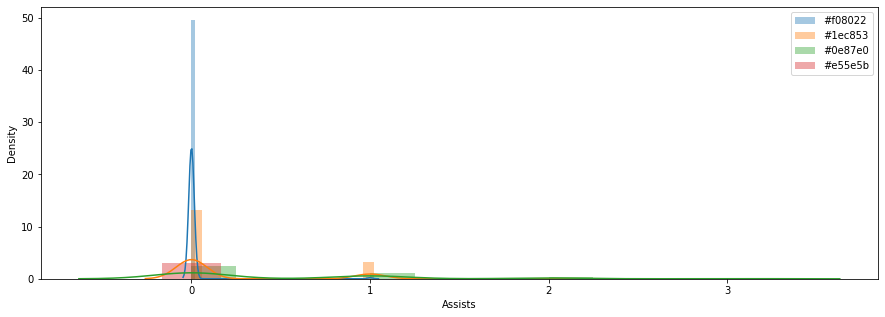

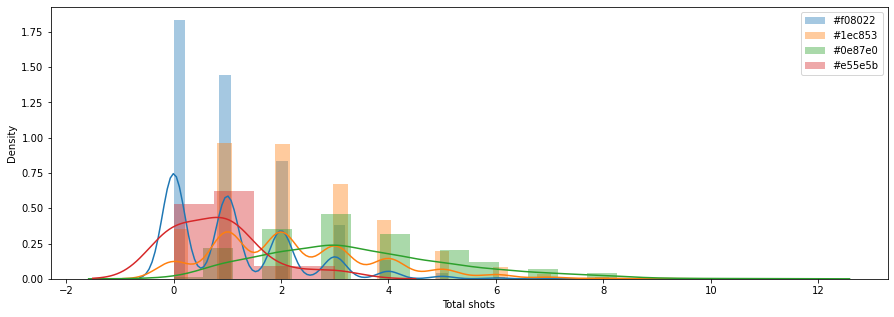

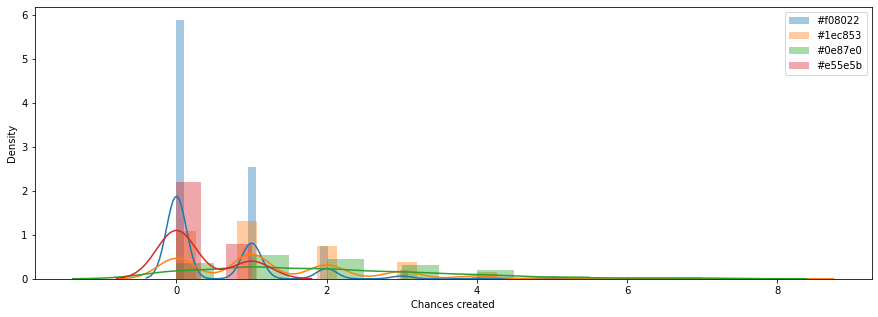

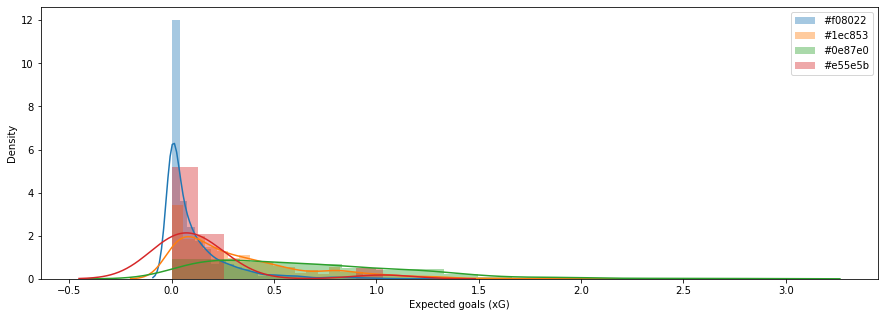

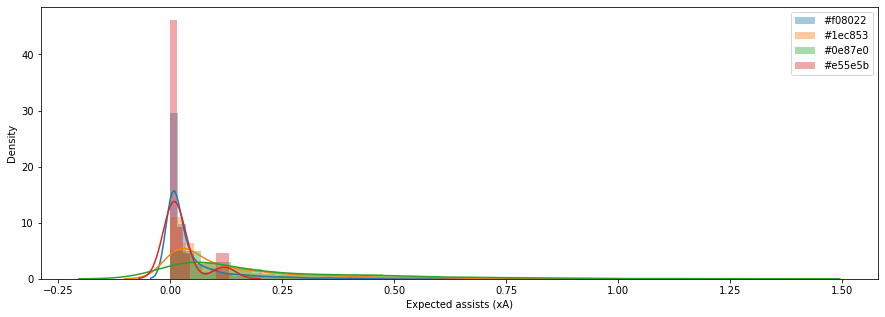

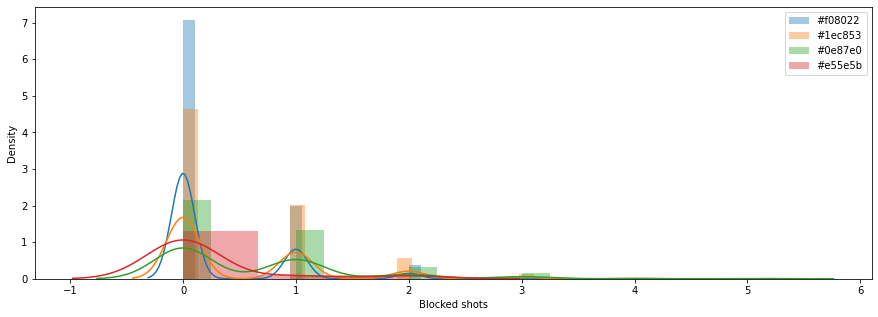

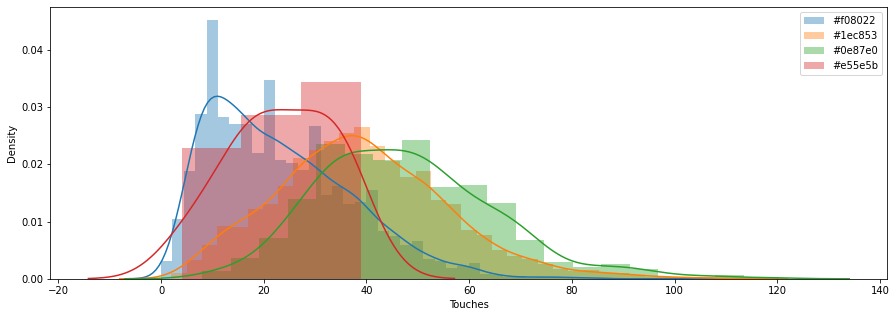

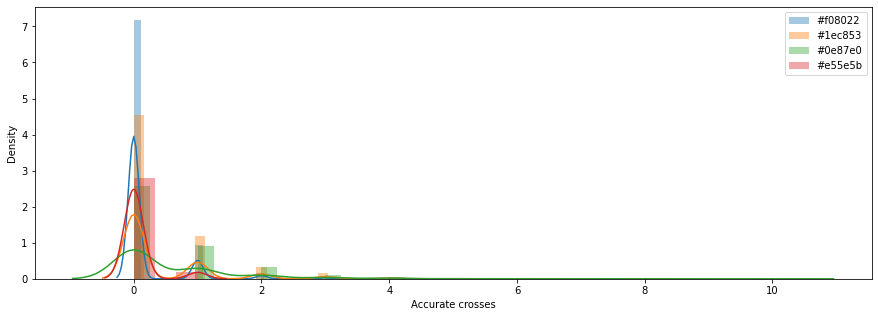

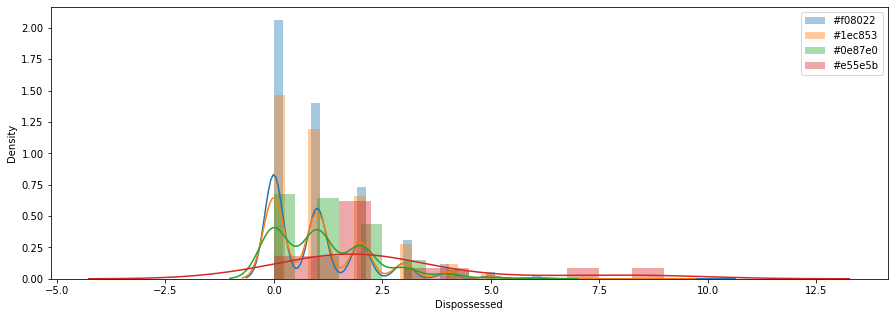

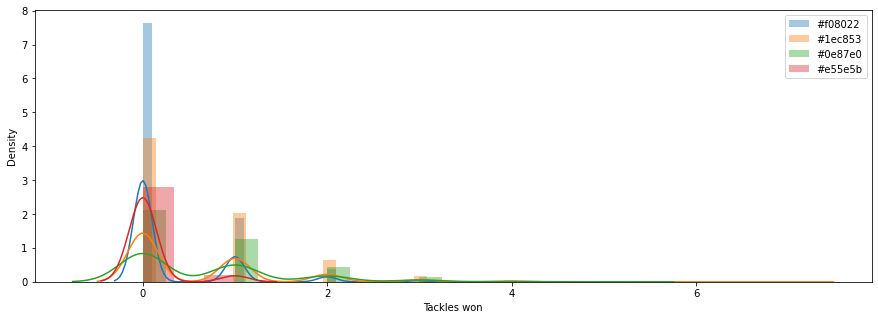

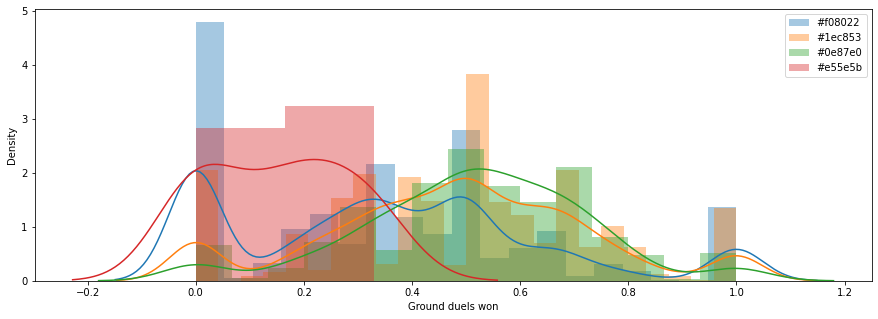

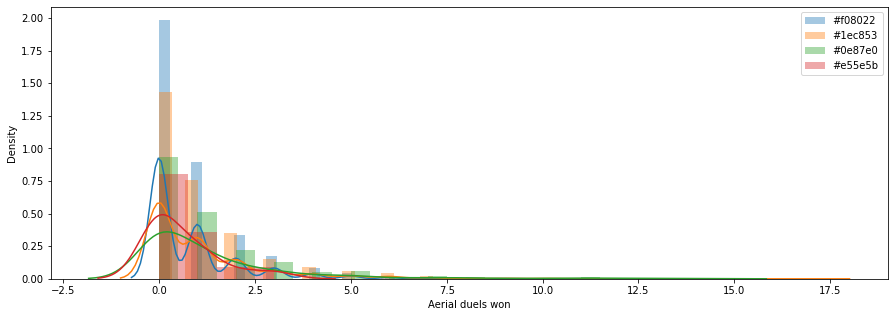

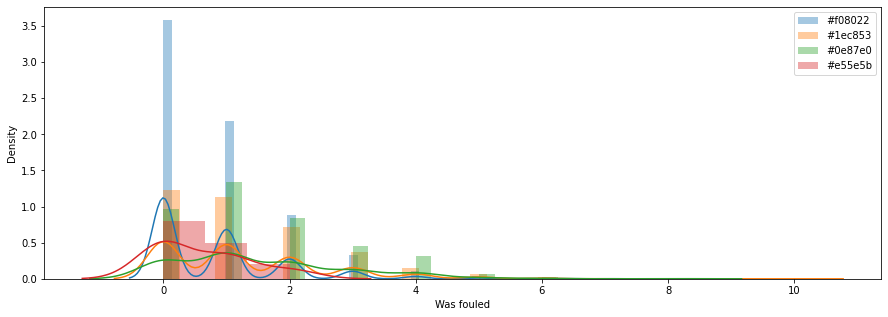

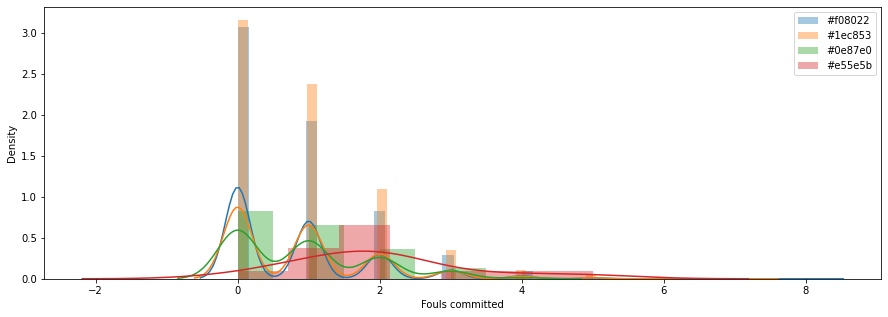

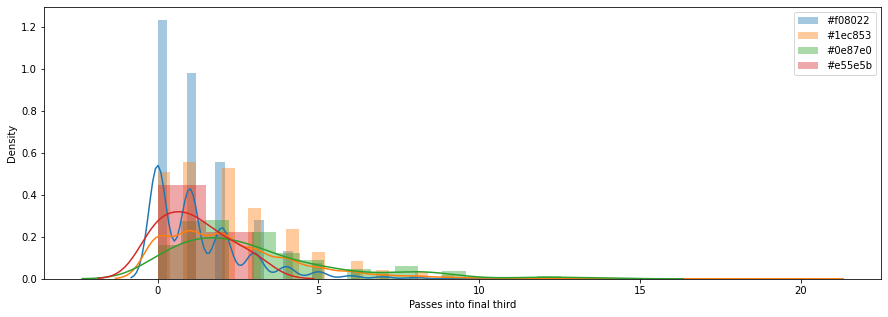

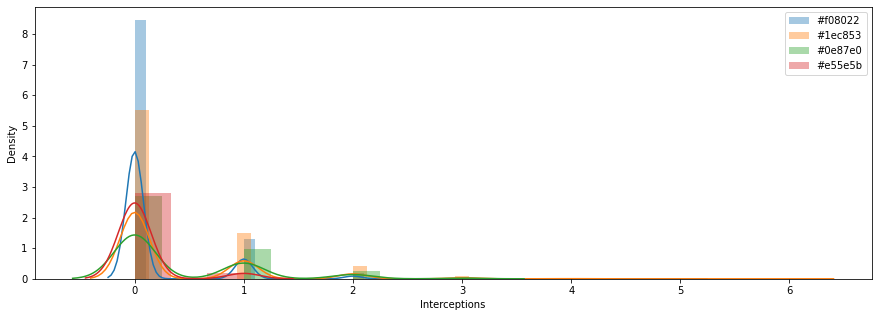

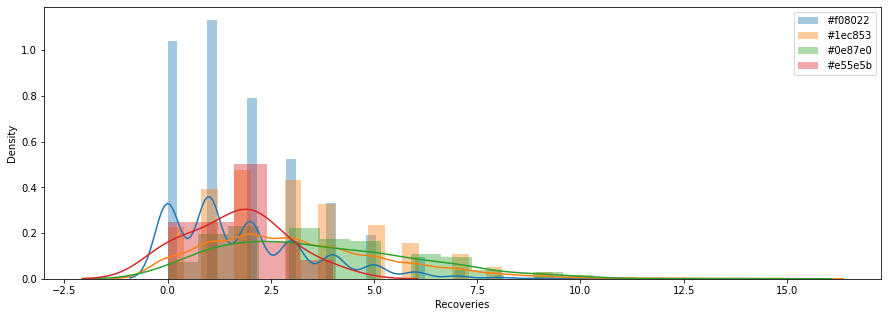

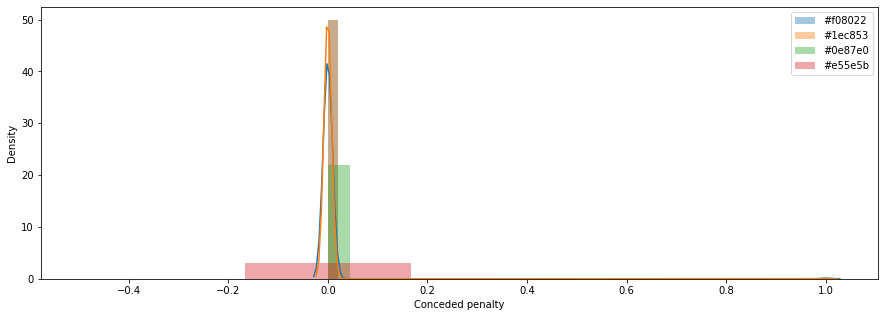

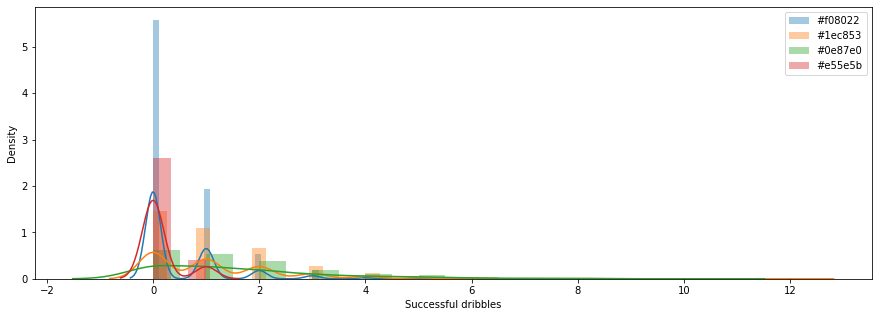

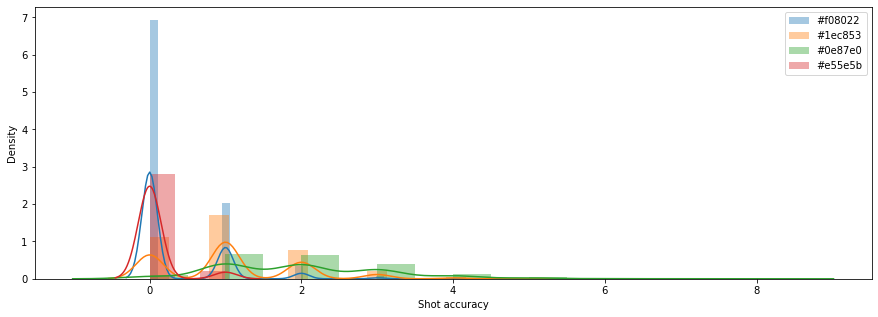

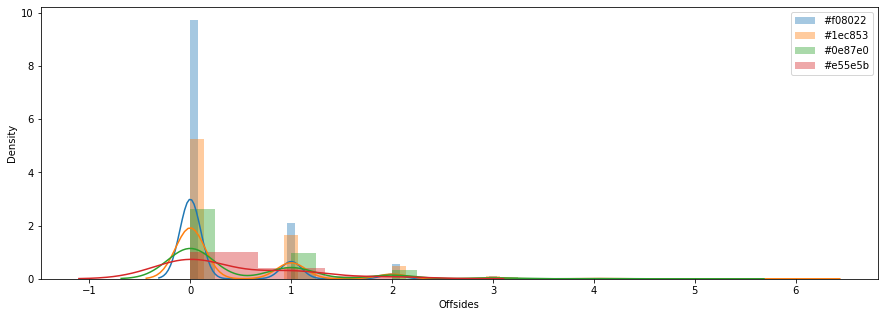

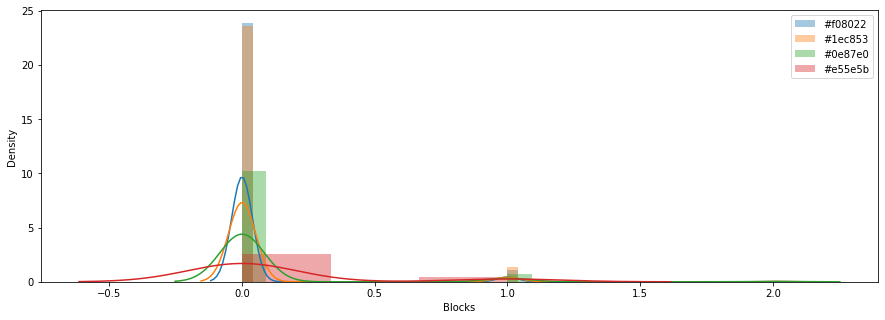

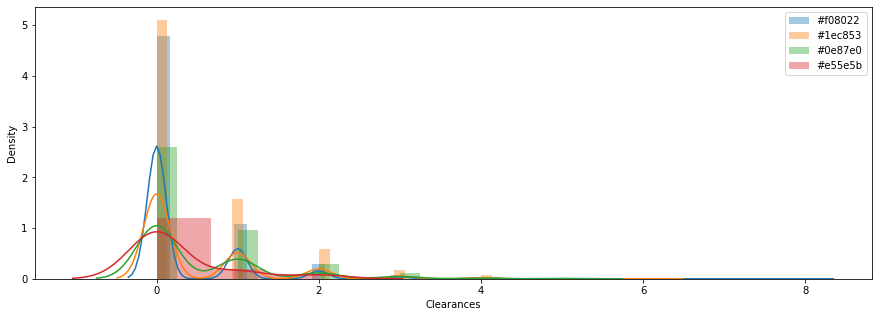

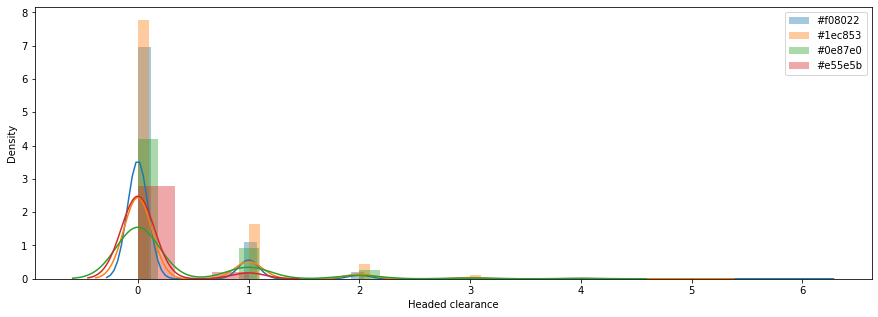

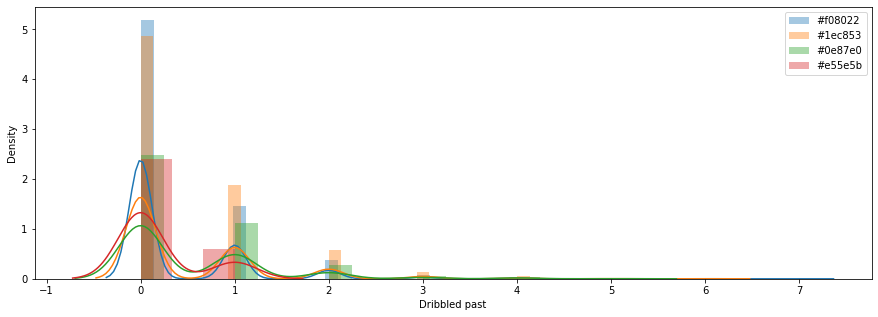

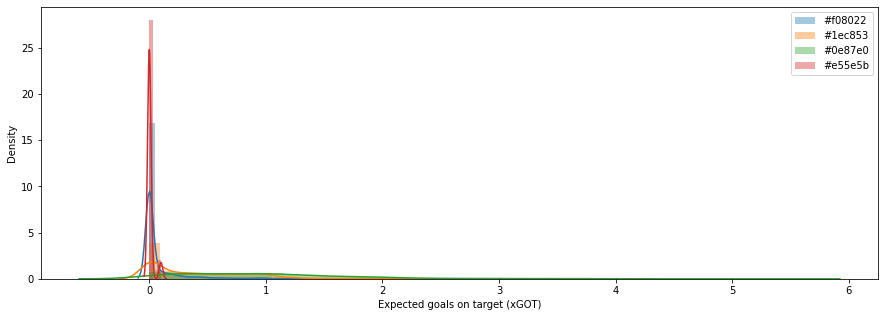

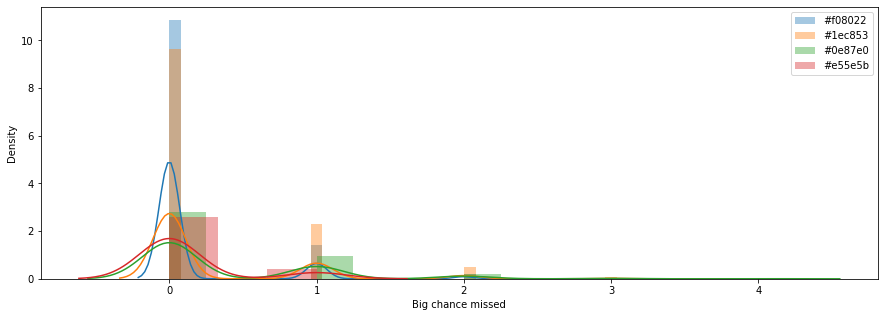

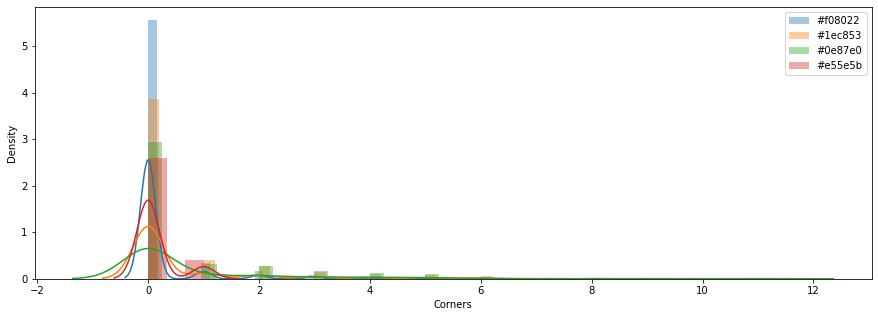

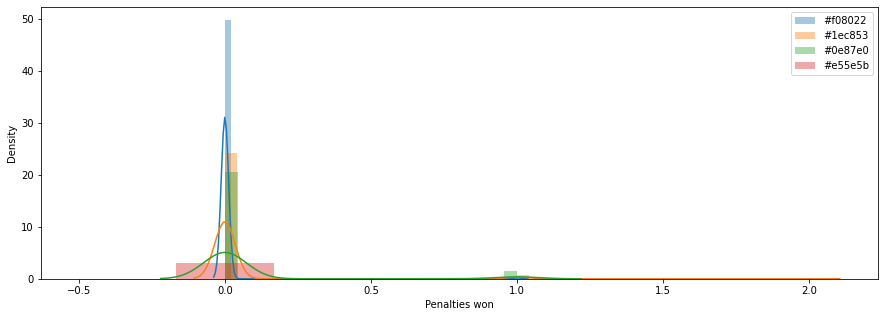

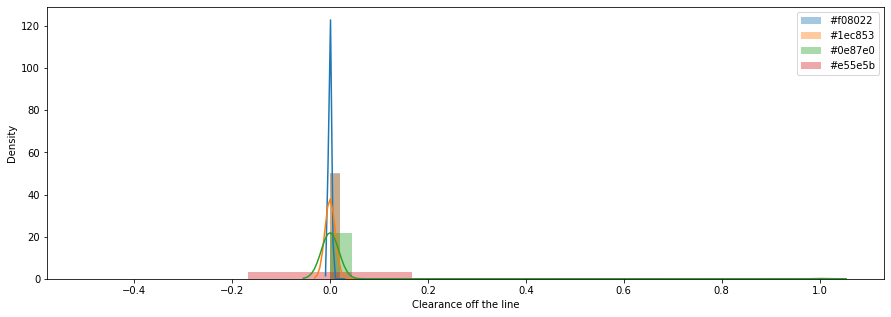

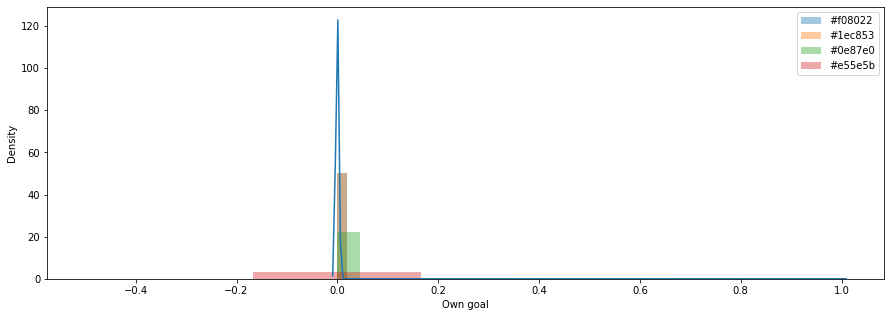

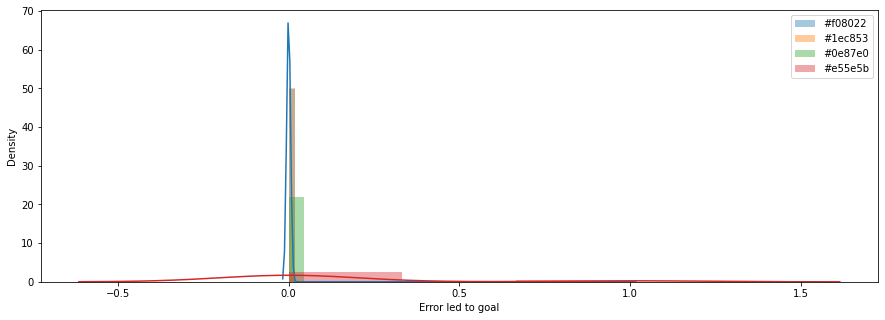

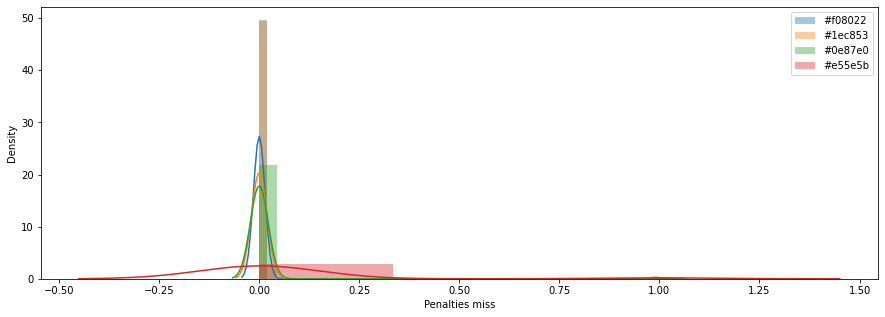

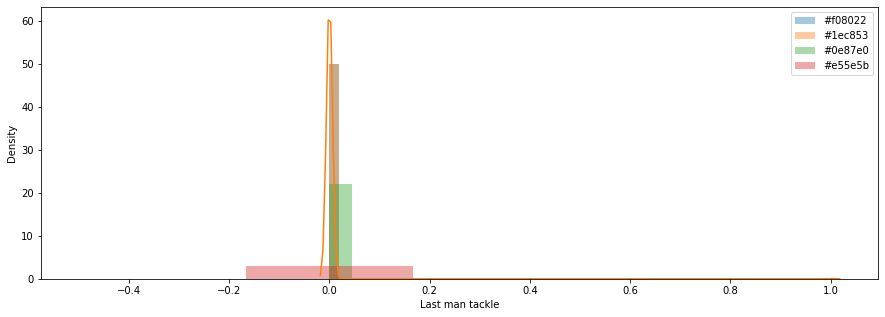

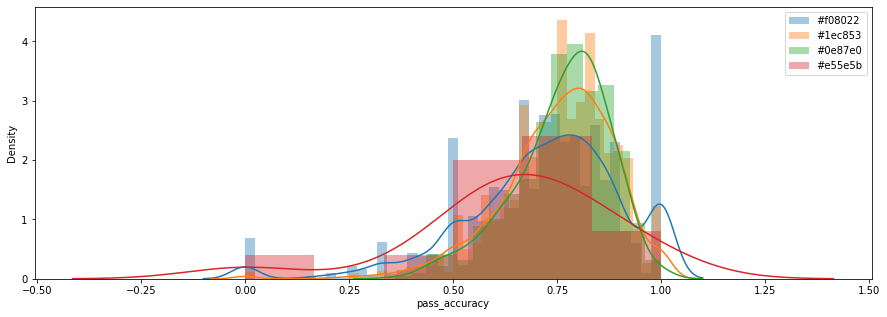

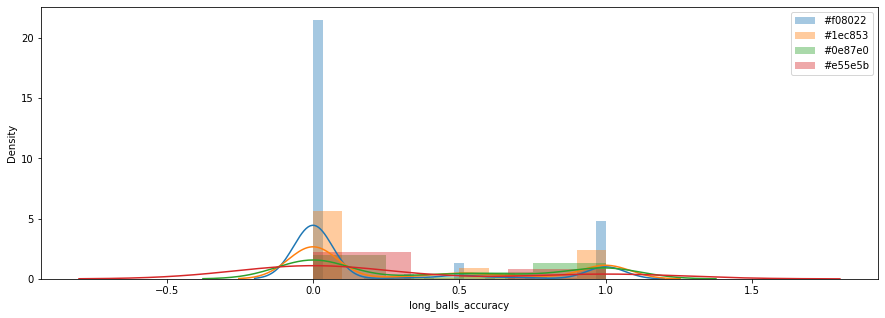

In [118]:
for column in attacker.columns:
   plt.figure(figsize=(15,5))
   for color in rating.bgcolor.unique():
        sns.distplot(attacker[rating.bgcolor == color][column], label=color)
        plt.legend()

In [119]:
attacker_df = pd.merge(pd.concat([events_df, numerical_df, categorical_df], axis=1),attacker, how="inner", right_index=True, left_index=True)

In [120]:
attacker_df = attacker_df.drop(["bgcolor", "FotMob rating", "role", "team_score", "opponent_score", "isSubbedOff", "yc"], axis=1)
attacker_df = attacker_df.loc[:,~attacker_df.columns.duplicated()]

In [121]:
result_to_num = {"Win":2, "Draw":1, "Lose":0}
attacker_df["result"] = attacker_df["result"].map(result_to_num)

In [122]:
attacker_df = attacker_df.astype(float)

<Axes: >

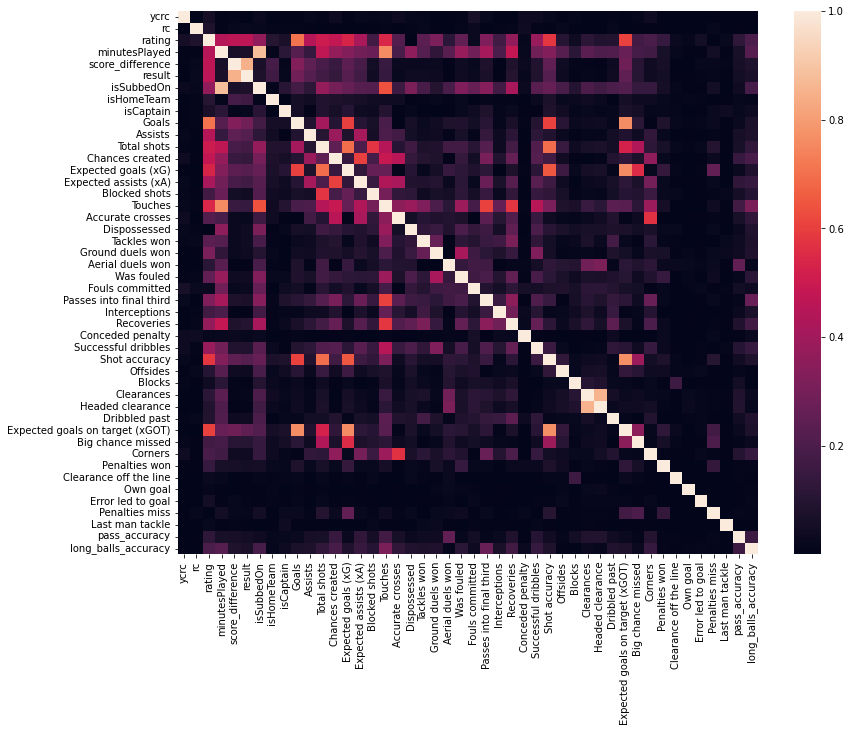

In [123]:
plt.figure(figsize=(13,10))
corr_m = attacker_df.corr().abs()
sns.heatmap(corr_m)

<Axes: >

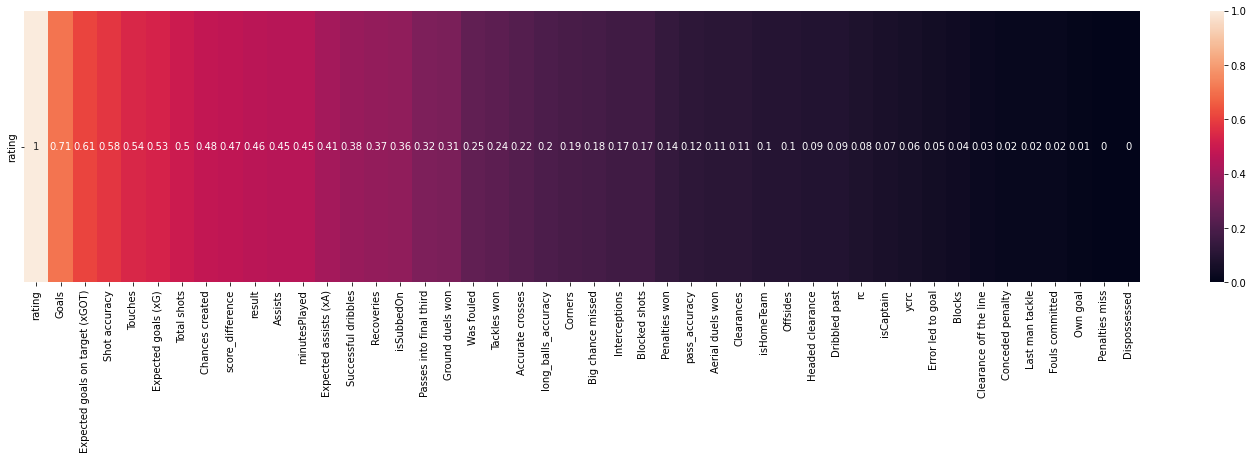

In [124]:
plt.figure(figsize=(25,5))
rating_corr = corr_m.round(2).loc[:,['rating']].sort_values(by="rating", ascending=False).T
sns.heatmap(rating_corr, annot=True)

<Axes: >

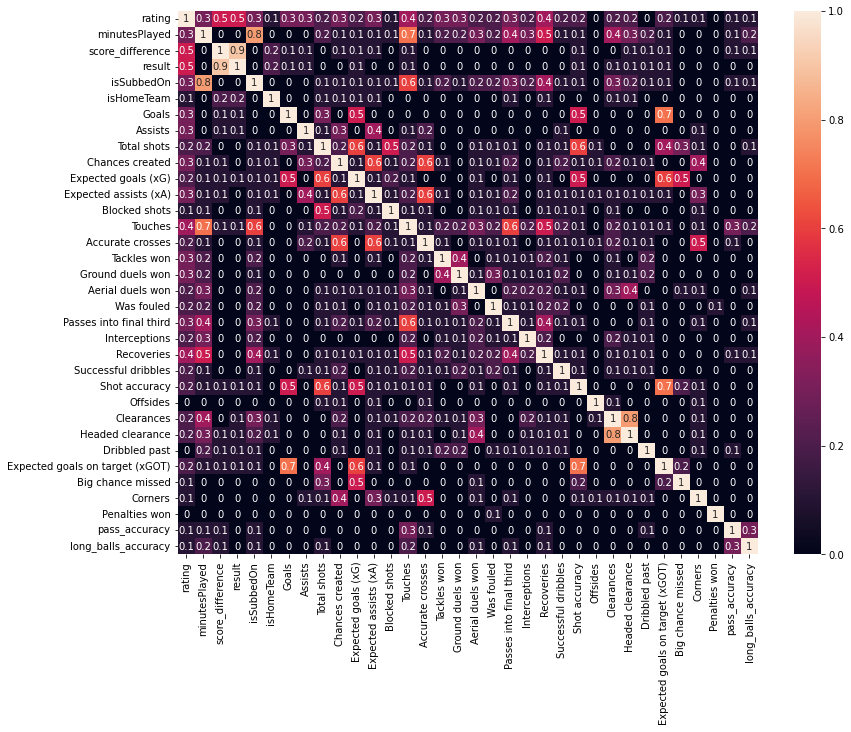

In [125]:
plt.figure(figsize=(13,10))
corr_m = defender_df.loc[:,(rating_corr.gt(0.08).any())].corr().abs().round(1)
sns.heatmap(corr_m, annot=True)

In [126]:
new_columns = attacker_df.loc[:,(rating_corr.gt(0.08).any())].columns
new_columns

Index(['rating', 'minutesPlayed', 'score_difference', 'result', 'isSubbedOn',
       'isHomeTeam', 'Goals', 'Assists', 'Total shots', 'Chances created',
       'Expected goals (xG)', 'Expected assists (xA)', 'Blocked shots',
       'Touches', 'Accurate crosses', 'Tackles won', 'Ground duels won',
       'Aerial duels won', 'Was fouled', 'Passes into final third',
       'Interceptions', 'Recoveries', 'Successful dribbles', 'Shot accuracy',
       'Offsides', 'Clearances', 'Headed clearance', 'Dribbled past',
       'Expected goals on target (xGOT)', 'Big chance missed', 'Corners',
       'Penalties won', 'pass_accuracy', 'long_balls_accuracy'],
      dtype='object')